<a href="https://colab.research.google.com/github/himamuralik/Ship-trajectory-prediction-benchmarking-dissertation/blob/main/ship_trajectory_prediction_final_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install keras-tuner gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.9 MB/s eta 0:00:00


## Data

### Download Data

In [ ]:
#@title downloader.py
%%writefile downloader.py
import os
import time
from calendar import monthrange
from concurrent.futures import ThreadPoolExecutor, as_completed

import requests
from tqdm import tqdm

base_url = "https://coast.noaa.gov/htdata/CMSP/AISDataHandler/"
year = 2015

start_month, start_day = 1, 2   # Jan 02
end_month, end_day = 7, 30     # → Dec 31

dest_dir = "./data/downloads/2015"
os.makedirs(dest_dir, exist_ok=True)

def iter_days(y, m1, d1, m2, d2):
    m, d = m1, d1
    while True:
        yield m, d
        if m == m2 and d == d2:
            break
        d += 1
        last = monthrange(y, m)[1]
        if d > last:
            d = 1
            m += 1

def download(url, out_path, retries=3, chunk_size=1024 * 1024):
    if os.path.exists(out_path) and os.path.getsize(out_path) > 0:
        return "skip"
    backoff = 2
    for attempt in range(1, retries + 1):
        try:
            with requests.get(url, stream=True, timeout=(15, 120)) as r:
                r.raise_for_status()
                tmp_path = out_path + ".part"
                with open(tmp_path, "wb") as f:
                    for chunk in r.iter_content(chunk_size=chunk_size):
                        if chunk:
                            f.write(chunk)
                os.replace(tmp_path, out_path)
                return "ok"
        except Exception as e:
            if attempt == retries:
                return f"fail: {e}"
            time.sleep(backoff)
            backoff *= 2

days = list(iter_days(year, start_month, start_day, end_month, end_day))

# Optional pre-filter to avoid scheduling already-downloaded files
tasks = []
for month, day in days:
    fname = f"AIS_{year}_{month:02d}_{day:02d}.zip"
    out_path = os.path.join(dest_dir, fname)
    if not (os.path.exists(out_path) and os.path.getsize(out_path) > 0):
        url = f"{base_url}{year}/{fname}"
        tasks.append((fname, url, out_path))

max_workers = 8  # adjust as desired
future_to_name = {}
with ThreadPoolExecutor(max_workers=max_workers) as ex:
    for fname, url, out_path in tasks:
        future_to_name[ex.submit(download, url, out_path)] = fname

    for fut in tqdm(as_completed(future_to_name), total=len(future_to_name), desc="Files", unit="file"):
        fname = future_to_name[fut]
        status = fut.result()
        if status == "ok":
            # print(f"Downloaded: {fname}")
            continue
        elif status == "skip":
            print(f"Exists, skipped: {fname}")
        else:
            print(f"{fname}: {status}")

Writing downloader.py


In [ ]:
!python downloader.py

Files:   4% 8/210 [00:08<03:33,  1.06s/file]
^C


### Preprocess

In [ ]:
#@title preprocess.py (Updated: writes per-split mmsi_list)
%%writefile preprocess.py

import argparse
import os
import zipfile
from dataclasses import dataclass
from typing import Dict, Tuple, Generator, List

import h5py
import numpy as np
import pandas as pd
from tqdm import tqdm
from datetime import datetime, timezone


# ============================
# Configuration and constants
# ============================

@dataclass(frozen=True)
class DatasetConfig:
    dataset_name: str
    lat_1: float
    lat_2: float
    lon_1: float
    lon_2: float
    sliding_window_movement: int
    depth_1: float = 0
    depth_2: float = 0
    min_pts_to_try: object = None
    eps_to_try: object = None
    min_pts_to_use: object = None
    eps_to_use: object = None

    @property
    def lat_min(self) -> float:
        return min(self.lat_1, self.lat_2)

    @property
    def lat_max(self) -> float:
        return max(self.lat_1, self.lat_2)

    @property
    def lon_min(self) -> float:
        return min(self.lon_1, self.lon_2)

    @property
    def lon_max(self) -> float:
        return max(self.lon_1, self.lon_2)


datasets = {
    "new_york": DatasetConfig(
        dataset_name="new_york",
        lat_1=39.50,
        lon_1=-74.50,
        lat_2=41.50,
        lon_2=-71.50,
        sliding_window_movement=60 * 60,
        min_pts_to_try=[4, 10, 20, 50, 100, 250, 500],
        eps_to_try=[
            0.0001, 0.00025, 0.0005, 0.00075, 0.001, 0.0025, 0.005, 0.0075, 0.01,
            0.025, 0.05, 0.075, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1,
            1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5, 6, 7, 8, 9, 10,
        ],
        min_pts_to_use=50,
        eps_to_use=3,
    )
}

# Selected dataset
DS = datasets["new_york"]
LAT_MIN, LAT_MAX = DS.lat_min, DS.lat_max
LON_MIN, LON_MAX = DS.lon_min, DS.lon_max

# Model/data temporal configuration
NEW_TRAJECTORY_TIME_GAP = 2 * 60 * 60  # seconds
INTERPOLATION_TIME_GAP = 30 * 60  # seconds (30 minutes)
HISTORY_HORIZON_SEC = 3 * 60 * 60  # seconds (3 hours)
FUTURE_STEPS = 6  # 6 steps into the future
LENGTH_INTO_THE_FUTURE = FUTURE_STEPS * INTERPOLATION_TIME_GAP
MIN_TRACK_LENGTH = HISTORY_HORIZON_SEC + LENGTH_INTO_THE_FUTURE

# Column schemas
COLUMNS_DTYPES: Dict[str, np.dtype] = {
    "mmsi": np.int64,
    "timestamp": np.int64,
    "lat": np.float32,
    "lon": np.float32,
    "sog": np.float32,
    "cog": np.float32,
    "heading": np.float32,
    "track": np.int32,
}

READ_COLUMNS = [
    "MMSI",
    "BaseDateTime",
    "LAT",
    "LON",
    "SOG",
    "COG",
    "Heading",
]

_TRAIN_MONTHS = {1,2,3,4}
_VALID_MONTHS = {6}
_TEST_MONTHS = {7,8,9,10}

# UPDATED: Reduced from 50 to 35 knots for tighter filtering
MAX_SPEED_KNOTS = 35.0


# ============================
# Split helpers
# ============================

def _month_to_split(month: int) -> str:
    if month in _TRAIN_MONTHS:
        return "train"
    if month in _VALID_MONTHS:
        return "valid"
    return "test"



# ============================
# Cleaning helpers
# ============================

def _valid_mmsi(series: pd.Series) -> pd.Series:
    s = series.astype(str)
    nine = s.str.len() == 9
    first3 = pd.to_numeric(s.str.slice(0, 3), errors="coerce").fillna(-1).astype(int)
    return nine & first3.between(201, 775)


def _haversine_km(
    lat1: pd.Series, lon1: pd.Series, lat2: pd.Series, lon2: pd.Series
) -> np.ndarray:
    R = 6371.0
    lat1r, lon1r, lat2r, lon2r = map(
        np.radians, [lat1.to_numpy(), lon1.to_numpy(), lat2.to_numpy(), lon2.to_numpy()]
    )
    dlon = lon2r - lon1r
    dlat = lat2r - lat1r
    a = np.sin(dlat / 2) ** 2 + np.cos(lat1r) * np.cos(lat2r) * np.sin(dlon / 2) ** 2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c


def _apply_cleaning(df: pd.DataFrame, state: Dict[int, Dict[str, float]]) -> pd.DataFrame:
    if df.empty:
        return df

    ts_dt = pd.to_datetime(
        df["BaseDateTime"], format="%Y-%m-%dT%H:%M:%S", utc=True, errors="coerce"
    )
    df = df.assign(_ts_dt=ts_dt)

    df["LAT"] = pd.to_numeric(df["LAT"], errors="coerce")
    df["LON"] = pd.to_numeric(df["LON"], errors="coerce")

    df = df.dropna(subset=["MMSI", "_ts_dt", "LAT", "LON"]).copy()

    df = df[(df["LAT"].between(-90.0, 90.0)) & (df["LON"].between(-180.0, 180.0))]
    df = df[(df["LAT"].between(LAT_MIN, LAT_MAX)) & (df["LON"].between(LON_MIN, LON_MAX))]
    df = df[_valid_mmsi(df["MMSI"])].copy()
    if df.empty:
        return df.iloc[0:0]

    df = df.sort_values(["MMSI", "_ts_dt"])
    df = df.drop_duplicates(subset=["MMSI", "_ts_dt", "LAT", "LON"], keep="first")

    prev_lat = df.groupby("MMSI")["LAT"].shift(1)
    prev_lon = df.groupby("MMSI")["LON"].shift(1)
    prev_ts = df.groupby("MMSI")["_ts_dt"].shift(1)

    first_in_chunk = df["MMSI"].ne(df["MMSI"].shift(1))
    if first_in_chunk.any():
        idxs = df.index[first_in_chunk]
        mmsi_vals = df.loc[idxs, "MMSI"].astype(int).tolist()
        prev_lat_vals = []
        prev_lon_vals = []
        prev_ts_vals = []
        for m in mmsi_vals:
            st = state.get(int(m))
            if st is None:
                prev_lat_vals.append(np.nan)
                prev_lon_vals.append(np.nan)
                prev_ts_vals.append(pd.NaT)
            else:
                prev_lat_vals.append(st["lat"])
                prev_lon_vals.append(st["lon"])
                prev_ts_vals.append(st["ts"])
        prev_lat.loc[idxs] = prev_lat_vals
        prev_lon.loc[idxs] = prev_lon_vals
        prev_ts.loc[idxs] = pd.DatetimeIndex(prev_ts_vals, tz="UTC")

    moved = (df["LAT"].to_numpy() != prev_lat.to_numpy()) | (
        df["LON"].to_numpy() != prev_lon.to_numpy()
    )
    df = df[moved].copy()
    if df.empty:
        return df

    dt = df["_ts_dt"] - prev_ts.reindex(df.index)
    dt_sec = dt.dt.total_seconds()
    gap = NEW_TRAJECTORY_TIME_GAP
    new_segment = first_in_chunk | (dt_sec > float(gap)) | dt_sec.isna()
    dt_hours = dt_sec.fillna(0) / 3600.0
    dt_hours.loc[new_segment] = 0.0

    distance_km = _haversine_km(
        df["LAT"], df["LON"], prev_lat.reindex(df.index), prev_lon.reindex(df.index)
    )
    distance_km_series = pd.Series(distance_km, index=df.index)
    distance_km_series.loc[new_segment] = 0.0

    dt_hours_values = dt_hours.values
    speed_kmh = np.zeros_like(distance_km_series.values, dtype=float)
    np.divide(
        distance_km_series.values,
        dt_hours_values,
        out=speed_kmh,
        where=dt_hours_values > 0.0,
    )
    speed_knots = speed_kmh / 1.852
    keep_speed = speed_knots <= MAX_SPEED_KNOTS
    df = df[keep_speed].copy()
    if df.empty:
        return df

    last_rows = df.groupby("MMSI").tail(1)
    for _, row in last_rows.iterrows():
        key = int(row["MMSI"])
        ts_val = pd.Timestamp(row["_ts_dt"]).tz_convert("UTC")
        state[key] = {"ts": ts_val, "lat": float(row["LAT"]), "lon": float(row["LON"])}

    return df


TrackState = Dict[Tuple[int, str], Dict[str, object]]


def _assign_split_and_track(df: pd.DataFrame, state: TrackState) -> pd.DataFrame:
    if df.empty:
        return df

    months = df["_ts_dt"].dt.month
    splits = months.apply(_month_to_split)
    df = df.assign(_split=splits)

    out_frames = []
    gap = NEW_TRAJECTORY_TIME_GAP

    for (mmsi, split), g in df.groupby(["MMSI", "_split"], sort=True):
        g = g.sort_values("_ts_dt").copy()
        dt_sec = g["_ts_dt"].diff().dt.total_seconds().fillna(np.inf).to_numpy()
        new_flags = dt_sec > gap

        prev = state.get((int(mmsi), str(split)))
        if prev is None:
            base_track = 0
        else:
            prev_ts = pd.Timestamp(prev["ts"])
            boundary_new = (g["_ts_dt"].iloc[0] - prev_ts).total_seconds() > gap
            base_track = int(prev["track"]) + (1 if boundary_new else 0)

        local_ids = np.cumsum(new_flags.astype(np.int32))
        track_ids = (local_ids + base_track).astype(np.int32)
        g["track"] = track_ids

        state[(int(mmsi), str(split))] = {
            "ts": g["_ts_dt"].iloc[-1],
            "track": int(g["track"].iloc[-1]),
        }
        out_frames.append(g)

    return pd.concat(out_frames, axis=0, ignore_index=True)


# ============================
# Filtering and transformation
# ============================

def _filter_bbox(df: pd.DataFrame) -> pd.DataFrame:
    return df[(df["LAT"].between(LAT_MIN, LAT_MAX)) & (df["LON"].between(LON_MIN, LON_MAX))]


def _drop_short_tracks(df: pd.DataFrame, min_span_sec: int) -> pd.DataFrame:
    if df.empty:
        return df.iloc[0:0]
    spans = (
        df.groupby(["MMSI", "_split", "track"])
        ["_ts_dt"].agg(["min", "max"]).reset_index()
    )
    spans["span_sec"] = (spans["max"] - spans["min"]).dt.total_seconds()
    keep_keys = spans.loc[spans["span_sec"] >= float(min_span_sec), ["MMSI", "_split", "track"]]
    if keep_keys.empty:
        return df.iloc[0:0]
    return df.merge(keep_keys, on=["MMSI", "_split", "track"], how="inner")


def _transform_chunk(df: pd.DataFrame) -> Dict[str, np.ndarray]:
    if df.empty:
        return {}

    ts_utc = df["_ts_dt"]
    if not isinstance(ts_utc.dtype, pd.DatetimeTZDtype):
        ts_utc = ts_utc.dt.tz_localize("UTC")
    else:
        ts_utc = ts_utc.dt.tz_convert("UTC")
    ts = (ts_utc.astype("int64") // 10 ** 9)

    out: Dict[str, np.ndarray] = {
        "mmsi": df["MMSI"].astype("int64").to_numpy(copy=False),
        "timestamp": ts.astype("int64", copy=False).to_numpy(copy=False),
        "lat": df["LAT"].astype("float32").to_numpy(copy=False),
        "lon": df["LON"].astype("float32").to_numpy(copy=False),
        "sog": df["SOG"].astype("float32").to_numpy(copy=False),
        "cog": df["COG"].astype("float32").to_numpy(copy=False),
        "heading": df["Heading"].astype("float32").to_numpy(copy=False),
        "track": df["track"].astype("int32").to_numpy(copy=False),
    }
    out["_split"] = df["_split"].astype(str).to_numpy()

    mask = None
    for k, arr in out.items():
        if k == "_split":
            continue
        m = (
            ~np.isfinite(arr)
            if isinstance(arr, np.ndarray) and arr.dtype.kind in ("f", "i")
            else np.zeros_like(out["timestamp"], dtype=bool)
        )
        mask = m if mask is None else (mask | m)
    if mask is not None and mask.any():
        keep = ~mask
        for k in list(out.keys()):
            if k == "_split":
                out[k] = out[k][keep]
                continue
            out[k] = out[k][keep]

    return out


# ============================
# Window generation
# ============================

def _angle_to_unit(x_deg: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    x_rad = np.deg2rad(x_deg.astype(np.float32))
    return np.sin(x_rad), np.cos(x_rad)


def _window_generator(
    df: pd.DataFrame,
    history_seconds: int,
    step_seconds: int,
    target_future_steps: int,
    history_min_obs: int = 2,
    future_min_obs: int = 2,
    min_abs_lat_disp: float = 0.0,
    min_abs_lon_disp: float = 0.0,
    require_exact_future_steps: bool = True,
) -> Generator[Tuple[np.ndarray, np.ndarray, Dict[str, np.ndarray]], None, None]:
    if "track" not in df.columns:
        df = df.copy()
        df["track"] = 0

    for _, group in df.groupby("track", sort=False):
        group = group.sort_values("timestamp")

        timestamps = group["timestamp"].astype("int64").values
        lat_values = group["lat"].values.astype("float32")
        lon_values = group["lon"].values.astype("float32")
        sog_values = (
            group.get("sog", pd.Series(index=group.index, dtype="float32")).fillna(0).astype("float32").values
        )
        cog_values = (
            group.get("cog", pd.Series(index=group.index, dtype="float32")).fillna(0).astype("float32").values
        )
        hdg_values = (
            group.get("heading", pd.Series(index=group.index, dtype="float32")).fillna(0).astype("float32").values
        )

        cog_sin, cog_cos = _angle_to_unit(cog_values)
        hdg_sin, hdg_cos = _angle_to_unit(hdg_values)

        for anchor_idx in range(len(timestamps)):
            anchor_time = timestamps[anchor_idx]

            hist_mask = (timestamps >= anchor_time - history_seconds) & (timestamps <= anchor_time)
            if not np.any(hist_mask):
                continue
            if hist_mask.sum() < history_min_obs:
                continue

            hist_lat = lat_values[hist_mask]
            hist_lon = lon_values[hist_mask]
            masked_ts = timestamps[hist_mask]

            hist_dt = np.diff(masked_ts, prepend=masked_ts[0])
            hist_dlat = np.diff(hist_lat, prepend=hist_lat[0]) / np.where(hist_dt == 0, 1, hist_dt)
            hist_dlon = np.diff(hist_lon, prepend=hist_lon[0]) / np.where(hist_dt == 0, 1, hist_dt)

            features = [
                hist_lat,
                hist_lon,
                hist_dlat.astype("float32"),
                hist_dlon.astype("float32"),
                sog_values[hist_mask],
                cog_sin[hist_mask],
                cog_cos[hist_mask],
                hdg_sin[hist_mask],
                hdg_cos[hist_mask],
            ]
            history = np.stack(features, axis=1)

            future_targets = anchor_time + np.arange(
                step_seconds, (target_future_steps + 1) * step_seconds, step_seconds
            )

            available_future_steps = 0
            for i, target_ts in enumerate(future_targets):
                if target_ts > timestamps[-1]:
                    break
                available_future_steps = i + 1

            if require_exact_future_steps and available_future_steps < target_future_steps:
                continue

            future_targets = future_targets[:available_future_steps]

            if len(future_targets) > 0:
                fut_obs_mask = (timestamps > anchor_time) & (timestamps <= future_targets[-1])
                if fut_obs_mask.sum() < future_min_obs:
                    continue
            else:
                continue

            fut_lat = np.interp(future_targets, timestamps, lat_values)
            fut_lon = np.interp(future_targets, timestamps, lon_values)

            fut_dlat = np.zeros_like(fut_lat)
            fut_dlon = np.zeros_like(fut_lon)

            if len(future_targets) > 0:
                fut_dlat[0] = (fut_lat[0] - lat_values[anchor_idx]) / step_seconds
                fut_dlon[0] = (fut_lon[0] - lon_values[anchor_idx]) / step_seconds
                for i in range(1, len(future_targets)):
                    fut_dlat[i] = (fut_lat[i] - fut_lat[i-1]) / step_seconds
                    fut_dlon[i] = (fut_lon[i] - fut_lon[i-1]) / step_seconds

                lat_disp = float(np.abs(fut_lat[-1] - lat_values[anchor_idx]))
                lon_disp = float(np.abs(fut_lon[-1] - lon_values[anchor_idx]))
                if (lat_disp < min_abs_lat_disp) and (lon_disp < min_abs_lon_disp):
                    continue

                future = np.stack([fut_lat, fut_lon, fut_dlat, fut_dlon], axis=1)

                meta: Dict[str, np.ndarray] = {
                    "anchor_timestamp": np.int64(anchor_time),
                    "future_target_timestamps": future_targets.astype("int64"),
                    "future_steps_actual": len(future_targets),
                    "track": np.int32(group["track"].iloc[0]) if "track" in group.columns else np.int32(0),
                }

                yield history.astype("float32"), future.astype("float32"), meta


class TrajectoryDatasetBuilder:
    """Converts a directory of ZIP-ed CSV files into an HDF5 dataset of trajectory windows."""

    def __init__(self, ds_config: DatasetConfig):
        self.ds_config = ds_config
        self._last_clean_state: Dict[int, Dict[str, float]] = {}
        self._track_state: TrackState = {}

        # NEW: in-memory per-split MMSI index
        self._split_mmsi: Dict[str, set] = {"train": set(), "valid": set(), "test": set()}

    def build(self, zip_dir: str, out_h5_path: str, group_name: str = "splits", chunksize: int = 200_000) -> None:
        zip_files = [f for f in os.listdir(zip_dir) if f.lower().endswith(".zip")]
        zip_files.sort()
        if not zip_files:
            raise FileNotFoundError(f"No .zip files found in {zip_dir}")

        if os.path.exists(out_h5_path):
            print(f"File {out_h5_path} already exists. exiting...")
            return

        os.makedirs(os.path.dirname(out_h5_path) or ".", exist_ok=True)

        self._last_clean_state = {}
        self._track_state = {}
        self._split_mmsi = {"train": set(), "valid": set(), "test": set()}  # NEW: reset

        with h5py.File(out_h5_path, "a") as h5:
            root = self._init_root_group_and_attrs(h5, group_name, zip_dir)
            next_id_by_split = self._ensure_split_groups(root)
            self._process_csv_in_zip_files(zip_dir, zip_files, root, next_id_by_split, chunksize)

            # NEW: write the per-split MMSI lists to HDF5
            self._write_split_mmsi_index(root)

            h5.flush()

    # ----------------------------
    # Private helpers
    # ----------------------------

    def _init_root_group_and_attrs(self, h5: h5py.File, group_name: str, zip_dir: str) -> h5py.Group:
        root = h5.require_group(group_name)
        if "schema_version" not in root.attrs:
            root.attrs["schema_version"] = "trajectory_windows_v1"
        root.attrs["created_at"] = root.attrs.get("created_at", datetime.now(timezone.utc).isoformat())
        root.attrs["updated_at"] = datetime.now(timezone.utc).isoformat()
        root.attrs["dataset_name"] = self.ds_config.dataset_name
        root.attrs["lat_min"] = float(self.ds_config.lat_min)
        root.attrs["lat_max"] = float(self.ds_config.lat_max)
        root.attrs["lon_min"] = float(self.ds_config.lon_min)
        root.attrs["lon_max"] = float(self.ds_config.lon_max)
        root.attrs["history_horizon_sec"] = int(HISTORY_HORIZON_SEC)
        root.attrs["interpolation_time_gap_sec"] = int(INTERPOLATION_TIME_GAP)
        root.attrs["future_steps"] = int(FUTURE_STEPS)
        root.attrs["min_track_length_sec"] = int(MIN_TRACK_LENGTH)
        root.attrs["new_trajectory_time_gap_sec"] = int(NEW_TRAJECTORY_TIME_GAP)
        root.attrs["max_speed_knots"] = float(MAX_SPEED_KNOTS)
        root.attrs["zip_dir"] = str(zip_dir)
        root.attrs["history_feature_names"] = "lat,lon,dlat_dt,dlon_dt,sog,cog_sin,cog_cos,hdg_sin,hdg_cos"
        root.attrs["future_feature_names"] = "lat,lon,dlat_dt,dlon_dt"
        return root

    def _ensure_split_groups(self, root: h5py.Group) -> Dict[str, int]:
        next_id_by_split: Dict[str, int] = {}
        for _split_name in ("train", "valid", "test"):
            _sg = root.require_group(_split_name)
            _sg.attrs["split"] = _split_name
            _sg.attrs["updated_at"] = datetime.now(timezone.utc).isoformat()
            if "num_samples" not in _sg.attrs:
                _sg.attrs["num_samples"] = 0
            next_id_by_split[_split_name] = int(_sg.attrs.get("next_id", 0))
        return next_id_by_split

    def _process_csv_in_zip_files(
        self,
        zip_dir: str,
        zip_files: List[str],
        root: h5py.Group,
        next_id_by_split: Dict[str, int],
        chunksize: int,
    ) -> None:
        with tqdm(zip_files, desc="Processing ZIPs", unit="file") as tqdm_prog:
            for fname in tqdm_prog:
                zpath = os.path.join(zip_dir, fname)
                try:
                    with zipfile.ZipFile(zpath) as z:
                        csv_name = next(n for n in z.namelist() if n.lower().endswith(".csv"))
                        with z.open(csv_name) as csvfile:
                            self._process_csv_file_like(csvfile, fname, root, next_id_by_split, chunksize, tqdm_prog)
                except Exception as e:
                    print(f"[warn] failed {zpath}: {e}")

    def _process_csv_file_like(
        self,
        file_like,
        zip_name: str,
        root: h5py.Group,
        next_id_by_split: Dict[str, int],
        chunksize: int,
        tqdm_prog: tqdm,
    ) -> None:
        for chunk in pd.read_csv(
            file_like,
            usecols=READ_COLUMNS,
            chunksize=chunksize,
            low_memory=False,
        ):
            arrays = self._prepare_arrays_from_chunk(chunk)
            if not arrays:
                continue
            tqdm_prog.set_postfix(zip=zip_name, next_id_by_split=f"{next_id_by_split.__str__()}")
            self._write_arrays_to_h5(arrays, root, next_id_by_split)

    def _prepare_arrays_from_chunk(self, chunk: pd.DataFrame) -> Dict[str, np.ndarray]:
        chunk["SOG"] = pd.to_numeric(chunk["SOG"], errors="coerce")
        chunk["COG"] = pd.to_numeric(chunk["COG"], errors="coerce")
        chunk["Heading"] = pd.to_numeric(chunk["Heading"], errors="coerce")

        sub = _filter_bbox(chunk)
        if sub.empty:
            return {}
        cleaned = _apply_cleaning(sub, self._last_clean_state)
        if cleaned.empty:
            return {}
        augmented = _assign_split_and_track(cleaned, self._track_state)
        if augmented.empty:
            return {}
        filtered = _drop_short_tracks(augmented, MIN_TRACK_LENGTH)
        if filtered.empty:
            return {}
        arrays = _transform_chunk(filtered)
        return arrays

    def _write_arrays_to_h5(self, arrays: Dict[str, np.ndarray], root: h5py.Group, next_id_by_split: Dict[str, int]) -> None:
        splits = arrays.pop("_split")
        df = pd.DataFrame(arrays)
        for split_name in ("train", "valid", "test"):
            split_mask = splits == split_name
            if not np.any(split_mask):
                continue
            split_group = root.require_group(split_name)
            if split_name not in next_id_by_split:
                next_id_by_split[split_name] = int(split_group.attrs.get("next_id", 0))

            for mmsi in np.unique(arrays["mmsi"][split_mask]).astype(np.int64):
                mmsi_mask = split_mask & (arrays["mmsi"] == mmsi)
                if not np.any(mmsi_mask):
                    continue
                df_mmsi = df[mmsi_mask]
                for history, future, meta in _window_generator(
                    df_mmsi,
                    HISTORY_HORIZON_SEC,
                    INTERPOLATION_TIME_GAP,
                    FUTURE_STEPS,
                    history_min_obs=6,
                    future_min_obs=6,
                    require_exact_future_steps=True,
                ):
                    self._write_single_sample(
                        history, future, meta, split_group, root, split_name,
                        mmsi, next_id_by_split, 0.05, 0.05
                    )

    def _non_padded_mask(self, history: np.ndarray) -> np.ndarray:
        return np.any(history != 0.0, axis=1)

    def _write_single_sample(
        self,
        history: np.ndarray,
        future: np.ndarray,
        meta: Dict[str, np.ndarray],
        split_group: h5py.Group,
        root: h5py.Group,
        split_name: str,
        mmsi: np.int64,
        next_id_by_split: Dict[str, int],
        anchor_thresh: float,
        span_thresh: float,
    ) -> None:
        valid_mask = self._non_padded_mask(history)
        hist_used = history[valid_mask] if np.any(valid_mask) else history
        lat_hist, lon_hist = hist_used[:, 0], hist_used[:, 1]
        lat_future, lon_future = future[:, 0], future[:, 1]

        if len(lat_hist) == 0 or len(lat_future) == 0:
            return

        d_lat = abs(lat_hist[-1] - lat_future[0])
        d_lon = abs(lon_hist[-1] - lon_future[0])
        if np.hypot(d_lat, d_lon) >= anchor_thresh:
            return

        lat_span = lat_hist.max() - lat_hist.min()
        lon_span = lon_hist.max() - lon_hist.min()
        if max(lat_span, lon_span) <= span_thresh:
            return

        sample_id = next_id_by_split[split_name]
        while str(sample_id) in split_group:
            sample_id += 1
        sample_group = split_group.create_group(str(sample_id))
        sample_group.create_dataset("features_x", data=history, compression="gzip", compression_opts=4)
        sample_group.create_dataset("features_y", data=future, compression="gzip", compression_opts=4)
        sample_group.attrs["mmsi"] = int(mmsi)  # already present before; kept
        sample_group.attrs["history_len"] = int(history.shape[0])
        sample_group.attrs["history_channels"] = int(history.shape[1])
        sample_group.attrs["future_steps"] = int(future.shape[0])
        sample_group.attrs["future_channels"] = int(future.shape[1])
        sample_group.attrs["created_at"] = datetime.now(timezone.utc).isoformat()
        anchor_ts = int(meta.get("anchor_timestamp", 0))
        future_target_ts = meta.get("future_target_timestamps")
        if isinstance(future_target_ts, np.ndarray):
            sample_group.create_dataset(
                "future_target_timestamps",
                data=future_target_ts.astype("int64"),
                compression="gzip",
                compression_opts=4,
            )

        actual_steps = meta.get("future_steps_actual", future.shape[0])
        sample_group.attrs["future_steps_actual"] = int(actual_steps)
        sample_group.attrs["anchor_timestamp"] = np.int64(anchor_ts)
        if "track" in meta:
            sample_group.attrs["track"] = int(meta["track"])

        # Update split/root level counters/attrs
        split_min = int(split_group.attrs.get("min_timestamp", anchor_ts))
        split_max = int(split_group.attrs.get("max_timestamp", anchor_ts))
        split_group.attrs["min_timestamp"] = min(split_min, anchor_ts)
        split_group.attrs["max_timestamp"] = max(split_max, anchor_ts)

        root_min = int(root.attrs.get("min_timestamp", anchor_ts))
        root_max = int(root.attrs.get("max_timestamp", anchor_ts))
        root.attrs["min_timestamp"] = min(root_min, anchor_ts)
        root.attrs["max_timestamp"] = max(root_max, anchor_ts)

        next_id_by_split[split_name] = sample_id + 1
        split_group.attrs["next_id"] = next_id_by_split[split_name]
        split_group.attrs["num_samples"] = int(split_group.attrs.get("num_samples", 0)) + 1
        split_group.attrs["updated_at"] = datetime.now(timezone.utc).isoformat()

        # NEW: record that this split has at least one window from this MMSI
        self._split_mmsi[split_name].add(int(mmsi))

    # NEW: write per-split MMSI indices as datasets
    def _write_split_mmsi_index(self, root: h5py.Group) -> None:
        for split_name in ("train", "valid", "test"):
            group = root.require_group(split_name)
            arr = np.array(sorted(self._split_mmsi[split_name]), dtype="int64")
            if "mmsi_list" in group:
                del group["mmsi_list"]
            group.create_dataset("mmsi_list", data=arr, compression="gzip", compression_opts=4)
            group.attrs["num_unique_mmsi"] = int(arr.size)
            # optional: update timestamp
            group.attrs["updated_at"] = datetime.now(timezone.utc).isoformat()


# ============================
# CLI
# ============================

if __name__ == "__main__":
    DEFAULT_ZIP_DIR = "./data/downloads/2015"
    DEFAULT_OUT = "./data/new_york_2015.h5"
    parser = argparse.ArgumentParser()
    parser.add_argument("--zip_dir", type=str, default=DEFAULT_ZIP_DIR)
    parser.add_argument("--out", type=str, default=DEFAULT_OUT)
    args = parser.parse_args()

    builder = TrajectoryDatasetBuilder(DS)
    builder.build(zip_dir=args.zip_dir, out_h5_path=args.out, group_name="splits", chunksize=200_000)
    print(f"→ Wrote HDF5 to {args.out}")


Writing preprocess.py


In [ ]:
!python preprocess.py

Processing ZIPs:   0% 0/8 [00:01<?, ?file/s]
Traceback (most recent call last):
  File "/content/preprocess.py", line 744, in <module>
    builder.build(zip_dir=args.zip_dir, out_h5_path=args.out, group_name="splits", chunksize=200_000)
  File "/content/preprocess.py", line 503, in build
    self._process_csv_in_zip_files(zip_dir, zip_files, root, next_id_by_split, chunksize)
  File "/content/preprocess.py", line 562, in _process_csv_in_zip_files
    self._process_csv_file_like(csvfile, fname, root, next_id_by_split, chunksize, tqdm_prog)
  File "/content/preprocess.py", line 575, in _process_csv_file_like
    for chunk in pd.read_csv(
                 ^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pandas/io/parsers/readers.py", line 1843, in __next__
    return self.get_chunk()
           ^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pandas/io/parsers/readers.py", line 1985, in get_chunk
    return self.read(nrows=size)
           ^^^^^^^^^^^^^^^^^^^^^

In [ ]:
#@title Dataset EDA
import h5py
import pandas as pd
import numpy as np
from typing import Dict, List, Tuple, Union

def extract_features_to_dataframe(h5_path: str, split: str = "train",
                                 separate_history_future: bool = True,
                                 verify_future_steps: bool = True) -> Union[pd.DataFrame, Tuple[pd.DataFrame, pd.DataFrame]]:
    """
    Extract all features from the preprocessed HDF5 dataset for a given split.
    Now handles the updated multi-step future format with validation.

    Args:
        h5_path: Path to the HDF5 file
        split: Split name ('train', 'valid', 'test')
        separate_history_future: If True, create separate DataFrames for history and future
        verify_future_steps: If True, verify that all samples have exactly 6 future steps

    Returns:
        DataFrame(s) with all features
    """

    # Feature names based on your dataset structure
    history_feature_names = ["lat", "lon", "dlat_dt", "dlon_dt", "sog", "cog_sin", "cog_cos", "hdg_sin", "hdg_cos"]
    future_feature_names = ["lat", "lon", "dlat_dt", "dlon_dt"]

    history_data = []
    future_data = []
    sample_metadata = []
    invalid_samples = []

    with h5py.File(h5_path, 'r') as f:
        if 'splits' not in f:
            raise ValueError("HDF5 file doesn't contain 'splits' group")

        if split not in f['splits']:
            raise ValueError(f"Split '{split}' not found in HDF5 file")

        split_group = f['splits'][split]
        sample_ids = list(split_group.keys())

        # Filter out non-sample groups (attributes, etc.)
        sample_ids = [sid for sid in sample_ids if isinstance(split_group[sid], h5py.Group)]

        print(f"Processing {len(sample_ids)} samples from {split} split...")

        for sample_id in sample_ids:
            try:
                sample_group = split_group[sample_id]

                # Get features
                history_features = sample_group['features_x'][()]  # Shape: (T, 9)
                future_features = sample_group['features_y'][()]   # Shape: (S, 4)

                # Get metadata
                metadata = dict(sample_group.attrs)
                expected_future_steps = metadata.get('future_steps', 6)
                actual_future_steps = metadata.get('future_steps_actual', future_features.shape[0])

                # NEW: Verify future steps consistency
                if verify_future_steps:
                    if future_features.shape[0] != expected_future_steps:
                        print(f"Warning: Sample {sample_id} has {future_features.shape[0]} future steps, expected {expected_future_steps}")
                        invalid_samples.append(sample_id)
                        continue

                    if actual_future_steps != expected_future_steps:
                        print(f"Warning: Sample {sample_id} metadata shows {actual_future_steps} actual steps, expected {expected_future_steps}")
                        invalid_samples.append(sample_id)
                        continue

                # Store sample metadata
                sample_meta_row = {
                    'sample_id': sample_id,
                    'mmsi': metadata.get('mmsi', np.nan),
                    'track': metadata.get('track', np.nan),
                    'anchor_timestamp': metadata.get('anchor_timestamp', np.nan),
                    'history_len': metadata.get('history_len', np.nan),
                    'future_steps_expected': expected_future_steps,
                    'future_steps_actual': actual_future_steps,
                    'future_steps_available': future_features.shape[0],
                }
                sample_metadata.append(sample_meta_row)

                # Process history features
                for t in range(history_features.shape[0]):
                    row = {
                        'sample_id': sample_id,
                        'time_step': t,
                        'is_padded': False,
                    }

                    # Add history feature values
                    for i, feature_name in enumerate(history_feature_names):
                        row[feature_name] = history_features[t, i]

                    # Check if this is padding (all zeros or very small values)
                    if np.all(np.abs(history_features[t, :2]) < 1e-6):  # Check lat/lon
                        row['is_padded'] = True

                    history_data.append(row)

                # Process future features
                future_target_timestamps = sample_group.get('future_target_timestamps', None)
                if future_target_timestamps is not None:
                    future_target_timestamps = future_target_timestamps[()]
                else:
                    # Calculate timestamps if not stored
                    anchor_ts = metadata.get('anchor_timestamp', 0)
                    future_target_timestamps = anchor_ts + np.arange(1, future_features.shape[0] + 1) * 1800  # 30-minute intervals

                for s in range(future_features.shape[0]):
                    row = {
                        'sample_id': sample_id,
                        'future_step': s,
                        'future_timestamp': future_target_timestamps[s] if s < len(future_target_timestamps) else np.nan,
                    }

                    # Add future feature values
                    for i, feature_name in enumerate(future_feature_names):
                        row[f'future_{feature_name}'] = future_features[s, i]

                    future_data.append(row)

            except Exception as e:
                print(f"Error processing sample {sample_id}: {e}")
                invalid_samples.append(sample_id)
                continue

    # Create DataFrames
    df_history = pd.DataFrame(history_data)
    df_future = pd.DataFrame(future_data)
    df_sample_metadata = pd.DataFrame(sample_metadata)

    # Merge metadata with history and future
    if not df_history.empty:
        df_history = df_history.merge(df_sample_metadata, on='sample_id', how='left')
    if not df_future.empty:
        df_future = df_future.merge(df_sample_metadata, on='sample_id', how='left')

    # Print summary
    print(f"\nProcessing complete:")
    print(f"  - Valid samples: {len(sample_metadata)}")
    print(f"  - Invalid samples: {len(invalid_samples)}")
    if invalid_samples:
        print(f"  - Invalid sample IDs: {invalid_samples[:5]}{'...' if len(invalid_samples) > 5 else ''}")

    if verify_future_steps and not df_future.empty:
        future_steps_per_sample = df_future.groupby('sample_id').size()
        print(f"  - Future steps distribution:")
        print(future_steps_per_sample.value_counts().sort_index())

        # Verify all samples have exactly 6 future steps
        if (future_steps_per_sample == 6).all():
            print("  ✓ All samples have exactly 6 future steps")
        else:
            print("  ⚠ Warning: Not all samples have 6 future steps")

    if separate_history_future:
        return df_history, df_future
    else:
        # Create aggregated format
        if df_history.empty:
            return pd.DataFrame()

        history_agg = df_history.groupby('sample_id').agg({
            'mmsi': 'first',
            'track': 'first',
            'anchor_timestamp': 'first',
            'history_len': 'first',
            'future_steps_expected': 'first',
            'future_steps_actual': 'first',
            'lat': lambda x: list(x),
            'lon': lambda x: list(x),
            'dlat_dt': lambda x: list(x),
            'dlon_dt': lambda x: list(x),
            'sog': lambda x: list(x),
            'cog_sin': lambda x: list(x),
            'cog_cos': lambda x: list(x),
            'hdg_sin': lambda x: list(x),
            'hdg_cos': lambda x: list(x),
            'is_padded': lambda x: list(x),
        }).reset_index()

        if not df_future.empty:
            future_agg = df_future.groupby('sample_id').agg({
                'future_lat': lambda x: list(x),
                'future_lon': lambda x: list(x),
                'future_dlat_dt': lambda x: list(x),
                'future_dlon_dt': lambda x: list(x),
                'future_timestamp': lambda x: list(x),
            }).reset_index()
            df_merged = history_agg.merge(future_agg, on='sample_id', how='left')
        else:
            df_merged = history_agg

        return df_merged


def analyze_dataset_quality(df_history: pd.DataFrame, df_future: pd.DataFrame) -> Dict:
    """
    Analyze the quality of the extracted dataset with focus on future step consistency.
    """
    stats = {}

    # Basic statistics
    stats['num_samples'] = df_history['sample_id'].nunique() if not df_history.empty else 0
    stats['num_ships'] = df_history['mmsi'].nunique() if not df_history.empty else 0
    stats['num_tracks'] = df_history['track'].nunique() if not df_history.empty else 0

    # History statistics
    if not df_history.empty:
        stats['history_length_stats'] = df_history.groupby('sample_id').size().describe().to_dict()
        stats['padded_percentage'] = (df_history['is_padded'].sum() / len(df_history)) * 100
        stats['sog_stats'] = df_history['sog'].describe().to_dict()
        stats['lat_range'] = [df_history['lat'].min(), df_history['lat'].max()]
        stats['lon_range'] = [df_history['lon'].min(), df_history['lon'].max()]

    # Future statistics
    if not df_future.empty:
        future_steps_per_sample = df_future.groupby('sample_id').size()
        stats['future_steps_distribution'] = future_steps_per_sample.value_counts().sort_index().to_dict()
        stats['future_steps_consistent'] = (future_steps_per_sample == 6).all()

        # Future movement statistics
        df_future['future_movement'] = np.sqrt(df_future['future_dlat_dt']**2 + df_future['future_dlon_dt']**2)
        stats['future_movement_stats'] = df_future['future_movement'].describe().to_dict()

    # Metadata statistics
    if 'future_steps_expected' in df_history.columns:
        stats['expected_future_steps'] = df_history['future_steps_expected'].value_counts().to_dict()
        stats['actual_future_steps'] = df_history['future_steps_actual'].value_counts().to_dict()

    return stats


def visualize_sample_quality(df_history: pd.DataFrame, df_future: pd.DataFrame, sample_id: str) -> Dict:
    """
    Visualize a specific sample with quality metrics.
    """
    sample_history = df_history[df_history['sample_id'] == sample_id].sort_values('time_step')
    sample_future = df_future[df_future['sample_id'] == sample_id].sort_values('future_step')

    if sample_history.empty:
        return {"error": "Sample not found"}

    result = {
        'sample_id': sample_id,
        'mmsi': sample_history['mmsi'].iloc[0],
        'track': sample_history['track'].iloc[0],
        'anchor_timestamp': sample_history['anchor_timestamp'].iloc[0],
        'expected_future_steps': sample_history['future_steps_expected'].iloc[0] if 'future_steps_expected' in sample_history.columns else 6,
        'actual_future_steps': sample_history['future_steps_actual'].iloc[0] if 'future_steps_actual' in sample_history.columns else len(sample_future),
        'history': {
            'timesteps': len(sample_history),
            'padded_points': sample_history['is_padded'].sum(),
            'latitudes': sample_history['lat'].tolist(),
            'longitudes': sample_history['lon'].tolist(),
            'speeds': sample_history['sog'].tolist(),
        },
    }

    if not sample_future.empty:
        result['future'] = {
            'steps': len(sample_future),
            'latitudes': sample_future['future_lat'].tolist(),
            'longitudes': sample_future['future_lon'].tolist(),
            'timestamps': sample_future['future_timestamp'].tolist() if 'future_timestamp' in sample_future else [],
        }

    return result


# Usage examples:
if __name__ == "__main__":
    h5_path = "./data/new_york_2015.h5"

    try:
        # Extract with validation
        df_history, df_future = extract_features_to_dataframe(
            h5_path, split="train", separate_history_future=True, verify_future_steps=True
        )

        print("History DataFrame shape:", df_history.shape)
        print("Future DataFrame shape:", df_future.shape)
        print("\nHistory columns:", df_history.columns.tolist())
        print("Future columns:", df_future.columns.tolist())

        # Analyze dataset quality
        stats = analyze_dataset_quality(df_history, df_future)
        print("\nDataset Quality Statistics:")
        for key, value in stats.items():
            if isinstance(value, dict):
                print(f"{key}:")
                for k, v in value.items():
                    print(f"  {k}: {v}")
            else:
                print(f"{key}: {value}")

        # Show a sample if available
        if len(df_history) > 0:
            sample_id = df_history['sample_id'].iloc[0]
            sample_info = visualize_sample_quality(df_history, df_future, sample_id)
            print(f"\nSample {sample_id} Quality:")
            print(f"  MMSI: {sample_info['mmsi']}")
            print(f"  Expected future steps: {sample_info['expected_future_steps']}")
            print(f"  Actual future steps: {sample_info['actual_future_steps']}")
            print(f"  History points: {sample_info['history']['timesteps']}")
            print(f"  Padded history points: {sample_info['history']['padded_points']}")

            if 'future' in sample_info:
                print(f"  Future steps: {sample_info['future']['steps']}")

        # Check future step consistency
        if not df_future.empty:
            future_steps_per_sample = df_future.groupby('sample_id').size()
            print(f"\nFuture steps distribution:")
            print(future_steps_per_sample.value_counts().sort_index())

            if (future_steps_per_sample == 6).all():
                print("✓ All samples have exactly 6 future steps - dataset is consistent!")
            else:
                print("⚠ Warning: Inconsistent future steps detected")
                print("Distribution:", future_steps_per_sample.value_counts().sort_index())

    except Exception as e:
        print(f"Error: {e}")
        print("Make sure the HDF5 file exists and has the correct format")

Processing 18956 samples from train split...

Processing complete:
  - Valid samples: 18956
  - Invalid samples: 0
  - Future steps distribution:
6    18956
Name: count, dtype: int64
  ✓ All samples have exactly 6 future steps
History DataFrame shape: (278117, 19)
Future DataFrame shape: (113736, 14)

History columns: ['sample_id', 'time_step', 'is_padded', 'lat', 'lon', 'dlat_dt', 'dlon_dt', 'sog', 'cog_sin', 'cog_cos', 'hdg_sin', 'hdg_cos', 'mmsi', 'track', 'anchor_timestamp', 'history_len', 'future_steps_expected', 'future_steps_actual', 'future_steps_available']
Future columns: ['sample_id', 'future_step', 'future_timestamp', 'future_lat', 'future_lon', 'future_dlat_dt', 'future_dlon_dt', 'mmsi', 'track', 'anchor_timestamp', 'history_len', 'future_steps_expected', 'future_steps_actual', 'future_steps_available']

Dataset Quality Statistics:
num_samples: 18956
num_ships: 535
num_tracks: 1762
history_length_stats:
  count: 18956.0
  mean: 14.671713441654358
  std: 5.409011272038378
 

In [ ]:
#@title checks msmi distrubition
import h5py
import pandas as pd

def index_mmsi_across_splits(h5_path: str) -> pd.DataFrame:
    rows = []
    with h5py.File(h5_path, "r") as f:
        sg_root = f["splits"]
        for split in ("train","valid","test"):
            if split not in sg_root:
                continue
            sg = sg_root[split]
            for sid in sg.keys():
                g = sg[sid]
                if not isinstance(g, h5py.Group):
                    continue
                mmsi = int(g.attrs.get("mmsi", -1))
                if mmsi <= 0:
                    continue
                rows.append({"mmsi": mmsi, "split": split, "sample_id": sid})

    df = pd.DataFrame(rows)
    if df.empty:
        return pd.DataFrame(columns=["mmsi","train","valid","test","in_all_three"])

    counts = df.groupby(["mmsi","split"]).size().unstack(fill_value=0)
    for s in ("train","valid","test"):
        if s not in counts.columns:
            counts[s] = 0
    counts["in_all_three"] = (counts["train"]>0) & (counts["valid"]>0) & (counts["test"]>0)
    return counts.reset_index().sort_values(
        by=["in_all_three","train","valid","test","mmsi"], ascending=[False, False, False, False, True]
    )

df_presence = index_mmsi_across_splits("./data/new_york_2015.h5")
print(df_presence.head(10))
# Filter MMSIs present in all splits:
mmsi_all = df_presence[df_presence["in_all_three"]]["mmsi"].tolist()
print("MMSIs in all splits:", mmsi_all[:10])



split       mmsi  test  train  valid  in_all_three
201    366939710    51    176    131          True
301    367091120     0    224     53         False
303    367097920     0    210     48         False
47     303589000     0    205      0         False
188    366910990     0    197     67         False
302    367091630     0    197     62         False
328    367149490     0    190     54         False
250    367000150     0    190     31         False
137    366651000     0    187    105         False
295    367073380     0    184    115         False
MMSIs in all splits: [366939710]


In [ ]:
#@title Dataset creation updated
"""
AIS Dataset Loader Module for Vessel Trajectory Prediction Pipeline

This module provides robust data loading capabilities for HDF5 datasets containing
AIS vessel trajectory data with train/validation/test splits.

Compatible with the vessel trajectory prediction pipeline described in the documentation.
"""

import h5py
import numpy as np
import tensorflow as tf

HISTORY_CHANNELS = 9  # lat, lon, dlat_dt, dlon_dt, sog, cog_sin, cog_cos, hdg_sin, hdg_cos

def _get_split_info(h5_path: str, split: str) -> tuple[list[str], int]:
    """Get split sample IDs and future steps with proper file handling."""
    with h5py.File(h5_path, "r") as f:
        if 'splits' not in f:
            raise ValueError("HDF5 file doesn't contain 'splits' group")
        if split not in f['splits']:
            raise ValueError(f"Split '{split}' not found in HDF5 file")

        # Get future steps from attributes
        future_steps = int(f["splits"].attrs["future_steps"])

        # Get sample IDs
        split_group = f['splits'][split]
        sample_ids = [sid for sid in split_group.keys() if isinstance(split_group[sid], h5py.Group)]
        sample_ids = sorted(sample_ids, key=lambda x: int(x))

        return sample_ids, future_steps

def _load_and_validate_sample(h5_path: str, split: str, sample_id: str, expected_steps: int) -> tuple[np.ndarray, np.ndarray]:
    """
    Load a single sample with validation. Filters out invalid samples.
    Returns (features_x, features_y) or (None, None) if invalid.
    """
    try:
        with h5py.File(h5_path, "r") as f:
            g = f["splits"][split][sample_id]
            x = g["features_x"][()]  # shape (T, 9)
            y = g["features_y"][()]  # shape (S, 4)

            # CRITICAL VALIDATION: Ensure future steps match expected value
            if y.shape[0] != expected_steps:
                return None, None

            # Additional validation: check for NaN/inf values
            if np.any(np.isnan(x)) or np.any(np.isnan(y)) or np.any(np.isinf(x)) or np.any(np.isinf(y)):
                return None, None

            return x.astype("float32"), y.astype("float32")

    except Exception as e:
        return None, None

def _create_data_generator(h5_path: str, split: str, sample_ids: list[str], future_steps: int, shuffle: bool = False):
    """Create a Python generator that yields valid samples."""
    if shuffle:
        np.random.shuffle(sample_ids)

    for sample_id in sample_ids:
        x, y = _load_and_validate_sample(h5_path, split, sample_id, future_steps)
        if x is not None and y is not None:
            yield x, y

def make_dataset(h5_path: str,
                 split: str = "train",
                 batch_size: int = 64,
                 shuffle: bool = True,
                 cache: bool = False,
                 drop_remainder: bool = None) -> tf.data.Dataset:
    """
    Create a TensorFlow Dataset for training/validation with built-in validation.

    Args:
        h5_path: Path to the HDF5 file
        split: Split name ('train', 'valid', 'test')
        batch_size: Number of samples per batch
        shuffle: Whether to shuffle the dataset
        cache: Whether to cache the dataset after loading (good for small datasets)
        drop_remainder: Whether to drop incomplete batches. If None,
                       defaults to True for training, False for validation/test

    Returns:
        A tf.data.Dataset yielding batches of (features_x, features_y)
    """
    # Get sample IDs and expected future steps
    sample_ids, future_steps = _get_split_info(h5_path, split)

    if not sample_ids:
        raise ValueError(f"No valid samples found for split '{split}'")

    print(f"Found {len(sample_ids)} potential samples in '{split}' split")

    # Set default drop_remainder behavior
    if drop_remainder is None:
        drop_remainder = (split == 'train')  # Drop only for training

    # Create output signature
    output_signature = (
        tf.TensorSpec(shape=(None, HISTORY_CHANNELS), dtype=tf.float32),
        tf.TensorSpec(shape=(future_steps, 4), dtype=tf.float32)
    )

    # Create dataset from generator
    ds = tf.data.Dataset.from_generator(
        lambda: _create_data_generator(h5_path, split, sample_ids.copy(), future_steps, shuffle),
        output_signature=output_signature
    )

    # Cache after loading if requested
    if cache:
        ds = ds.cache()

    # Shuffle again if requested (for additional randomness)
    if shuffle and split == 'train':
        ds = ds.shuffle(min(len(sample_ids), 10000), reshuffle_each_iteration=True)

    # Pad variable history length to the longest within the batch
    ds = ds.padded_batch(
        batch_size,
        padded_shapes=(
            [None, HISTORY_CHANNELS],           # X padded on time axis
            [future_steps, 4],                  # Y already fixed-length
        ),
        padding_values=(0.0, 0.0),
        drop_remainder=drop_remainder,
    )

    # Prefetch for performance
    ds = ds.prefetch(tf.data.AUTOTUNE)

    return ds

def quick_validation(h5_path: str):
    """
    Quick validation function that can be called before training to check dataset health.
    """
    print("Performing quick validation...")

    with h5py.File(h5_path, "r") as f:
        future_steps = int(f["splits"].attrs["future_steps"])
        print(f"Expected future steps: {future_steps}")

    for split in ["train", "valid", "test"]:
        try:
            sample_ids, _ = _get_split_info(h5_path, split)
            print(f"Split '{split}': {len(sample_ids)} samples found")

            # Check a few samples for validation
            valid_samples = 0
            checked_samples = min(5, len(sample_ids))

            for i in range(checked_samples):
                sample_id = sample_ids[i]
                x, y = _load_and_validate_sample(h5_path, split, sample_id, future_steps)
                if x is not None and y is not None:
                    valid_samples += 1
                    print(f"  Sample {sample_id}: history={x.shape}, future={y.shape}")

            if valid_samples == checked_samples:
                print(f"  ✓ All checked samples ({checked_samples}/{checked_samples}) are valid")
            else:
                print(f"  ⚠ Only {valid_samples}/{checked_samples} samples are valid")

        except Exception as e:
            print(f"  Error with split '{split}': {e}")

def count_valid_samples(h5_path: str):
    """Count valid samples in each split."""
    print("Counting valid samples...")

    with h5py.File(h5_path, "r") as f:
        future_steps = int(f["splits"].attrs["future_steps"])

    for split in ["train", "valid", "test"]:
        try:
            sample_ids, _ = _get_split_info(h5_path, split)
            valid_count = 0

            for sample_id in sample_ids:
                x, y = _load_and_validate_sample(h5_path, split, sample_id, future_steps)
                if x is not None and y is not None:
                    valid_count += 1

            print(f"Split '{split}': {valid_count}/{len(sample_ids)} valid samples ({valid_count/len(sample_ids)*100:.1f}%)")

        except Exception as e:
            print(f"  Error with split '{split}': {e}")

# Utility functions for pipeline integration
def get_dataset_info(h5_path: str) -> dict:
    """Get basic dataset information for pipeline setup."""
    info = {}

    with h5py.File(h5_path, "r") as f:
        info['future_steps'] = int(f["splits"].attrs["future_steps"])
        info['history_channels'] = HISTORY_CHANNELS
        info['future_channels'] = 4

        # Get split sizes
        for split in ["train", "valid", "test"]:
            if split in f['splits']:
                sample_ids, _ = _get_split_info(h5_path, split)
                info[f'{split}_samples'] = len(sample_ids)

    return info

def validate_pipeline_compatibility(h5_path: str) -> bool:
    """Validate that the dataset is compatible with the AIS prediction pipeline."""
    try:
        info = get_dataset_info(h5_path)

        # Check required attributes
        required_keys = ['future_steps', 'train_samples', 'valid_samples']
        if not all(key in info for key in required_keys):
            print(" Missing required dataset attributes")
            return False

        # Check expected values
        if info['future_steps'] != 6:
            print(f"⚠ Expected 6 future steps, got {info['future_steps']}")

        if info['history_channels'] != 9:
            print(f"⚠ Expected 9 history channels, got {info['history_channels']}")

        if info['future_channels'] != 4:
            print(f"⚠ Expected 4 future channels, got {info['future_channels']}")

        print(" Dataset is compatible with AIS prediction pipeline")
        print(f"   - Future steps: {info['future_steps']}")
        print(f"   - History channels: {info['history_channels']}")
        print(f"   - Future channels: {info['future_channels']}")
        print(f"   - Train samples: {info['train_samples']:,}")
        print(f"   - Valid samples: {info['valid_samples']:,}")
        if 'test_samples' in info:
            print(f"   - Test samples: {info['test_samples']:,}")

        return True

    except Exception as e:
        print(f" Validation failed: {e}")
        return False

# Example usage and testing
if __name__ == "__main__":
    h5_path = "./data/new_york_2015.h5"

    # Validate pipeline compatibility
    validate_pipeline_compatibility(h5_path)

    # Quick validation
    quick_validation(h5_path)

    print("\n" + "="*50)
    print("Creating test datasets...")

    # Create datasets
    train_ds = make_dataset(h5_path, "train", batch_size=32, shuffle=True)
    valid_ds = make_dataset(h5_path, "valid", batch_size=32, shuffle=False)

    # Test datasets
    print("Testing datasets...")
    train_batch = next(iter(train_ds))
    valid_batch = next(iter(valid_ds))

    print(f"Train batch - X: {train_batch[0].shape}, Y: {train_batch[1].shape}")
    print(f"Valid batch - X: {valid_batch[0].shape}, Y: {valid_batch[1].shape}")

    print(" Module working correctly!")

 Dataset is compatible with AIS prediction pipeline
   - Future steps: 6
   - History channels: 9
   - Future channels: 4
   - Train samples: 18,956
   - Valid samples: 6,372
   - Test samples: 51
Performing quick validation...
Expected future steps: 6
Split 'train': 18956 samples found
  Sample 0: history=(11, 9), future=(6, 4)
  Sample 1: history=(12, 9), future=(6, 4)
  Sample 2: history=(13, 9), future=(6, 4)
  Sample 3: history=(14, 9), future=(6, 4)
  Sample 4: history=(6, 9), future=(6, 4)
  ✓ All checked samples (5/5) are valid
Split 'valid': 6372 samples found
  Sample 0: history=(6, 9), future=(6, 4)
  Sample 1: history=(6, 9), future=(6, 4)
  Sample 2: history=(7, 9), future=(6, 4)
  Sample 3: history=(11, 9), future=(6, 4)
  Sample 4: history=(12, 9), future=(6, 4)
  ✓ All checked samples (5/5) are valid
Split 'test': 51 samples found
  Sample 62: history=(9, 9), future=(6, 4)
  Sample 63: history=(10, 9), future=(6, 4)
  Sample 64: history=(11, 9), future=(6, 4)
  Sample 6


Chosen MMSI: 366939710
  train: 176 samples | pairwise comparisons: 175 | median=663.7 m, mean=1215.2 m, max=7806.4 m
  valid: 131 samples | pairwise comparisons: 130 | median=783.4 m, mean=1273.7 m, max=7483.9 m
  test: 51 samples | pairwise comparisons: 50 | median=754.2 m, mean=1521.5 m, max=7119.2 m
  cross train->valid: 2526.2 m
  cross valid->test: 3379.2 m


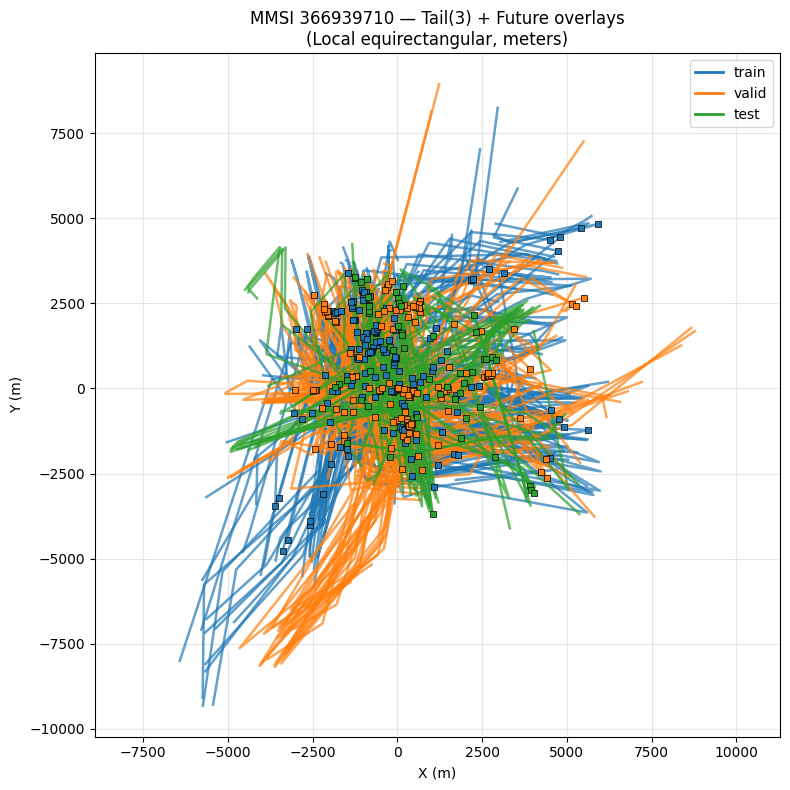

In [ ]:
#@title compare_mmsi_paths.py
import os
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Dict, List, Tuple, Optional

# =========================
# Tunable parameters
# =========================
TAIL_K = 3                 # last-k history steps (≈ 90 min) to prepend
N_TAIL = 3                 # resample tail to this many points
N_FUTURE = 6               # future steps are already 6 in your dataset
W_TAIL = 0.25              # weight of tail distance
W_FUTURE = 0.75            # weight of future distance
VERIFY_FUTURE_STEPS = True # enforce exactly 6 future steps
PLOT = True                # set False to skip plotting

# =========================
# Utilities
# =========================
def _list_sample_groups_for_mmsi(f: h5py.File, split: str, mmsi: int) -> List[Tuple[int, str]]:
    """
    Return sorted list of (anchor_timestamp, sample_id) for a given split & MMSI.
    We verify exactly 6 future steps when VERIFY_FUTURE_STEPS is True.
    """
    sg = f["splits"][split]
    sids = []
    for sid in sg.keys():
        g = sg[sid]
        if not isinstance(g, h5py.Group):
            continue
        try:
            if int(g.attrs.get("mmsi", -1)) != int(mmsi):
                continue
            y = g["features_y"][()]
            exp = int(g.attrs.get("future_steps", y.shape[0]))
            act = int(g.attrs.get("future_steps_actual", y.shape[0]))
            if VERIFY_FUTURE_STEPS and (y.shape[0] != exp or act != exp or exp != 6):
                continue
            ts = int(g.attrs.get("anchor_timestamp", 0))
            sids.append((ts, sid))
        except Exception:
            continue
    sids.sort(key=lambda t: t[0])
    return sids

def _find_common_mmsi(f: h5py.File) -> Optional[int]:
    """Pick an MMSI that exists in train, valid, and test. Prefer the one with most total samples."""
    if "splits" not in f:
        raise ValueError("Missing 'splits' group in HDF5.")
    splits_available = [s for s in ("train", "valid", "test") if s in f["splits"]]

    # Gather MMSIs per split
    mmsi_by_split = {}
    for s in splits_available:
        mm = []
        for sid in f["splits"][s].keys():
            g = f["splits"][s][sid]
            if isinstance(g, h5py.Group):
                try:
                    mm.append(int(g.attrs.get("mmsi", -1)))
                except Exception:
                    pass
        mmsi_by_split[s] = set([m for m in mm if m > 0])

    # Intersect all splits present (require train, valid, test)
    required = {"train","valid","test"}
    if not required.issubset(mmsi_by_split.keys()):
        raise RuntimeError("Not all splits exist (train/valid/test).")

    common = mmsi_by_split["train"] & mmsi_by_split["valid"] & mmsi_by_split["test"]
    if not common:
        return None

    # Rank by total samples across splits, pick the best
    counts = {}
    for m in common:
        total = 0
        for s in ("train", "valid", "test"):
            cnt = 0
            for sid in f["splits"][s].keys():
                g = f["splits"][s][sid]
                if not isinstance(g, h5py.Group):
                    continue
                if int(g.attrs.get("mmsi", -1)) == m:
                    total += 1
        counts[m] = total
    return max(counts, key=counts.get)

def _get_tail_future_latlon(g: h5py.Group, tail_k: int = TAIL_K) -> Tuple[np.ndarray, np.ndarray]:
    """
    Return (tail_latlon, future_latlon), where:
      - tail = last-k non-padded history points (lat, lon)
      - future = full future (6, 2) (lat, lon)
    """
    x = g["features_x"][()]     # (T, 9)
    y = g["features_y"][()]     # (6, 4)

    # remove padded history rows (all zeros)
    mask = np.any(x != 0.0, axis=1)
    hist = x[mask, :2]  # lat, lon
    tail = hist[-tail_k:] if tail_k > 0 and hist.shape[0] else np.empty((0, 2))
    fut = y[:, :2]      # lat, lon
    return tail, fut

def _project_latlon_to_xy(latlon: np.ndarray, lat0_deg: float) -> np.ndarray:
    """
    Local equirectangular projection to meters around reference latitude lat0_deg.
    latlon: (N,2) [lat, lon] in degrees
    """
    if latlon.size == 0:
        return latlon
    R = 6371000.0  # meters
    lat = np.radians(latlon[:, 0].astype(float))
    lon = np.radians(latlon[:, 1].astype(float))
    lat0 = np.radians(float(lat0_deg))
    x = R * (lon - lon.mean()) * np.cos(lat0)      # center longitudes to reduce drift
    y = R * (lat - lat.mean())
    return np.column_stack([x, y])

def _resample_polyline(xy: np.ndarray, n: int) -> np.ndarray:
    """
    Resample a polyline to n points using cumulative arc-length parameterization.
    If degenerate (length ~ 0), return repeated points.
    """
    if xy.shape[0] == 0:
        return np.zeros((n, 2), dtype=float)
    if xy.shape[0] == 1:
        return np.repeat(xy, n, axis=0)

    seg = np.linalg.norm(np.diff(xy, axis=0), axis=1)
    s = np.concatenate([[0.0], np.cumsum(seg)])
    L = s[-1]
    if L <= 1e-9:
        return np.repeat(xy[:1], n, axis=0)
    t = np.linspace(0, L, n)
    x = np.interp(t, s, xy[:, 0])
    y = np.interp(t, s, xy[:, 1])
    return np.column_stack([x, y])

def _discrete_frechet(P: np.ndarray, Q: np.ndarray) -> float:
    """
    Discrete Fréchet distance between polylines P and Q (Nx2 each).
    """
    n, m = P.shape[0], Q.shape[0]
    ca = np.full((n, m), -1.0, dtype=float)

    def c(i, j):
        if ca[i, j] > -0.5:
            return ca[i, j]
        d = np.linalg.norm(P[i] - Q[j])
        if i == 0 and j == 0:
            ca[i, j] = d
        elif i == 0:
            ca[i, j] = max(c(i, j - 1), d)
        elif j == 0:
            ca[i, j] = max(c(i - 1, j), d)
        else:
            ca[i, j] = max(min(c(i - 1, j), c(i - 1, j - 1), c(i, j - 1)), d)
        return ca[i, j]

    return c(n - 1, m - 1)

def _combined_distance(g_ref: h5py.Group, g_cmp: h5py.Group, lat0_deg: float,
                       tail_k: int = TAIL_K, n_tail: int = N_TAIL, n_future: int = N_FUTURE,
                       w_tail: float = W_TAIL, w_future: float = W_FUTURE) -> float:
    """
    Weighted Fréchet distance between (tail) and (future) parts.
    """
    tail_ref, fut_ref = _get_tail_future_latlon(g_ref, tail_k)
    tail_cmp, fut_cmp = _get_tail_future_latlon(g_cmp, tail_k)

    # project → resample
    d_tail = 0.0
    if tail_ref.shape[0] >= 2 and tail_cmp.shape[0] >= 2 and n_tail > 1:
        tr = _resample_polyline(_project_latlon_to_xy(tail_ref, lat0_deg), n_tail)
        tc = _resample_polyline(_project_latlon_to_xy(tail_cmp, lat0_deg), n_tail)
        d_tail = _discrete_frechet(tr, tc)

    fr = _resample_polyline(_project_latlon_to_xy(fut_ref, lat0_deg), n_future)
    fc = _resample_polyline(_project_latlon_to_xy(fut_cmp, lat0_deg), n_future)
    d_fut = _discrete_frechet(fr, fc)

    return w_tail * d_tail + w_future * d_fut

# =========================
# Main workflow
# =========================
def compare_mmsi_paths(h5_path: str,
                       mmsi_override: Optional[int] = None,
                       show_plots: bool = PLOT) -> Dict:
    """
    1) Pick an MMSI present in train/valid/test (or use override).
    2) Build per-split sample lists sorted by time.
    3) Compute pairwise tail+future Fréchet distances (meters).
    4) Print & return consistency stats; optionally plot overlays.

    Returns dict with keys: chosen_mmsi, counts, distances, stats
    """
    if not os.path.exists(h5_path):
        raise FileNotFoundError(h5_path)

    with h5py.File(h5_path, "r") as f:
        # choose MMSI
        if mmsi_override is None:
            chosen = _find_common_mmsi(f)
            if chosen is None:
                raise RuntimeError("No MMSI appears in all splits (train/valid/test).")
        else:
            chosen = int(mmsi_override)
            # sanity: ensure exists in all splits
            for s in ("train", "valid", "test"):
                if s not in f["splits"]:
                    raise RuntimeError(f"Missing split '{s}'.")
                if not _list_sample_groups_for_mmsi(f, s, chosen):
                    raise RuntimeError(f"MMSI {chosen} not found in split '{s}'.")

        # collect sample ids per split
        per_split = {}
        for s in ("train", "valid", "test"):
            pairs = _list_sample_groups_for_mmsi(f, s, chosen) # [(ts, sid), ...] sorted
            per_split[s] = [sid for _, sid in pairs]

        # compute a global reference latitude for projection (median of all points)
        all_lats = []
        for s in ("train", "valid", "test"):
            for sid in per_split[s]:
                g = f["splits"][s][sid]
                tail, fut = _get_tail_future_latlon(g, TAIL_K)
                if tail.size: all_lats.extend(tail[:, 0].tolist())
                if fut.size:  all_lats.extend(fut[:, 0].tolist())
        if not all_lats:
            raise RuntimeError("No coordinates found for selected MMSI.")
        lat0 = float(np.median(all_lats))

        # pairwise distances within each split (temporal consistency)
        distances = {"train": [], "valid": [], "test": [], "cross": []}
        for s in ("train", "valid", "test"):
            sids = per_split[s]
            for i in range(len(sids) - 1):
                g1 = f["splits"][s][sids[i]]
                g2 = f["splits"][s][sids[i + 1]]
                d = _combined_distance(g1, g2, lat0)
                distances[s].append(d)

        # cross-split distances (last of train vs first of valid; last of valid vs first of test)
        for a, b in (("train", "valid"), ("valid", "test")):
            if per_split[a] and per_split[b]:
                g1 = f["splits"][a][per_split[a][-1]]
                g2 = f["splits"][b][per_split[b][0]]
                d = _combined_distance(g1, g2, lat0)
                distances["cross"].append(((a, b), d))

        # stats
        stats = {}
        for s in ("train", "valid", "test"):
            arr = np.array(distances[s], dtype=float) if distances[s] else np.array([])
            stats[s] = {
                "pairs": int(len(arr)),
                "median_m": float(np.median(arr)) if arr.size else None,
                "mean_m":   float(np.mean(arr)) if arr.size else None,
                "max_m":    float(np.max(arr)) if arr.size else None,
            }
        stats["cross"] = [{"pair": f"{a}->{b}", "distance_m": float(d)} for (a, b), d in distances["cross"]]

        # print summary
        print(f"\nChosen MMSI: {chosen}")
        for s in ("train", "valid", "test"):
            print(f"  {s}: {len(per_split[s])} samples | pairwise comparisons: {stats[s]['pairs']}"
                  f"{'' if stats[s]['pairs']==0 else f' | median={stats[s]['median_m']:.1f} m, mean={stats[s]['mean_m']:.1f} m, max={stats[s]['max_m']:.1f} m'}")
        for item in stats["cross"]:
            print(f"  cross {item['pair']}: {item['distance_m']:.1f} m")

        # plotting (optional)
        if show_plots:
            _plot_overlays(f, per_split, chosen, lat0)

        return {
            "chosen_mmsi": chosen,
            "counts": {s: len(per_split[s]) for s in ("train","valid","test")},
            "distances": distances,
            "stats": stats,
            "lat0": lat0
        }

def _plot_overlays(f: h5py.File, per_split: Dict[str, List[str]], mmsi: int, lat0: float):
    """
    Overlay polylines (tail+future) for each split in its own color.
    """
    colors = {"train": "tab:blue", "valid": "tab:orange", "test": "tab:green"}
    plt.figure(figsize=(8, 8))
    ax = plt.gca()

    for split in ("train", "valid", "test"):
        sids = per_split[split]
        for sid in sids:
            g = f["splits"][split][sid]
            tail, fut = _get_tail_future_latlon(g, TAIL_K)
            latlon = np.vstack([tail, fut]) if tail.size else fut
            if latlon.shape[0] < 2:
                continue
            xy = _project_latlon_to_xy(latlon, lat0)
            ax.plot(xy[:, 0], xy[:, 1], color=colors[split], alpha=0.7, linewidth=1.8)
            # highlight start of future (anchor)
            if tail.size:
                ax.scatter(xy[len(tail) - 1, 0], xy[len(tail) - 1, 1],
                           color=colors[split], s=25, zorder=3, marker='s', edgecolor='k', linewidth=0.5)

    ax.set_title(f"MMSI {mmsi} — Tail({TAIL_K}) + Future overlays\n(Local equirectangular, meters)")
    ax.set_xlabel("X (m)"); ax.set_ylabel("Y (m)")
    ax.grid(True, alpha=0.3); ax.set_aspect("equal", adjustable="datalim")
    handles = [plt.Line2D([0],[0], color=colors[s], lw=2, label=s) for s in ("train","valid","test")]
    ax.legend(handles=handles, loc="best")
    plt.tight_layout()
    plt.show()

# =========================
# Example usage
# =========================
if __name__ == "__main__":
    # Path to your preprocessed HDF5
    H5_PATH = "./data/new_york_2015.h5"

    # Option 1: Auto-pick MMSI that exists in train+valid+test
    result = compare_mmsi_paths(H5_PATH, mmsi_override=None, show_plots=True)

    # Option 2: Force a particular MMSI (uncomment and set the ID)
    # result = compare_mmsi_paths(H5_PATH, mmsi_override=303589000, show_plots=True)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# !cp /content/data/new_york_2015.h5 /content/drive/MyDrive/

In [ ]:
# !mkdir -p /content/data/
# !cp /content/drive/MyDrive/new_york_2015.h5 /content/data/new_york_2015.h5

### Dataset

In [ ]:
#@title dataset loader with mmsi

"""
AIS Dataset Loader with optional MMSI filtering (self-contained)

- make_dataset(..., mmsi=None)     -> original behavior (all samples)
- make_dataset(..., mmsi=366*****) -> only samples for that MMSI
- list_mmsi_counts(...)            -> see which MMSIs have the most valid samples
- list_sample_ids_by_mmsi(...)     -> get sample_ids for a particular MMSI
"""

import h5py
import numpy as np
import tensorflow as tf
from collections import Counter
from typing import List, Tuple, Dict, Optional

HISTORY_CHANNELS = 9  # lat, lon, dlat_dt, dlon_dt, sog, cog_sin, cog_cos, hdg_sin, hdg_cos

# ------------------------- core helpers -------------------------
def _get_split_info(h5_path: str, split: str) -> Tuple[List[str], int]:
    """Get split sample IDs and future steps with proper file handling."""
    with h5py.File(h5_path, "r") as f:
        if 'splits' not in f:
            raise ValueError("HDF5 file doesn't contain 'splits' group")
        if split not in f['splits']:
            raise ValueError(f"Split '{split}' not found in HDF5 file")

        future_steps = int(f["splits"].attrs["future_steps"])
        split_group = f['splits'][split]
        sample_ids = [sid for sid in split_group.keys() if isinstance(split_group[sid], h5py.Group)]
        sample_ids = sorted(sample_ids, key=lambda x: int(x))
        return sample_ids, future_steps

def _load_and_validate_sample(h5_path: str, split: str, sample_id: str, expected_steps: int):
    """
    Load a single sample with validation. Filters out invalid samples.
    Returns (features_x, features_y) or (None, None) if invalid.
    """
    try:
        with h5py.File(h5_path, "r") as f:
            g = f["splits"][split][sample_id]
            x = g["features_x"][()]  # (T, 9)
            y = g["features_y"][()]  # (S, 4)

            # ensure correct future length and finite values
            if y.shape[0] != expected_steps:
                return None, None
            if np.any(~np.isfinite(x)) or np.any(~np.isfinite(y)):
                return None, None

            return x.astype("float32"), y.astype("float32")
    except Exception:
        return None, None

# ------------------------- MMSI utilities -------------------------
def list_mmsi_counts(h5_path: str, split: str, verify_future_steps: bool = True) -> List[Tuple[int, int]]:
    """
    Return a list of (mmsi, num_valid_samples) sorted by num_valid_samples desc.
    """
    sample_ids, future_steps = _get_split_info(h5_path, split)
    cnt = Counter()
    with h5py.File(h5_path, "r") as f:
        sg = f["splits"][split]
        for sid in sample_ids:
            g = sg[sid]
            mmsi = int(g.attrs.get("mmsi", -1))
            if verify_future_steps:
                try:
                    y = g["features_y"][()]
                    exp = int(g.attrs.get("future_steps", y.shape[0]))
                    act = int(g.attrs.get("future_steps_actual", y.shape[0]))
                    if not (y.shape[0] == future_steps == exp == act):
                        continue
                except Exception:
                    continue
            cnt[mmsi] += 1
    ranked = sorted(cnt.items(), key=lambda kv: kv[1], reverse=True)
    return ranked

def list_sample_ids_by_mmsi(h5_path: str, split: str, mmsi: int, verify_future_steps: bool = True) -> List[str]:
    """
    Return sample_ids that belong to a specific MMSI (optionally verifying future steps).
    """
    sample_ids, future_steps = _get_split_info(h5_path, split)
    out: List[str] = []
    with h5py.File(h5_path, "r") as f:
        sg = f["splits"][split]
        for sid in sample_ids:
            g = sg[sid]
            if int(g.attrs.get("mmsi", -1)) != int(mmsi):
                continue
            if verify_future_steps:
                try:
                    y = g["features_y"][()]
                    exp = int(g.attrs.get("future_steps", y.shape[0]))
                    act = int(g.attrs.get("future_steps_actual", y.shape[0]))
                    if not (y.shape[0] == future_steps == exp == act):
                        continue
                except Exception:
                    continue
            out.append(sid)
    return out

# ------------------------- tf.data generator -------------------------
def _create_data_generator(h5_path: str, split: str, sample_ids: List[str], future_steps: int, shuffle: bool = False):
    """Create a Python generator that yields valid samples."""
    if shuffle:
        rng = np.random.default_rng()
        rng.shuffle(sample_ids)
    for sample_id in sample_ids:
        x, y = _load_and_validate_sample(h5_path, split, sample_id, future_steps)
        if x is not None and y is not None:
            yield x, y

def make_dataset(h5_path: str,
                 split: str = "train",
                 batch_size: int = 64,
                 shuffle: bool = True,
                 cache: bool = False,
                 drop_remainder: Optional[bool] = None,
                 mmsi: Optional[int] = None) -> tf.data.Dataset:
    """
    Create a TensorFlow Dataset.
      - If mmsi is None (default): use all samples (original behavior).
      - If mmsi is provided: restrict to only that ship's samples.

    Returns: tf.data.Dataset yielding batches of (X, Y)
      X: [batch, T_pad, 9]
      Y: [batch, S(=future_steps), 4]
    """
    # Split info
    all_sample_ids, future_steps = _get_split_info(h5_path, split)

    # Optionally restrict to a single MMSI
    if mmsi is not None:
        sample_ids = list_sample_ids_by_mmsi(h5_path, split, mmsi, verify_future_steps=True)
        if not sample_ids:
            raise ValueError(f"No valid samples found for MMSI {mmsi} in split '{split}'.")
        print(f"[make_dataset] Using {len(sample_ids)} samples for MMSI {mmsi} (split={split})")
    else:
        sample_ids = all_sample_ids
        if not sample_ids:
            raise ValueError(f"No valid samples found for split '{split}'.")
        print(f"[make_dataset] Using {len(sample_ids)} samples in split '{split}'")

    # Default drop_remainder behavior
    if drop_remainder is None:
        drop_remainder = (split == "train")

    # tf.data pipeline
    output_signature = (
        tf.TensorSpec(shape=(None, HISTORY_CHANNELS), dtype=tf.float32),
        tf.TensorSpec(shape=(future_steps, 4), dtype=tf.float32),
    )
    ds = tf.data.Dataset.from_generator(
        lambda: _create_data_generator(h5_path, split, sample_ids.copy(), future_steps, shuffle),
        output_signature=output_signature
    )
    if cache:
        ds = ds.cache()
    if shuffle and split == "train":
        ds = ds.shuffle(min(len(sample_ids), 10_000), reshuffle_each_iteration=True)
    ds = ds.padded_batch(
        batch_size,
        padded_shapes=([None, HISTORY_CHANNELS], [future_steps, 4]),
        padding_values=(0.0, 0.0),
        drop_remainder=drop_remainder,
    )
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

# ------------------------- quick checks (unchanged behavior) -------------------------
def quick_validation(h5_path: str):
    """Quick validation across splits."""
    print("Performing quick validation...")
    with h5py.File(h5_path, "r") as f:
        future_steps = int(f["splits"].attrs["future_steps"])
        print(f"Expected future steps: {future_steps}")

    for split in ["train", "valid", "test"]:
        try:
            sample_ids, _ = _get_split_info(h5_path, split)
            print(f"Split '{split}': {len(sample_ids)} samples found")
            ok = 0
            for sid in sample_ids[:min(5, len(sample_ids))]:
                x, y = _load_and_validate_sample(h5_path, split, sid, future_steps)
                if x is not None and y is not None:
                    ok += 1
                    print(f"  {sid}: X{tuple(x.shape)} Y{tuple(y.shape)}")
            print(f"  ✓ {ok}/{min(5, len(sample_ids))} valid")
        except Exception as e:
            print(f"  Error with split '{split}': {e}")

def count_valid_samples(h5_path: str):
    """Count valid samples in each split."""
    print("Counting valid samples...")
    with h5py.File(h5_path, "r") as f:
        future_steps = int(f["splits"].attrs["future_steps"])
    for split in ["train", "valid", "test"]:
        try:
            sample_ids, _ = _get_split_info(h5_path, split)
            valid = 0
            for sid in sample_ids:
                x, y = _load_and_validate_sample(h5_path, split, sid, future_steps)
                if x is not None and y is not None:
                    valid += 1
            total = len(sample_ids)
            pct = 100.0 * valid / total if total else 0.0
            print(f"Split '{split}': {valid}/{total} valid ({pct:.1f}%)")
        except Exception as e:
            print(f"  Error with split '{split}': {e}")

def get_dataset_info(h5_path: str) -> dict:
    """Basic dataset info."""
    info = {}
    with h5py.File(h5_path, "r") as f:
        info['future_steps'] = int(f["splits"].attrs["future_steps"])
        info['history_channels'] = HISTORY_CHANNELS
        info['future_channels'] = 4
        for split in ["train", "valid", "test"]:
            if split in f['splits']:
                sample_ids, _ = _get_split_info(h5_path, split)
                info[f'{split}_samples'] = len(sample_ids)
    return info

def validate_pipeline_compatibility(h5_path: str) -> bool:
    """Validate basic expectations."""
    try:
        info = get_dataset_info(h5_path)
        required_keys = ['future_steps', 'train_samples', 'valid_samples']
        if not all(k in info for k in required_keys):
            print(" Missing required dataset attributes")
            return False
        if info['future_steps'] != 6:
            print(f"⚠ Expected 6 future steps, got {info['future_steps']}")
        if info['history_channels'] != 9:
            print(f"⚠ Expected 9 history channels, got {info['history_channels']}")
        if info['future_channels'] != 4:
            print(f"⚠ Expected 4 future channels, got {info['future_channels']}")
        print(" Dataset is compatible")
        for k, v in info.items():
            print(f"   - {k}: {v}")
        return True
    except Exception as e:
        print(f" Validation failed: {e}")
        return False

# ------------------------- self-contained usage -------------------------
if __name__ == "__main__":
    h5_path = "./data/new_york_2015.h5"

    # Basic checks
    validate_pipeline_compatibility(h5_path)
    quick_validation(h5_path)
    count_valid_samples(h5_path)

    # Find the best MMSIs in TEST split (by number of valid samples)
    print("\nTop MMSIs in test split:")
    top = list_mmsi_counts(h5_path, split="test", verify_future_steps=True)[:10]
    for m, c in top:
        print(f"  MMSI {m}: {c} samples")

    # If any MMSI exists, make a dataset restricted to that single MMSI
    if top:
        best_mmsi = top[0][0]
        print(f"\nCreating dataset for MMSI {best_mmsi} (test split)...")
        ds_test_mmsi = make_dataset(h5_path, split="test", batch_size=32, shuffle=False, mmsi=best_mmsi)
        xb, yb = next(iter(ds_test_mmsi))
        print(f"MMSI {best_mmsi} batch shapes -> X: {xb.shape}, Y: {yb.shape}")


 Dataset is compatible
   - future_steps: 6
   - history_channels: 9
   - future_channels: 4
   - train_samples: 18956
   - valid_samples: 6372
   - test_samples: 51
Performing quick validation...
Expected future steps: 6
Split 'train': 18956 samples found
  0: X(11, 9) Y(6, 4)
  1: X(12, 9) Y(6, 4)
  2: X(13, 9) Y(6, 4)
  3: X(14, 9) Y(6, 4)
  4: X(6, 9) Y(6, 4)
  ✓ 5/5 valid
Split 'valid': 6372 samples found
  0: X(6, 9) Y(6, 4)
  1: X(6, 9) Y(6, 4)
  2: X(7, 9) Y(6, 4)
  3: X(11, 9) Y(6, 4)
  4: X(12, 9) Y(6, 4)
  ✓ 5/5 valid
Split 'test': 51 samples found
  62: X(9, 9) Y(6, 4)
  63: X(10, 9) Y(6, 4)
  64: X(11, 9) Y(6, 4)
  65: X(12, 9) Y(6, 4)
  66: X(13, 9) Y(6, 4)
  ✓ 5/5 valid
Counting valid samples...
Split 'train': 18956/18956 valid (100.0%)
Split 'valid': 6372/6372 valid (100.0%)
Split 'test': 51/51 valid (100.0%)

Top MMSIs in test split:
  MMSI 366939710: 51 samples

Creating dataset for MMSI 366939710 (test split)...
[make_dataset] Using 51 samples for MMSI 366939710 (spl

### Data Selection

In [ ]:
# @title Maritime Trajectory Explorer + In-Place TEST Filter by MMSI
import os
import random
from functools import lru_cache
from datetime import datetime, timezone

import h5py
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import gradio as gr

# ======================
# Paths / Defaults
# ======================
SRC_H5 = "./data/new_york_2015.h5"

# ======================
# Constants / Parameters
# ======================
HISTORY_CHANNELS = 9   # lat, lon, dlat/dt, dlon/dt, sog, cog_sin, cog_cos, hdg_sin, hdg_cos
FUTURE_CHANNELS  = 4   # lat, lon, dlat/dt, dlon/dt
FUTURE_STEPS     = 6   # 3 hours @ 30min intervals
SPEED_THRESHOLD  = 35  # knots (filter invalid samples)
TARGET_ACCURACY  = 10  # knots (visual guide only)

# ======================
# Helpers & Data Access
# ======================
def _apply_zero_formatter(ax: plt.Axes) -> None:
    """Format axes so numbers extremely close to zero show exactly 0.0000."""
    fmt = FuncFormatter(lambda x, pos: f"{0.0:.4f}" if abs(x) < 5e-8 else f"{x:.4f}")
    ax.xaxis.set_major_formatter(fmt)
    ax.yaxis.set_major_formatter(fmt)

def _non_padded_mask(history: np.ndarray) -> np.ndarray:
    """Rows that are not all zeros across feature channels."""
    return np.any(history != 0.0, axis=1)

def _list_sample_ids(h5_path: str, split: str):
    """List sample ids for a split (sorted for reproducibility)."""
    if not os.path.exists(h5_path):
        return []
    with h5py.File(h5_path, "r") as f:
        if "splits" not in f or split not in f["splits"]:
            return []
        keys = [k for k in f["splits"][split].keys() if isinstance(f["splits"][split][k], h5py.Group)]
    # Try numeric sort if ids are integers, else lexicographic
    try:
        return sorted(keys, key=lambda k: int(k))
    except Exception:
        return sorted(keys)

@lru_cache(maxsize=128)
def _get_sample_cached(h5_path: str, split: str, sample_id: str):
    return _get_sample(h5_path, split, sample_id)

def _get_sample(h5_path: str, split: str, sample_id: str):
    with h5py.File(h5_path, "r") as f:
        g = f["splits"][split][sample_id]
        x = g["features_x"][()]  # (T, 9)
        y = g["features_y"][()]  # (S, 4)
        return x, y, dict(g.attrs)

def load_and_validate_sample(h5_path: str, split: str, sample_id: str):
    """Load and validate sample."""
    try:
        x, y, attrs = _get_sample(h5_path, split, sample_id)

        # Basic validation
        valid_mask = _non_padded_mask(x)
        if np.sum(valid_mask) < 6:  # Need minimum history (3h @ 30 min)
            return None, None, None

        # Speed constraints (SOG at index 4)
        if x.shape[1] > 4:
            speeds = x[valid_mask, 4]
            if np.max(speeds) > SPEED_THRESHOLD:
                return None, None, None

        # Future steps sanity
        if y.shape[0] != FUTURE_STEPS:
            return None, None, None

        return x, y, attrs
    except Exception:
        return None, None, None

def _get_sample_with_stats(h5_path: str, split: str, sample_id: str):
    x, y, attrs = load_and_validate_sample(h5_path, split, sample_id)
    if x is None:
        return None, None, {"error": "Invalid sample", "sample_id": sample_id}

    valid_mask = _non_padded_mask(x)
    hist_used = x[valid_mask] if np.any(valid_mask) else x

    # Merge quick stats
    attrs = dict(attrs)
    attrs.update({
        "sample_id": sample_id,
        "history_length": int(len(hist_used)),
        "future_steps": int(len(y)),
        "history_duration_hours": float(len(hist_used) * 0.5),  # 30 min
        "prediction_duration_hours": float(len(y) * 0.5),
        "mmsi": attrs.get("mmsi", "Unknown"),
        "track_id": attrs.get("track", "Unknown"),
    })

    if hist_used.shape[1] > 4 and len(hist_used) > 0:
        speeds = hist_used[:, 4]
        attrs.update({
            "avg_speed_knots": float(np.mean(speeds)),
            "max_speed_knots": float(np.max(speeds)),
            "min_speed_knots": float(np.min(speeds)),
            "speed_valid": bool(float(np.max(speeds)) <= SPEED_THRESHOLD),
        })

    return x, y, attrs

# ===============
# Visualization
# ===============
def _render_plot(sample):
    x, y, attrs = sample
    if x is None or ("error" in attrs):
        fig, ax = plt.subplots(figsize=(12, 5))
        ax.text(
            0.5, 0.5,
            f"Invalid Sample: {attrs.get('sample_id', 'Unknown')}",
            ha='center', va='center', transform=ax.transAxes
        )
        ax.axis('off')
        plt.close(fig)
        return fig

    valid_mask = _non_padded_mask(x)
    hist_used = x[valid_mask] if np.any(valid_mask) else x

    lat_hist, lon_hist = hist_used[:, 0], hist_used[:, 1]
    dlat_dt_hist, dlon_dt_hist = hist_used[:, 2], hist_used[:, 3]
    sog_hist = hist_used[:, 4] if hist_used.shape[1] > 4 else None

    if hist_used.shape[1] > 6:
        cog_sin = hist_used[:, 5]
        cog_cos = hist_used[:, 6]
    else:
        cog_sin, cog_cos = None, None

    lat_future, lon_future = y[:, 0], y[:, 1]
    dlat_dt_future, dlon_dt_future = y[:, 2], y[:, 3]

    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 10))

    # Main trajectory
    ax1.plot(lon_hist, lat_hist, 'o-', lw=2, color="tab:blue", label="History (3h)", markersize=4)
    if len(lat_hist) > 0:
        ax1.scatter(lon_hist[-1], lat_hist[-1], color="red", s=50, zorder=3,
                    label="Prediction Start", marker='s')

    if len(lat_future) > 0:
        colors = plt.cm.plasma(np.linspace(0, 1, len(lat_future)))
        for i, (lx, ly, c) in enumerate(zip(lon_future, lat_future, colors), start=1):
            ax1.scatter(lx, ly, color=c, s=30, zorder=3, edgecolor='white', linewidth=1)
            ax1.text(lx, ly, f"{i*30}m", fontsize=6, color="white", ha='center', va='center', weight='bold')
        ax1.plot(lon_future, lat_future, '--', lw=2, color="tab:orange", alpha=0.7, label="Future (3h)")

    ax1.set_xlabel("Longitude")
    ax1.set_ylabel("Latitude")
    ax1.axis("equal")
    _apply_zero_formatter(ax1)
    ax1.grid(True, alpha=0.3)
    ax1.legend(loc="best", fontsize=8)
    ax1.set_title("Trajectory Prediction (30min intervals)")

    # Speed profile
    if sog_hist is not None:
        time_steps = np.arange(len(sog_hist)) * 30
        ax2.plot(time_steps, sog_hist, 'o-', color="tab:green", label="Historical Speed")
        ax2.axhline(y=TARGET_ACCURACY, color='red', linestyle='--', alpha=0.7,
                    label=f'Target Accuracy: {TARGET_ACCURACY} knots')
        ax2.axhline(y=SPEED_THRESHOLD, color='orange', linestyle='--', alpha=0.7,
                    label=f'Speed Filter: {SPEED_THRESHOLD} knots')
        ax2.set_xlabel("Time (minutes)")
        ax2.set_ylabel("Speed (knots)")
        ax2.grid(True, alpha=0.3)
        ax2.legend()
        ax2.set_title("Speed Over Ground Profile")
    else:
        ax2.text(0.5, 0.5, "Speed data\nnot available",
                 ha='center', va='center', transform=ax2.transAxes)
        ax2.set_title("Speed Profile (N/A)")
        ax2.axis('off')

    # COG (reconstructed from sin/cos)
    if (cog_sin is not None) and (cog_cos is not None):
        cog_degrees = (np.degrees(np.arctan2(cog_sin, cog_cos)) + 360.0) % 360.0
        time_steps = np.arange(len(cog_degrees)) * 30
        ax3.plot(time_steps, cog_degrees, 'o-', color="tab:purple", label="COG")
        ax3.set_xlabel("Time (minutes)")
        ax3.set_ylabel("Course Over Ground (degrees)")
        ax3.set_ylim(0, 360)
        ax3.grid(True, alpha=0.3)
        ax3.legend()
        ax3.set_title("Course Over Ground")
    else:
        ax3.text(0.5, 0.5, "COG data\nnot available",
                 ha='center', va='center', transform=ax3.transAxes)
        ax3.set_title("Course Over Ground (N/A)")
        ax3.axis('off')

    # Velocity derivatives
    if len(dlat_dt_hist) > 0:
        time_steps = np.arange(len(dlat_dt_hist)) * 30
        ax4.plot(time_steps, dlat_dt_hist, 'o-', color="tab:cyan", label="dlat/dt", markersize=3)
        ax4.plot(time_steps, dlon_dt_hist, 'o-', color="tab:pink", label="dlon/dt", markersize=3)

        if len(dlat_dt_future) > 0:
            future_time_steps = np.arange(len(dlat_dt_future)) * 30 + len(dlat_dt_hist) * 30
            ax4.plot(future_time_steps, dlat_dt_future, 's--', color="tab:cyan", alpha=0.7,
                     label="Future dlat/dt", markersize=4)
            ax4.plot(future_time_steps, dlon_dt_future, 's--', color="tab:pink", alpha=0.7,
                     label="Future dlon/dt", markersize=4)

        ax4.axvline(x=len(dlat_dt_hist) * 30, color='red', linestyle=':', alpha=0.7,
                    label='Prediction Boundary')
        ax4.set_xlabel("Time (minutes)")
        ax4.set_ylabel("Velocity Derivatives")
        ax4.grid(True, alpha=0.3)
        ax4.legend(fontsize=7)
        ax4.set_title("Velocity Components (lat/lon derivatives)")
    else:
        ax4.text(0.5, 0.5, "Derivative data\nnot available",
                 ha='center', va='center', transform=ax4.transAxes)
        ax4.set_title("Velocity Components (N/A)")
        ax4.axis('off')

    plt.tight_layout()
    plt.close(fig)
    return fig

# ==========================
# In-place TEST filter by MMSI
# ==========================
def _filter_test_inplace_by_mmsi(h5_path: str, mmsi: int, keep_backup_group: bool = True) -> str:
    """
    In-place TEST filtering:
      - Keeps /splits/train and /splits/valid unchanged
      - Replaces /splits/test with only samples matching MMSI
      - Optionally keeps a backup of the original /splits/test inside the same file
    """
    if not os.path.exists(h5_path):
        return f"Source not found: {h5_path}"

    with h5py.File(h5_path, "a") as f:
        if "splits" not in f:
            return "No '/splits' group in file."
        splits = f["splits"]

        if "test" not in splits:
            return "No '/splits/test' group found."

        # 1) Move existing test to a backup name
        if keep_backup_group:
            bak_name = f"test_backup_{datetime.now(timezone.utc).strftime('%Y%m%dT%H%M%SZ')}"
        else:
            bak_name = "test_tmp_old"
            if bak_name in splits:
                del splits[bak_name]  # clean old temp if present

        splits.move("test", bak_name)
        src_test = splits[bak_name]

        # 2) Create a fresh /splits/test and copy attrs
        dst_test = splits.create_group("test")
        for k, v in src_test.attrs.items():
            dst_test.attrs[k] = v
        dst_test.attrs["split"] = "test"

        # 3) Copy ONLY matching MMSI samples into new /splits/test
        num = 0
        min_ts, max_ts = None, None
        next_id_guess = 0

        for sid in src_test.keys():
            g = src_test[sid]
            if not isinstance(g, h5py.Group):
                continue
            try:
                if int(g.attrs.get("mmsi", -1)) != int(mmsi):
                    continue

                # future steps must be 6 to match pipeline assumptions
                y = g["features_y"][()]
                exp = int(g.attrs.get("future_steps", y.shape[0]))
                act = int(g.attrs.get("future_steps_actual", y.shape[0]))
                if not (y.shape[0] == 6 and exp == 6 and act == 6):
                    continue

                # Copy the group inside the same file
                f.copy(g, dst_test, name=sid)
                num += 1

                ts = int(g.attrs.get("anchor_timestamp", 0))
                min_ts = ts if (min_ts is None or ts < min_ts) else min_ts
                max_ts = ts if (max_ts is None or ts > max_ts) else max_ts

                try:
                    sid_int = int(sid)
                    if sid_int >= next_id_guess:
                        next_id_guess = sid_int + 1
                except Exception:
                    pass
            except Exception:
                continue

        # 4) Update attrs for new test group
        dst_test.attrs["num_samples"] = num
        if min_ts is not None:
            dst_test.attrs["min_timestamp"] = min_ts
        if max_ts is not None:
            dst_test.attrs["max_timestamp"] = max_ts
        dst_test.attrs["next_id"] = next_id_guess
        dst_test.attrs["updated_at"] = datetime.now(timezone.utc).isoformat()

        # 5) If no backup desired, remove the temp old group
        if not keep_backup_group and bak_name in splits:
            del splits[bak_name]

    return (
        f"In-place TEST filter complete for MMSI={int(mmsi)}.\n"
        f"Kept {num} samples in /splits/test. "
        + (f"Original test saved as /splits/{bak_name}." if keep_backup_group else "Backup not kept.")
    )

# ==========================
# Navigation / Interaction
# ==========================
def _get_first_valid_plot(split, ids):
    """Return the first valid sample's plot/attrs/index for a split (or placeholders)."""
    if not ids:
        return None, {"info": f"No samples in '{split}'"}, 0

    # try up to len(ids) samples to find a valid one
    for i in range(len(ids)):
        sid = ids[i]
        sample = _get_sample_with_stats(SRC_H5, split, sid)
        if sample[0] is not None:
            fig = _render_plot(sample)
            return fig, sample[2], i
    # if none are valid
    return None, {"info": f"No valid samples found in '{split}'"}, 0

def change_split(new_split):
    """UI callback: change split and refresh IDs + first sample."""
    ids = _list_sample_ids(SRC_H5, new_split)
    fig, attrs, idx = _get_first_valid_plot(new_split, ids)
    return ids, fig, attrs, idx, f"Split changed to '{new_split}'. {len(ids)} samples detected."

def update_sample(direction, current_index, ids, split):
    """Next/Prev navigation with auto-skip of invalid samples."""
    if not ids:
        return None, {}, 0
    if direction == "next":
        current_index = (current_index + 1) % len(ids)
    elif direction == "prev":
        current_index = (current_index - 1) % len(ids)

    # try current and keep advancing until valid or we've tried all
    tried = 0
    while tried < len(ids):
        sid = ids[current_index]
        sample = _get_sample_with_stats(SRC_H5, split, sid)
        if sample[0] is not None:
            fig = _render_plot(sample)
            return fig, sample[2], current_index
        # otherwise try next
        current_index = (current_index + 1) % len(ids)
        tried += 1

    return None, {"info": "No valid samples to display"}, 0

def random_sample(ids, split):
    """Jump to a random valid sample."""
    if not ids:
        return None, {}, 0, "No samples."
    order = list(range(len(ids)))
    random.shuffle(order)
    for idx in order:
        sid = ids[idx]
        sample = _get_sample_with_stats(SRC_H5, split, sid)
        if sample[0] is not None:
            fig = _render_plot(sample)
            return fig, sample[2], idx, f"Random sample: {sid}"
    return None, {"info": "No valid samples"}, 0, "No valid samples."

def jump_to_sample(sample_id_input, ids, split):
    """Jump to a specific sample ID."""
    if sample_id_input in ids:
        current_index = ids.index(sample_id_input)
        sample = _get_sample_with_stats(SRC_H5, split, sample_id_input)
        if sample[0] is None:
            return None, sample[2], current_index, f"Invalid sample: {sample_id_input}"
        fig = _render_plot(sample)
        return fig, sample[2], current_index, f"Jumped to sample {sample_id_input}"
    else:
        return None, {}, 0, f"Sample ID {sample_id_input} not found"

def filter_test_inplace(mmsi_str: str, keep_backup: bool, split, ids):
    """Apply in-place filter to TEST and refresh UI if user is on TEST."""
    try:
        mmsi_val = int(mmsi_str.strip())
    except Exception:
        return ids, None, {"error": "Enter a valid MMSI (integer)."}, 0, "Enter a valid MMSI."

    status = _filter_test_inplace_by_mmsi(SRC_H5, mmsi_val, keep_backup_group=keep_backup)

    # If user is currently viewing TEST, refresh the list and figure
    if split == "test":
        new_ids = _list_sample_ids(SRC_H5, "test")
        fig, attrs, idx = _get_first_valid_plot("test", new_ids)
        return new_ids, fig, attrs, idx, status

    # If user is on train/valid, do not change their list/plot; just return status
    return ids, None, {"info": "TEST updated; switch to TEST to view."}, 0, status

# ===============
# Build Gradio UI
# ===============
with gr.Blocks(title="Maritime Trajectory Explorer (In-Place TEST Filter)") as demo:
    gr.Markdown("# Maritime Trajectory Prediction — Explorer & In-Place TEST Filter")
    gr.Markdown("""
- **Model Config**: 3-hour history → 6-step future (30-min intervals)
- **Features**: 9 history channels, 4 future channels
- **Speed Filter**: < 35 knots (for sample validity checks)
""")

    # State: current split, ids for that split, current index
    split_state = gr.State("train")
    ids_state   = gr.State(_list_sample_ids(SRC_H5, "train"))
    idx_state   = gr.State(0)

    with gr.Row():
        split_dd = gr.Dropdown(choices=["train", "valid", "test"], value="train", label="Split")

    with gr.Row():
        with gr.Column(scale=3):
            plot_output = gr.Plot(label="Trajectory")
        with gr.Column(scale=1):
            attrs_output = gr.JSON(label="Sample Statistics & Quality")

    with gr.Row():
        prev_button   = gr.Button("◀ Previous", variant="secondary")
        next_button   = gr.Button("Next ▶", variant="secondary")
        random_button = gr.Button(" Random",    variant="secondary")

    with gr.Row():
        sample_id_input = gr.Textbox(
            label="Jump to Sample ID",
            placeholder="Enter sample ID (e.g., 42)",
            scale=3
        )
        jump_button = gr.Button("Jump", variant="primary", scale=1)

    gr.Markdown("## In-Place TEST Filtering by MMSI (same HDF5 file)")
    with gr.Row():
        mmsi_input = gr.Textbox(label="MMSI to keep in TEST", placeholder="e.g., 303589000", scale=2)
        keep_backup_chk = gr.Checkbox(value=True, label="Keep a backup of original TEST")
        filter_inplace_btn = gr.Button("Filter TEST in-place", variant="primary")

    status_output = gr.Textbox(label="Status", interactive=False, lines=6)

    # --- Event handlers ---

    # Split change -> refresh ids + first valid sample
    split_dd.change(
        fn=lambda new_split: change_split(new_split),
        inputs=[split_dd],
        outputs=[ids_state, plot_output, attrs_output, idx_state, status_output]
    ).then(
        fn=lambda new_split: new_split,
        inputs=[split_dd],
        outputs=[split_state]
    )

    # Prev / Next
    prev_button.click(
        fn=lambda idx, ids, split: update_sample("prev", idx, ids, split),
        inputs=[idx_state, ids_state, split_state],
        outputs=[plot_output, attrs_output, idx_state]
    )
    next_button.click(
        fn=lambda idx, ids, split: update_sample("next", idx, ids, split),
        inputs=[idx_state, ids_state, split_state],
        outputs=[plot_output, attrs_output, idx_state]
    )

    # Random
    random_button.click(
        fn=lambda ids, split: random_sample(ids, split),
        inputs=[ids_state, split_state],
        outputs=[plot_output, attrs_output, idx_state, status_output]
    )

    # Jump to ID
    jump_button.click(
        fn=lambda sid, ids, split: jump_to_sample(sid, ids, split),
        inputs=[sample_id_input, ids_state, split_state],
        outputs=[plot_output, attrs_output, idx_state, status_output]
    )

    # In-place TEST filter
    filter_inplace_btn.click(
        fn=lambda mmsi_s, keep_b, split, ids: filter_test_inplace(mmsi_s, keep_b, split, ids),
        inputs=[mmsi_input, keep_backup_chk, split_state, ids_state],
        outputs=[ids_state, plot_output, attrs_output, idx_state, status_output]
    )

    # Initialize view with the first valid TRAIN sample
    def _init():
        ids = _list_sample_ids(SRC_H5, "train")
        fig, attrs, idx = _get_first_valid_plot("train", ids)
        return "train", ids, idx, fig, attrs, f"Loaded TRAIN with {len(ids)} samples."

    demo.load(
        fn=_init,
        inputs=[],
        outputs=[split_state, ids_state, idx_state, plot_output, attrs_output, status_output]
    )

if __name__ == "__main__":
    demo.launch(show_error=True)


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://a32621d2200f15d677.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
# @title dataset selection for trainer,splt and test
import h5py
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import gradio as gr
import os
import random
from functools import lru_cache

# ======================
# Constants / Parameters
# ======================
HISTORY_CHANNELS = 9   # lat, lon, dlat/dt, dlon/dt, sog, cog_sin, cog_cos, hdg_sin, hdg_cos
FUTURE_CHANNELS = 4    # lat, lon, dlat/dt, dlon/dt
FUTURE_STEPS = 6       # 3 hours @ 30min intervals
SPEED_THRESHOLD = 35   # knots
TARGET_ACCURACY = 10   # knots (goal: < 10)

# ======================
# Helpers & Data Access
# ======================
def _apply_zero_formatter(ax: plt.Axes) -> None:
    """Format axes so numbers extremely close to zero show exactly 0.0000."""
    fmt = FuncFormatter(lambda x, pos: f"{0.0:.4f}" if abs(x) < 5e-8 else f"{x:.4f}")
    ax.xaxis.set_major_formatter(fmt)
    ax.yaxis.set_major_formatter(fmt)

def _non_padded_mask(history: np.ndarray) -> np.ndarray:
    """Rows that are not all zeros across feature channels."""
    return np.any(history != 0.0, axis=1)

def get_dataset_info(h5_path: str):
    """Get dataset metadata - matches your build_models.py approach."""
    with h5py.File(h5_path, "r") as f:
        return {
            "history_channels": f.attrs.get("history_channels", HISTORY_CHANNELS),
            "future_channels": f.attrs.get("future_channels", FUTURE_CHANNELS),
            "future_steps": f.attrs.get("future_steps", FUTURE_STEPS),
        }

def haversine_distance(lat1, lon1, lat2, lon2):
    """Calculate Haversine distance in nautical miles (matching your metric.py)."""
    R = 3440.065  # Earth's radius in nautical miles
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2.0) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2.0) ** 2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c

def _list_sample_ids(h5_path: str, split: str):
    """List sample ids for a split (sorted for reproducibility)."""
    with h5py.File(h5_path, "r") as f:
        keys = list(f["splits"][split].keys())
    # Try numeric sort if ids are pure integers, else lexicographic
    try:
        return sorted(keys, key=lambda k: int(k))
    except Exception:
        return sorted(keys)

@lru_cache(maxsize=50)  # Cache last 50 samples
def _get_sample_cached(h5_path: str, split: str, sample_id: str):
    return _get_sample(h5_path, split, sample_id)

def _get_sample(h5_path: str, split: str, sample_id: str):
    with h5py.File(h5_path, "r") as f:
        g = f["splits"][split][sample_id]
        x = g["features_x"][()]  # shape (T, 9), float32
        y = g["features_y"][()]  # shape (S, 4), float32
        return x, y, dict(g.attrs)

def load_and_validate_sample(h5_path: str, split: str, sample_id: str):
    """Load and validate sample - matches your vis.py approach."""
    try:
        x, y, attrs = _get_sample(h5_path, split, sample_id)

        # Validate trajectory quality
        valid_mask = _non_padded_mask(x)
        if np.sum(valid_mask) < 6:  # Need minimum history (3h @ 30 min)
            return None, None, None

        # Check speed constraints (SOG at index 4)
        if x.shape[1] > 4:
            speeds = x[valid_mask, 4]
            if np.max(speeds) > SPEED_THRESHOLD:
                return None, None, None

        return x, y, attrs
    except Exception:
        return None, None, None

def _get_sample_with_stats(h5_path: str, split: str, sample_id: str):
    # Use validated loading
    x, y, attrs = load_and_validate_sample(h5_path, split, sample_id)
    if x is None:
        return None, None, {"error": "Invalid sample", "sample_id": sample_id}

    # Calculate trajectory prediction metrics
    valid_mask = _non_padded_mask(x)
    hist_used = x[valid_mask] if np.any(valid_mask) else x

    stats = {
        "sample_id": sample_id,
        "history_length": int(len(hist_used)),
        "future_steps": int(len(y)),
        "history_duration_hours": float(len(hist_used) * 0.5),  # 30min intervals
        "prediction_duration_hours": float(len(y) * 0.5),
        "mmsi": attrs.get("mmsi", "Unknown"),
        "track_id": attrs.get("track", "Unknown"),
    }

    if len(hist_used) > 0:
        # Speed analysis (SOG at index 4)
        if hist_used.shape[1] > 4:
            speeds = hist_used[:, 4]  # SOG in knots
            stats.update({
                "avg_speed_knots": float(np.mean(speeds)),
                "max_speed_knots": float(np.max(speeds)),
                "min_speed_knots": float(np.min(speeds)),
                "speed_valid": bool(float(np.max(speeds)) <= SPEED_THRESHOLD),
            })

        # Calculate trajectory distances in nautical miles
        if len(hist_used) > 1:
            hist_coords = hist_used[:, :2]  # lat, lon
            hist_distances = []
            for i in range(1, len(hist_coords)):
                dist = haversine_distance(
                    hist_coords[i - 1, 0], hist_coords[i - 1, 1],
                    hist_coords[i, 0], hist_coords[i, 1]
                )
                hist_distances.append(dist)
            stats["total_distance_nm"] = float(np.sum(hist_distances))
            stats["avg_distance_per_step_nm"] = float(np.mean(hist_distances))

        # Future trajectory analysis
        if len(y) > 1:
            future_coords = y[:, :2]  # lat, lon
            future_distances = []
            for i in range(1, len(future_coords)):
                dist = haversine_distance(
                    future_coords[i - 1, 0], future_coords[i - 1, 1],
                    future_coords[i, 0], future_coords[i, 1]
                )
                future_distances.append(dist)
            stats["future_total_distance_nm"] = float(np.sum(future_distances))
            stats["future_avg_distance_per_step_nm"] = float(np.mean(future_distances))

    # Merge with original attributes
    attrs.update(stats)
    return x, y, attrs

# ===============
# Visualization
# ===============
def _render_plot(sample):
    x, y, attrs = sample
    if x is None or ("error" in attrs):
        fig, ax = plt.subplots(figsize=(12, 5))
        ax.text(
            0.5, 0.5,
            f"Invalid Sample: {attrs.get('sample_id', 'Unknown')}",
            ha='center', va='center', transform=ax.transAxes
        )
        ax.axis('off')
        plt.close(fig)
        return fig

    valid_mask = _non_padded_mask(x)
    hist_used = x[valid_mask] if np.any(valid_mask) else x

    # Extract features according to your model specification
    lat_hist, lon_hist = hist_used[:, 0], hist_used[:, 1]
    dlat_dt_hist, dlon_dt_hist = hist_used[:, 2], hist_used[:, 3]
    sog_hist = hist_used[:, 4] if hist_used.shape[1] > 4 else None  # Speed over ground

    # COG sin/cos (safe extraction)
    if hist_used.shape[1] > 6:
        cog_sin = hist_used[:, 5]
        cog_cos = hist_used[:, 6]
    else:
        cog_sin, cog_cos = None, None

    lat_future, lon_future = y[:, 0], y[:, 1]
    dlat_dt_future, dlon_dt_future = y[:, 2], y[:, 3]

    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 10))

    # Main trajectory plot
    ax1.plot(lon_hist, lat_hist, 'o-', lw=2, color="tab:blue", label="History (3h)", markersize=4)
    if len(lat_hist) > 0:
        ax1.scatter(lon_hist[-1], lat_hist[-1], color="red", s=50, zorder=3,
                    label="Prediction Start", marker='s')

    # Color-code future points by 30-min intervals
    if len(lat_future) > 0:
        colors = plt.cm.plasma(np.linspace(0, 1, len(lat_future)))
        for i, (lx, ly, c) in enumerate(zip(lon_future, lat_future, colors), start=1):
            ax1.scatter(lx, ly, color=c, s=30, zorder=3, edgecolor='white', linewidth=1)
            ax1.text(lx, ly, f"{i*30}m", fontsize=6, color="white", ha='center', va='center', weight='bold')
        ax1.plot(lon_future, lat_future, '--', lw=2, color="tab:orange", alpha=0.7, label="Future (3h)")

    ax1.set_xlabel("Longitude")
    ax1.set_ylabel("Latitude")
    ax1.axis("equal")
    _apply_zero_formatter(ax1)
    ax1.grid(True, alpha=0.3)
    ax1.legend(loc="best", fontsize=8)
    ax1.set_title("Trajectory Prediction (30min intervals)")

    # Speed profile
    if sog_hist is not None:
        time_steps = np.arange(len(sog_hist)) * 30  # 30-minute intervals
        ax2.plot(time_steps, sog_hist, 'o-', color="tab:green", label="Historical Speed")
        ax2.axhline(y=TARGET_ACCURACY, color='red', linestyle='--', alpha=0.7,
                    label=f'Target Accuracy: {TARGET_ACCURACY} knots')
        ax2.axhline(y=SPEED_THRESHOLD, color='orange', linestyle='--', alpha=0.7,
                    label=f'Speed Filter: {SPEED_THRESHOLD} knots')
        ax2.set_xlabel("Time (minutes)")
        ax2.set_ylabel("Speed (knots)")
        ax2.grid(True, alpha=0.3)
        ax2.legend()
        ax2.set_title("Speed Over Ground Profile")
    else:
        ax2.text(0.5, 0.5, "Speed data\nnot available",
                 ha='center', va='center', transform=ax2.transAxes)
        ax2.set_title("Speed Profile (N/A)")
        ax2.axis('off')

    # Course over ground (if available)
    if (cog_sin is not None) and (cog_cos is not None):
        # Convert sin/cos back to degrees
        cog_degrees = (np.degrees(np.arctan2(cog_sin, cog_cos)) + 360.0) % 360.0
        time_steps = np.arange(len(cog_degrees)) * 30
        ax3.plot(time_steps, cog_degrees, 'o-', color="tab:purple", label="COG")
        ax3.set_xlabel("Time (minutes)")
        ax3.set_ylabel("Course Over Ground (degrees)")
        ax3.set_ylim(0, 360)
        ax3.grid(True, alpha=0.3)
        ax3.legend()
        ax3.set_title("Course Over Ground")
    else:
        ax3.text(0.5, 0.5, "COG data\nnot available",
                 ha='center', va='center', transform=ax3.transAxes)
        ax3.set_title("Course Over Ground (N/A)")
        ax3.axis('off')

    # Velocity derivatives
    if len(dlat_dt_hist) > 0:
        time_steps = np.arange(len(dlat_dt_hist)) * 30
        ax4.plot(time_steps, dlat_dt_hist, 'o-', color="tab:cyan", label="dlat/dt", markersize=3)
        ax4.plot(time_steps, dlon_dt_hist, 'o-', color="tab:pink", label="dlon/dt", markersize=3)

        # Show future derivatives as predictions
        if len(dlat_dt_future) > 0:
            future_time_steps = np.arange(len(dlat_dt_future)) * 30 + len(dlat_dt_hist) * 30
            ax4.plot(future_time_steps, dlat_dt_future, 's--', color="tab:cyan", alpha=0.7,
                     label="Future dlat/dt", markersize=4)
            ax4.plot(future_time_steps, dlon_dt_future, 's--', color="tab:pink", alpha=0.7,
                     label="Future dlon/dt", markersize=4)

        ax4.axvline(x=len(dlat_dt_hist) * 30, color='red', linestyle=':', alpha=0.7,
                    label='Prediction Boundary')
        ax4.set_xlabel("Time (minutes)")
        ax4.set_ylabel("Velocity Derivatives")
        ax4.grid(True, alpha=0.3)
        ax4.legend(fontsize=7)
        ax4.set_title("Velocity Components (lat/lon derivatives)")
    else:
        ax4.text(0.5, 0.5, "Derivative data\nnot available",
                 ha='center', va='center', transform=ax4.transAxes)
        ax4.set_title("Velocity Components (N/A)")
        ax4.axis('off')

    plt.tight_layout()
    plt.close(fig)
    return fig

# ==========================
# HDF5 Copy/Filter Utilities
# ==========================
def _ensure_group_with_attrs(src_group, dst_parent, group_name):
    """Create/reuse a group in dst_parent and copy attributes from src_group."""
    dst_group = dst_parent.require_group(group_name)
    for key, val in src_group.attrs.items():
        if key not in dst_group.attrs:
            dst_group.attrs[key] = val
    return dst_group

def _copy_sample_to_filtered(split, sample_id):
    src_path = "./data/new_york_2015.h5"
    dst_path = "./data/new_york_2015_filtered.h5"

    # Ensure filtered file exists
    if not os.path.exists(dst_path):
        with h5py.File(dst_path, "w") as f:
            f.create_group("splits")

    with h5py.File(src_path, "r") as src, h5py.File(dst_path, "a") as dst:
        src_splits = src["splits"]
        dst_splits = _ensure_group_with_attrs(src_splits, dst, "splits")

        # Ensure split group exists & copy its attributes
        src_split_group = src_splits[split]
        dst_split_group = _ensure_group_with_attrs(src_split_group, dst_splits, split)

        # Ensure sample doesn't already exist
        if sample_id in dst_split_group:
            return f"Sample {sample_id} already exists in filtered dataset."

        # Copy sample data and attributes
        src_sample_group = src_split_group[sample_id]
        dst_sample_group = dst_split_group.create_group(sample_id)

        for dset_name in src_sample_group:
            dst_sample_group.create_dataset(dset_name, data=src_sample_group[dset_name][()])

        for key, val in src_sample_group.attrs.items():
            dst_sample_group.attrs[key] = val

    return f"Sample {sample_id} copied to filtered dataset."

def _get_filtering_stats():
    """Get statistics about current filtering progress."""
    filtered_path = "./data/new_york_2015_filtered.h5"
    if not os.path.exists(filtered_path):
        return {"filtered_count": 0, "total_count": len(ids), "percentage": 0.0}

    try:
        with h5py.File(filtered_path, "r") as f:
            if "splits" in f and split_name in f["splits"]:
                filtered_count = len(f["splits"][split_name])
            else:
                filtered_count = 0
    except Exception as e:
        return {"error": f"Could not read filtered file: {str(e)}"}

    return {
        "filtered_count": filtered_count,
        "total_count": len(ids),
        "percentage": filtered_count / len(ids) * 100 if len(ids) > 0 else 0.0,
    }

def _batch_add_quality_samples(quality_threshold=0.8):
    """Add samples that meet quality criteria for 10-knot accuracy goal."""
    added_samples = []
    skipped_samples = 0
    invalid_samples = 0

    for sample_id in ids:
        try:
            x, y, attrs = load_and_validate_sample("./data/new_york_2015.h5", split_name, sample_id)

            if x is None:  # Invalid sample
                invalid_samples += 1
                continue

            # Quality criteria for trajectory prediction
            valid_mask = _non_padded_mask(x)
            hist_length = int(np.sum(valid_mask))

            # Minimum 3-hour history (6 points @ 30min intervals)
            if hist_length >= 6:
                # Check speed constraints (SOG at index 4)
                if x.shape[1] > 4:
                    speeds = x[valid_mask, 4]

                    # Quality criteria:
                    # 1. Max speed within threshold
                    # 2. Reasonable average speed (not static)
                    # 3. Consistent movement
                    max_speed = float(np.max(speeds))
                    avg_speed = float(np.mean(speeds))

                    if (max_speed <= SPEED_THRESHOLD and
                        avg_speed >= 0.5 and  # Not static
                        len(np.unique(np.round(speeds, 3))) > 1):  # Varying speeds (robust)
                        # Check trajectory distance for meaningful movement
                        coords = x[valid_mask, :2]
                        if len(coords) > 1:
                            distances = []
                            for i in range(1, len(coords)):
                                dist = haversine_distance(
                                    coords[i - 1, 0], coords[i - 1, 1],
                                    coords[i, 0], coords[i, 1]
                                )
                                distances.append(dist)

                            total_distance = float(np.sum(distances))
                            # Require minimum movement (0.1 nautical miles)
                            if total_distance >= 0.1:
                                result = _copy_sample_to_filtered(split_name, sample_id)
                                if "already exists" not in result:
                                    added_samples.append(sample_id)
                                else:
                                    skipped_samples += 1

        except Exception:
            invalid_samples += 1
            continue

    return (
        "Quality filtering complete:\n"
        f"✓ Added: {len(added_samples)} high-quality samples\n"
        f"⚠ Skipped: {skipped_samples} existing samples\n"
        f"✗ Invalid: {invalid_samples} samples\n"
        f"Target: <{TARGET_ACCURACY} knot prediction accuracy"
    )

# ==========================
# Navigation / Interaction
# ==========================
def jump_to_sample(sample_id_input):
    """Jump to a specific sample ID."""
    if sample_id_input in ids:
        current_index = ids.index(sample_id_input)
        sample = _get_sample_with_stats("./data/new_york_2015.h5", split_name, sample_id_input)
        if sample[0] is None:
            return None, sample[2], current_index, f"Invalid sample: {sample_id_input}"
        fig = _render_plot(sample)
        return fig, sample[2], current_index, f"Jumped to sample {sample_id_input}"
    else:
        return None, {}, 0, f"Sample ID {sample_id_input} not found"

def random_sample():
    """Jump to a random sample."""
    current_index = random.randint(0, len(ids) - 1)
    sample = _get_sample_with_stats("./data/new_york_2015.h5", split_name, ids[current_index])
    if sample[0] is None:
        return None, sample[2], current_index, f"Invalid sample: {ids[current_index]}"
    fig = _render_plot(sample)
    return fig, sample[2], current_index, f"Random sample: {ids[current_index]}"

def update_sample(direction, current_index):
    """Next/Prev navigation with auto-skip of invalid samples."""
    if direction == "next":
        current_index = (current_index + 1) % len(ids)
    elif direction == "prev":
        current_index = (current_index - 1) % len(ids)

    sample = _get_sample_with_stats("./data/new_york_2015.h5", split_name, ids[current_index])
    if sample[0] is None:
        # Try next valid sample
        return update_sample("next", current_index)

    fig = _render_plot(sample)
    return fig, sample[2], current_index

def add_to_filtered(current_index):
    sample_id = ids[current_index]
    msg = _copy_sample_to_filtered(split_name, sample_id)
    return msg

# ===============
# Initialization
# ===============
split_name = "train"
ids = _list_sample_ids("./data/new_york_2015.h5", split_name)

# ==========
# Gradio UI
# ==========
with gr.Blocks(title="Maritime Trajectory Prediction Explorer") as demo:
    gr.Markdown("# Maritime Trajectory Prediction Data Explorer")
    gr.Markdown(f"""
**New York AIS 2015 Dataset Explorer**
- **Target Accuracy**: < {TARGET_ACCURACY} knots prediction error
- **Model Config**: 3-hour history → 6-step future (30min intervals)
- **Features**: {HISTORY_CHANNELS} history channels, {FUTURE_CHANNELS} future channels
- **Speed Filter**: < {SPEED_THRESHOLD} knots maximum
""")

    state_idx = gr.State(0)

    with gr.Row():
        with gr.Column(scale=3):
            plot_output = gr.Plot()
        with gr.Column(scale=1):
            attrs_output = gr.JSON(label="Sample Statistics & Quality Metrics")

    with gr.Row():
        prev_button = gr.Button("◀ Previous", variant="secondary")
        next_button = gr.Button("Next ▶", variant="secondary")
        random_button = gr.Button(" Random", variant="secondary")

    with gr.Row():
        sample_id_input = gr.Textbox(
            label="Jump to Sample ID",
            placeholder="Enter sample ID (e.g., 0001 or sample_0001)",
            scale=3
        )
        jump_button = gr.Button("Jump", variant="primary", scale=1)

    gr.Markdown("## Dataset Curation for 10-Knot Accuracy Goal")
    with gr.Row():
        add_button = gr.Button(" Add Current Sample", variant="primary")
        batch_add_button = gr.Button(" Batch Add High-Quality Samples", variant="secondary")

    with gr.Row():
        with gr.Column():
            status_output = gr.Textbox(label="Processing Status", interactive=False, lines=5)
        with gr.Column():
            filtering_stats = gr.JSON(label="Dataset Filtering Progress")
            refresh_stats_button = gr.Button(" Refresh Stats", variant="secondary")

    # Event handlers
    prev_button.click(
        lambda idx: update_sample("prev", idx),
        inputs=[state_idx],
        outputs=[plot_output, attrs_output, state_idx]
    )

    next_button.click(
        lambda idx: update_sample("next", idx),
        inputs=[state_idx],
        outputs=[plot_output, attrs_output, state_idx]
    )

    jump_button.click(
        jump_to_sample,
        inputs=[sample_id_input],
        outputs=[plot_output, attrs_output, state_idx, status_output]
    )

    random_button.click(
        lambda: random_sample(),
        outputs=[plot_output, attrs_output, state_idx, status_output]
    )

    add_button.click(
        add_to_filtered,
        inputs=[state_idx],
        outputs=[status_output]
    )

    batch_add_button.click(
        lambda: _batch_add_quality_samples(),
        outputs=[status_output]
    )

    refresh_stats_button.click(
        lambda: _get_filtering_stats(),
        outputs=[filtering_stats]
    )

    # Initialize the interface
    def initialize_interface():
        fig, attrs, idx = update_sample("next", 0)
        stats = _get_filtering_stats()
        return fig, attrs, idx, stats

    demo.load(
        initialize_interface,
        outputs=[plot_output, attrs_output, state_idx, filtering_stats]
    )

if __name__ == "__main__":
    demo.launch(show_error=True)


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://af58271ee6b6022e0b.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


## Models

In [ ]:
#@title metrics update2
%%writefile metrics.py
from math import pi
import tensorflow as tf

R = 6371.0   # Earth radius in km

# ----------------- Core helper functions -----------------
def haversine_tf(y_true, y_pred):
    y_true = tf.reshape(y_true, [-1, 6, 4])
    y_pred = tf.reshape(y_pred, [-1, 6, 4])
    y_true_pos = y_true[..., :2]
    y_pred_pos = y_pred[..., :2]

    y_true_rad = y_true_pos * (pi / 180.0)
    y_pred_rad = y_pred_pos * (pi / 180.0)

    lat1, lon1 = tf.unstack(y_true_rad, axis=-1)
    lat2, lon2 = tf.unstack(y_pred_rad, axis=-1)
    dlat = lat2 - lat1
    dlon = lon2 - lon1

    a = tf.sin(dlat / 2)**2 + tf.cos(lat1) * tf.cos(lat2) * tf.sin(dlon / 2)**2
    c = 2 * tf.asin(tf.sqrt(tf.clip_by_value(a, 0, 1)))
    return R * c

def velocity_mse_tf(y_true, y_pred):
    y_true = tf.reshape(y_true, [-1, 6, 4])
    y_pred = tf.reshape(y_pred, [-1, 6, 4])
    y_true_vel = y_true[..., 2:]
    y_pred_vel = y_pred[..., 2:]
    velocity_error = tf.square(y_true_vel - y_pred_vel)
    return tf.reduce_mean(velocity_error, axis=-1)

def velocity_mae_tf(y_true, y_pred):
    y_true = tf.reshape(y_true, [-1, 6, 4])
    y_pred = tf.reshape(y_pred, [-1, 6, 4])
    y_true_vel = y_true[..., 2:]
    y_pred_vel = y_pred[..., 2:]
    velocity_error = tf.abs(y_true_vel - y_pred_vel)
    return tf.reduce_mean(velocity_error, axis=-1)

# ----------------- Loss functions -----------------
def haversine_loss(y_true, y_pred):
    return tf.reduce_mean(haversine_tf(y_true, y_pred))

def velocity_mse_loss(y_true, y_pred):
    return tf.reduce_mean(velocity_mse_tf(y_true, y_pred))

def velocity_mae_loss(y_true, y_pred):
    return tf.reduce_mean(velocity_mae_tf(y_true, y_pred))

def combined_loss(position_weight=1.0, velocity_weight=1.0):
    def loss_fn(y_true, y_pred):
        pos_loss = haversine_loss(y_true, y_pred)
        vel_loss = velocity_mse_loss(y_true, y_pred)
        return position_weight * pos_loss + velocity_weight * vel_loss
    return loss_fn

# ----------------- Metric classes -----------------
class HaversineMetric(tf.keras.metrics.Mean):
    def __init__(self, name="haversine", **kwargs):
        super().__init__(name=name, **kwargs)
    def update_state(self, y_true, y_pred, sample_weight=None):
        super().update_state(haversine_loss(y_true, y_pred), sample_weight)

class VelocityMAEMetric(tf.keras.metrics.Mean):
    def __init__(self, name="velocity_mae", **kwargs):
        super().__init__(name=name, **kwargs)
    def update_state(self, y_true, y_pred, sample_weight=None):
        super().update_state(velocity_mae_loss(y_true, y_pred), sample_weight)

class VelocityMSEMetric(tf.keras.metrics.Mean):
    def __init__(self, name="velocity_mse", **kwargs):
        super().__init__(name=name, **kwargs)
    def update_state(self, y_true, y_pred, sample_weight=None):
        super().update_state(velocity_mse_loss(y_true, y_pred), sample_weight)

class CombinedLossMetric(tf.keras.metrics.Mean):
    def __init__(self, position_weight=1.0, velocity_weight=1.0, name="combined_loss", **kwargs):
        super().__init__(name=name, **kwargs)
        self.loss_fn = combined_loss(position_weight, velocity_weight)
    def update_state(self, y_true, y_pred, sample_weight=None):
        super().update_state(self.loss_fn(y_true, y_pred), sample_weight)

# ----------------- Evaluation utils -----------------
def evaluate_trajectory_prediction(y_true, y_pred):
    y_true = tf.reshape(y_true, [-1, 6, 4])
    y_pred = tf.reshape(y_pred, [-1, 6, 4])
    haversine_distances = haversine_tf(y_true, y_pred)
    ade = tf.reduce_mean(haversine_distances)
    fde = tf.reduce_mean(haversine_distances[:, -1])
    velocity_mae = velocity_mae_tf(y_true, y_pred)
    velocity_mse = velocity_mse_tf(y_true, y_pred)
    mean_velocity_mae = tf.reduce_mean(velocity_mae)
    mean_velocity_mse = tf.reduce_mean(velocity_mse)
    mean_velocity_rmse = tf.sqrt(mean_velocity_mse)
    ade_per_timestep = tf.reduce_mean(haversine_distances, axis=0)
    velocity_mae_per_timestep = tf.reduce_mean(velocity_mae, axis=0)
    return {
        'ade': float(ade.numpy()),
        'fde': float(fde.numpy()),
        'velocity_mae': float(mean_velocity_mae.numpy()),
        'velocity_mse': float(mean_velocity_mse.numpy()),
        'velocity_rmse': float(mean_velocity_rmse.numpy()),
        'ade_per_timestep': ade_per_timestep.numpy().tolist(),
        'velocity_mae_per_timestep': velocity_mae_per_timestep.numpy().tolist(),
        'haversine_distances': haversine_distances.numpy()
    }

def compile_model_with_combined_loss(model, position_weight=1.0, velocity_weight=0.1, learning_rate=0.001):
    loss_fn = combined_loss(position_weight, velocity_weight)
    metrics = [
        HaversineMetric(name='haversine'),
        VelocityMAEMetric(name='velocity_mae'),
        VelocityMSEMetric(name='velocity_mse'),
        CombinedLossMetric(position_weight, velocity_weight, name='combined_loss_metric')
    ]
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss=loss_fn,
        metrics=metrics
    )
    return model

def convert_to_maritime_units(haversine_km, velocity_deg_per_30min, time_interval_hours=0.5):
    distance_nm = haversine_km * 0.539957
    velocity_km_per_30min = velocity_deg_per_30min * 111
    velocity_km_per_hour = velocity_km_per_30min / time_interval_hours
    velocity_knots = velocity_km_per_hour * 0.539957
    return {
        'distance_error_nm': distance_nm,
        'distance_error_km': haversine_km,
        'velocity_error_knots': velocity_knots,
        'velocity_error_kmh': velocity_km_per_hour
    }


Writing metrics.py


In [ ]:
# @title build_models
import tensorflow as tf


def _final_dense(output_dim: int, l2_weight: float):
    return tf.keras.layers.Dense(
        output_dim,
        activation="linear",
        kernel_regularizer=tf.keras.regularizers.l2(l2_weight),
        name="deg_output",
    )


def _adam(lr: float):
    return tf.keras.optimizers.Adam(learning_rate=lr, clipnorm=5.0)


# Clip in unscaled degrees
def _clip_lat_lon(t):
    return tf.stack(
        [
            tf.clip_by_value(t[..., 0], -90.0, 90.0),
            tf.clip_by_value(t[..., 1], -180.0, 180.0),
        ],
        axis=-1,
    )


# Inverse min-max scaling for lat/lon channels
def _inverse_transform_layer(scaled, min_lat, max_lat, min_lon, max_lon):
    lat_s = scaled[..., 0]
    lon_s = scaled[..., 1]
    lat = lat_s * (max_lat - min_lat) + min_lat
    lon = lon_s * (max_lon - min_lon) + min_lon
    return tf.stack([lat, lon], axis=-1)


# ─── RNN block builder ─────────────────────────────────────────────
def _rnn_block(hp, rnn_cell, tag, x):
    num = hp.Int(f"num_{tag}_layers", 1, 5)
    for i in range(num):
        units = hp.Choice(
            f"{tag}_units_{i}", values=[64, 128, 192, 256, 384, 512], default=256
        )
        x = rnn_cell(units, return_sequences=(i < num - 1))(x)
        x = tf.keras.layers.Dropout(
            hp.Float(f"dropout_{tag}_{i}", 0.0, 0.2, step=0.05)
        )(x)
    return x


# ─── Model builders with scaling params ───────────────────────────


def build_lstm_model(hp, input_shape, output_dim, min_lat, max_lat, min_lon, max_lon):
    inp = tf.keras.layers.Input(shape=input_shape)
    x = _rnn_block(hp, tf.keras.layers.LSTM, "lstm", inp)
    skip = tf.keras.layers.Dense(tf.keras.backend.int_shape(x)[-1])(
        tf.keras.layers.GlobalAveragePooling1D()(inp)
    )
    x = tf.keras.layers.Add()([x, skip])
    l2 = hp.Float("kernel_l2", 1e-6, 1e-3, sampling="log")
    out = _final_dense(output_dim, l2)(x)
    future = output_dim // 2
    out = tf.keras.layers.Reshape((future, 2))(out)
    # inverse scale then clip
    out = tf.keras.layers.Lambda(
        lambda t: _inverse_transform_layer(t, min_lat, max_lat, min_lon, max_lon),
        output_shape=lambda s: s,
        name="inverse_transform",
    )(out)
    out = tf.keras.layers.Lambda(
        _clip_lat_lon, output_shape=lambda s: s, name="clip_deg"
    )(out)
    # tightened LR search: 1e-5 → 1e-3, default=1e-4
    lr = hp.Float("learning_rate", 1e-5, 1e-3, sampling="log", default=1e-4)
    model = tf.keras.Model(inp, out)
    model.compile(optimizer=_adam(lr), loss=haversine_loss, metrics=[HaversineMetric()])
    return model


def build_gru_model(hp, input_shape, output_dim, min_lat, max_lat, min_lon, max_lon):
    inp = tf.keras.layers.Input(shape=input_shape)
    x = _rnn_block(hp, tf.keras.layers.GRU, "gru", inp)
    skip = tf.keras.layers.Dense(tf.keras.backend.int_shape(x)[-1])(
        tf.keras.layers.GlobalAveragePooling1D()(inp)
    )
    x = tf.keras.layers.Add()([x, skip])
    l2 = hp.Float("kernel_l2", 1e-6, 1e-3, sampling="log")
    out = _final_dense(output_dim, l2)(x)
    future = output_dim // 2
    out = tf.keras.layers.Reshape((future, 2))(out)
    out = tf.keras.layers.Lambda(
        lambda t: _inverse_transform_layer(t, min_lat, max_lat, min_lon, max_lon),
        output_shape=lambda s: s,
        name="inverse_transform",
    )(out)
    out = tf.keras.layers.Lambda(
        _clip_lat_lon, output_shape=lambda s: s, name="clip_deg"
    )(out)
    lr = hp.Float("learning_rate", 1e-5, 1e-3, sampling="log", default=1e-4)
    model = tf.keras.Model(inp, out)
    model.compile(optimizer=_adam(lr), loss=haversine_loss, metrics=[HaversineMetric()])
    return model


def build_bilstm_model(hp, input_shape, output_dim, min_lat, max_lat, min_lon, max_lon):
    inp = tf.keras.layers.Input(shape=input_shape)
    x = _rnn_block(
        hp,
        lambda u, **kw: tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(u, **kw)),
        "bilstm",
        inp,
    )
    skip = tf.keras.layers.Dense(tf.keras.backend.int_shape(x)[-1])(
        tf.keras.layers.GlobalAveragePooling1D()(inp)
    )
    x = tf.keras.layers.Add()([x, skip])
    l2 = hp.Float("kernel_l2", 1e-6, 1e-3, sampling="log")
    out = _final_dense(output_dim, l2)(x)
    future = output_dim // 2
    out = tf.keras.layers.Reshape((future, 2))(out)
    out = tf.keras.layers.Lambda(
        lambda t: _inverse_transform_layer(t, min_lat, max_lat, min_lon, max_lon),
        output_shape=lambda s: s,
        name="inverse_transform",
    )(out)
    out = tf.keras.layers.Lambda(
        _clip_lat_lon, output_shape=lambda s: s, name="clip_deg"
    )(out)
    lr = hp.Float("learning_rate", 1e-5, 1e-3, sampling="log", default=1e-4)
    model = tf.keras.Model(inp, out)
    model.compile(optimizer=_adam(lr), loss=haversine_loss, metrics=[HaversineMetric()])
    return model


def build_bilstm_attention_model(
    hp, input_shape, output_dim, min_lat, max_lat, min_lon, max_lon
):
    inp = tf.keras.layers.Input(shape=input_shape)
    x = _rnn_block(
        hp,
        lambda u, **kw: tf.keras.layers.Bidirectional(
            tf.keras.layers.LSTM(u, return_sequences=True)
        ),
        "bilstm_attention",
        inp,
    )
    att_u = hp.Choice(
        "attention_units", values=[64, 128, 192, 256, 384, 512], default=256
    )
    score = tf.keras.layers.Dense(att_u, activation="tanh")(x)
    score = tf.keras.layers.Dense(1)(score)
    w = tf.keras.layers.Softmax(axis=1)(score)
    ctx = tf.keras.layers.Multiply()([x, w])
    ctx = tf.keras.layers.Lambda(
        lambda z: tf.reduce_sum(z, axis=1), output_shape=lambda s: (s[0], s[2])
    )(ctx)
    skip = tf.keras.layers.Dense(tf.keras.backend.int_shape(x)[-1])(
        tf.keras.layers.GlobalAveragePooling1D()(inp)
    )
    merged = tf.keras.layers.Add()([ctx, skip])
    l2 = hp.Float("kernel_l2", 1e-6, 1e-3, sampling="log")
    out = _final_dense(output_dim, l2)(merged)
    future = output_dim // 2
    out = tf.keras.layers.Reshape((future, 2))(out)
    out = tf.keras.layers.Lambda(
        lambda t: _inverse_transform_layer(t, min_lat, max_lat, min_lon, max_lon),
        output_shape=lambda s: s,
        name="inverse_transform",
    )(out)
    out = tf.keras.layers.Lambda(
        _clip_lat_lon, output_shape=lambda s: s, name="clip_deg"
    )(out)
    lr = hp.Float("learning_rate", 1e-5, 1e-3, sampling="log", default=1e-4)
    model = tf.keras.Model(inp, out)
    model.compile(optimizer=_adam(lr), loss=haversine_loss, metrics=[HaversineMetric()])
    return model


In [ ]:
!pip install keras-tuner

In [ ]:
!rm -rf /content/logs

In [ ]:
#@title tuner.py final  (Self-contained tuner with built-in models, metrics, dataset, and artifact saving)

import os
import json
import time
import joblib
import h5py
import numpy as np
import tensorflow as tf
import keras_tuner as kt
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from tensorflow.keras import layers

# ------------------------------------------------------------
# Globals / paths
# ------------------------------------------------------------
log_dir = "./logs"
os.makedirs(log_dir, exist_ok=True)

HISTORY_CHANNELS = 9  # lat, lon, dlat_dt, dlon_dt, sog, cog_sin, cog_cos, hdg_sin, hdg_cos

# ------------------------------------------------------------
# Metrics
# ------------------------------------------------------------
def haversine_tf(lat1, lon1, lat2, lon2):
    """Great-circle distance (km) using TensorFlow ops."""
    R = 6371.0
    lat1_rad = tf.cast(lat1 * np.pi / 180.0, tf.float32)
    lon1_rad = tf.cast(lon1 * np.pi / 180.0, tf.float32)
    lat2_rad = tf.cast(lat2 * np.pi / 180.0, tf.float32)
    lon2_rad = tf.cast(lon2 * np.pi / 180.0, tf.float32)
    dlat = lat2_rad - lat1_rad
    dlon = lon2_rad - lon1_rad
    a = tf.sin(dlat / 2.0) ** 2 + tf.cos(lat1_rad) * tf.cos(lat2_rad) * (tf.sin(dlon / 2.0) ** 2)
    c = 2.0 * tf.asin(tf.sqrt(tf.clip_by_value(a, 0.0, 1.0)))
    return R * c

def haversine_loss(y_true, y_pred):
    """Mean Haversine distance over (batch, time). Uses channels [lat, lon] from y."""
    y_true = tf.ensure_shape(y_true, [None, None, None])
    y_pred = tf.ensure_shape(y_pred, [None, None, None])
    true_lat = y_true[:, :, 0]
    true_lon = y_true[:, :, 1]
    pred_lat = y_pred[:, :, 0]
    pred_lon = y_pred[:, :, 1]
    distances = haversine_tf(true_lat, true_lon, pred_lat, pred_lon)
    return tf.reduce_mean(distances)

class HaversineMetric(keras.metrics.Metric):
    """Running-average Haversine distance."""
    def __init__(self, name="haversine", **kwargs):
        super().__init__(name=name, **kwargs)
        self.total_distance = self.add_weight(name="total_distance", initializer="zeros")
        self.count = self.add_weight(name="count", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.ensure_shape(y_true, [None, None, None])
        y_pred = tf.ensure_shape(y_pred, [None, None, None])
        d = haversine_tf(y_true[:, :, 0], y_true[:, :, 1],
                         y_pred[:, :, 0], y_pred[:, :, 1])
        self.total_distance.assign_add(tf.reduce_sum(d))
        self.count.assign_add(tf.cast(tf.size(d), tf.float32))

    def result(self):
        return self.total_distance / tf.maximum(self.count, 1.0)

    def reset_state(self):
        self.total_distance.assign(0.0)
        self.count.assign(0.0)

# ------------------------------------------------------------
# Model builders
# ------------------------------------------------------------
def _compile(model, hp):
    model.compile(
        optimizer=keras.optimizers.Adam(
            learning_rate=hp.Float("learning_rate", 1e-5, 1e-2, sampling="log")
        ),
        loss=haversine_loss,
        metrics=[HaversineMetric(), "mae"],
    )
    return model

def build_lstm_model(hp, input_shape, output_dim,
                     min_lat, max_lat, min_lon, max_lon, min_dlat, max_dlat, min_dlon, max_dlon):
    future_steps = output_dim // 4
    inp = layers.Input(shape=input_shape)
    x = layers.LSTM(
        units=hp.Int("lstm_units", 32, 256, step=32),
        dropout=hp.Float("dropout", 0.0, 0.5, step=0.1),
        return_sequences=False,
    )(inp)
    x = layers.Dense(hp.Int("dense_units", 32, 128, step=32), activation="relu")(x)
    out = layers.Dense(output_dim, activation="linear")(x)
    out = layers.Reshape((future_steps, 4))(out)
    model = keras.Model(inp, out)
    return _compile(model, hp)

def build_gru_model(hp, input_shape, output_dim,
                    min_lat, max_lat, min_lon, max_lon, min_dlat, max_dlat, min_dlon, max_dlon):
    future_steps = output_dim // 4
    inp = layers.Input(shape=input_shape)
    x = layers.GRU(
        units=hp.Int("gru_units", 32, 256, step=32),
        dropout=hp.Float("dropout", 0.0, 0.5, step=0.1),
        return_sequences=False,
    )(inp)
    x = layers.Dense(hp.Int("dense_units", 32, 128, step=32), activation="relu")(x)
    out = layers.Dense(output_dim, activation="linear")(x)
    out = layers.Reshape((future_steps, 4))(out)
    model = keras.Model(inp, out)
    return _compile(model, hp)

def build_bilstm_model(hp, input_shape, output_dim,
                       min_lat, max_lat, min_lon, max_lon, min_dlat, max_dlat, min_dlon, max_dlon):
    future_steps = output_dim // 4
    inp = layers.Input(shape=input_shape)
    x = layers.Bidirectional(
        layers.LSTM(
            units=hp.Int("bilstm_units", 32, 256, step=32),
            dropout=hp.Float("dropout", 0.0, 0.5, step=0.1),
            return_sequences=False,
        )
    )(inp)
    x = layers.Dense(hp.Int("dense_units", 32, 128, step=32), activation="relu")(x)
    out = layers.Dense(output_dim, activation="linear")(x)
    out = layers.Reshape((future_steps, 4))(out)
    model = keras.Model(inp, out)
    return _compile(model, hp)

def build_bilstm_attention_model(hp, input_shape, output_dim,
                                 min_lat, max_lat, min_lon, max_lon, min_dlat, max_dlat, min_dlon, max_dlon):
    """BiLSTM + additive attention with only Keras layers/ops (no raw TF on KerasTensors)."""
    future_steps = output_dim // 4
    inputs = layers.Input(shape=input_shape)

    # Encoder (keep time dimension)
    lstm_out = layers.Bidirectional(
        layers.LSTM(
            units=hp.Int("bilstm_units", 32, 128, step=32),
            dropout=hp.Float("dropout", 0.0, 0.3, step=0.1),
            return_sequences=True,
        )
    )(inputs)  # (B, T, F)

    # Additive attention over time
    att_units = hp.Int("attention_units", 32, 128, step=32)
    score = layers.Dense(att_units, activation="tanh")(lstm_out)   # (B, T, U)
    score = layers.Dense(1, use_bias=False)(score)                  # (B, T, 1)
    att_w = layers.Softmax(axis=1, name="attn_softmax")(score)      # softmax across time (B, T, 1)

    # Weighted sum over time using Keras layers
    att_w_T = layers.Permute((2, 1))(att_w)                         # (B, 1, T)
    context = layers.Dot(axes=[2, 1])([att_w_T, lstm_out])          # (B, 1, F)
    context = layers.Flatten()(context)                              # (B, F)

    # Head
    x = layers.Dense(hp.Int("dense_units", 32, 128, step=32), activation="relu")(context)
    out = layers.Dense(output_dim, activation="linear")(x)
    out = layers.Reshape((future_steps, 4))(out)

    model = keras.Model(inputs, out)
    return _compile(model, hp)

# ------------------------------------------------------------
# Data pipeline
# ------------------------------------------------------------
def _get_split_info(h5_path: str, split: str):
    with h5py.File(h5_path, "r") as f:
        if "splits" not in f:
            raise ValueError("HDF5 file doesn't contain 'splits' group")
        if split not in f["splits"]:
            raise ValueError(f"Split '{split}' not found in HDF5 file")
        future_steps = int(f["splits"].attrs["future_steps"])
        split_group = f["splits"][split]
        sample_ids = [sid for sid in split_group.keys() if isinstance(split_group[sid], h5py.Group)]
        sample_ids = sorted(sample_ids, key=lambda x: int(x))
        return sample_ids, future_steps

def _load_and_validate_sample(h5_path: str, split: str, sample_id: str, expected_steps: int):
    try:
        with h5py.File(h5_path, "r") as f:
            g = f["splits"][split][sample_id]
            x = g["features_x"][()]  # (T, 9)
            y = g["features_y"][()]  # (S, 4)
            if y.shape[0] != expected_steps:
                return None, None
            if (np.isnan(x).any() or np.isnan(y).any()
                or np.isinf(x).any() or np.isinf(y).any()):
                return None, None
            return x.astype("float32"), y.astype("float32")
    except Exception:
        return None, None

def _create_data_generator(h5_path: str, split: str, sample_ids, future_steps, shuffle=False):
    if shuffle:
        np.random.shuffle(sample_ids)
    for sid in sample_ids:
        x, y = _load_and_validate_sample(h5_path, split, sid, future_steps)
        if x is not None and y is not None:
            yield x, y

def make_dataset(h5_path: str, split: str = "train", batch_size: int = 64,
                 shuffle: bool = True, cache: bool = False, drop_remainder: bool = None) -> tf.data.Dataset:
    sample_ids, future_steps = _get_split_info(h5_path, split)
    if not sample_ids:
        raise ValueError(f"No valid samples found for split '{split}'")
    print(f"Found {len(sample_ids)} potential samples in '{split}' split")

    if drop_remainder is None:
        drop_remainder = (split == "train")

    output_signature = (
        tf.TensorSpec(shape=(None, HISTORY_CHANNELS), dtype=tf.float32),
        tf.TensorSpec(shape=(future_steps, 4), dtype=tf.float32),
    )

    ds = tf.data.Dataset.from_generator(
        lambda: _create_data_generator(h5_path, split, sample_ids.copy(), future_steps, shuffle),
        output_signature=output_signature,
    )

    if cache:
        ds = ds.cache()
    if shuffle and split == "train":
        ds = ds.shuffle(min(len(sample_ids), 10000), reshuffle_each_iteration=True)

    ds = ds.padded_batch(
        batch_size,
        padded_shapes=([None, HISTORY_CHANNELS], [future_steps, 4]),
        padding_values=(0.0, 0.0),
        drop_remainder=drop_remainder,
    )
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

# ------------------------------------------------------------
# Tuner
# ------------------------------------------------------------
class HyperparamTuner:
    def __init__(self, data_path="./data/new_york_2015.h5"):
        self.data_path = data_path
        self.history_scaler = MinMaxScaler()
        self.target_scaler = MinMaxScaler()
        self.batch_size = 32

        self.builders = {
            "lstm": build_lstm_model,
            "gru": build_gru_model,
            "bilstm": build_bilstm_model,
            "bilstm_attention": build_bilstm_attention_model,
        }

        print(f"Loading datasets from: {data_path}")
        self.train_ds = make_dataset(data_path, "train", batch_size=self.batch_size, shuffle=True)
        self.valid_ds = make_dataset(data_path, "valid", batch_size=self.batch_size, shuffle=False)

        # infer shapes
        for x_b, y_b in self.train_ds.take(1):
            self.input_shape = (None, x_b.shape[-1])  # variable time, fixed features
            self.future_steps = int(y_b.shape[1])
            self.output_dim = int(y_b.shape[1] * y_b.shape[2])
            break

    # ------------ Scaling ------------
    def fit_scalers(self):
        print("Fitting scalers on training data only...")
        all_hist, all_targ = [], []
        count = 0
        for x_b, y_b in self.train_ds.take(100):
            x_np = x_b.numpy().reshape(-1, HISTORY_CHANNELS)
            y_np = y_b.numpy().reshape(-1, 4)
            all_hist.append(x_np)
            all_targ.append(y_np)
            count += x_b.shape[0]

        all_hist = np.vstack(all_hist)
        all_targ = np.vstack(all_targ)

        hist_mask = ((all_hist[:, 0] != 0.0) | (all_hist[:, 1] != 0.0)) & np.isfinite(all_hist).all(axis=1)
        targ_mask = ((all_targ[:, 0] != 0.0) | (all_targ[:, 1] != 0.0)) & np.isfinite(all_targ).all(axis=1)

        fh = all_hist[hist_mask]
        ft = all_targ[targ_mask]

        if len(fh) == 0:
            print("Warning: no valid history rows; using dummy scaler.")
            fh = np.array([[0.0] * HISTORY_CHANNELS, [1.0] * HISTORY_CHANNELS], dtype=np.float32)
        if len(ft) == 0:
            print("Warning: no valid target rows; using dummy scaler.")
            ft = np.array([[0.0] * 4, [1.0] * 4], dtype=np.float32)

        self.history_scaler.fit(fh)
        self.target_scaler.fit(ft)

        # quick print ranges
        hist_names = ['lat', 'lon', 'dlat_dt', 'dlon_dt', 'sog', 'cog_sin', 'cog_cos', 'hdg_sin', 'hdg_cos']
        print("\nHistory feature ranges:")
        for i, n in enumerate(hist_names):
            print(f"  {n}: [{self.history_scaler.data_min_[i]:.6f}, {self.history_scaler.data_max_[i]:.6f}]")
        targ_names = ['lat', 'lon', 'dlat_dt', 'dlon_dt']
        print("\nTarget feature ranges:")
        for i, n in enumerate(targ_names):
            print(f"  {n}: [{self.target_scaler.data_min_[i]:.6f}, {self.target_scaler.data_max_[i]:.6f}]")

        return self.history_scaler, self.target_scaler

    def create_scaling_function(self):
        def _scale_np(x_np, y_np):
            B, T, F = x_np.shape
            _, S, C = y_np.shape
            xs = self.history_scaler.transform(x_np.reshape(-1, F)).reshape(B, T, F).astype(np.float32)
            ys = self.target_scaler.transform(y_np.reshape(-1, C)).reshape(B, S, C).astype(np.float32)
            return xs, ys

        def tf_scale(x, y):
            xs, ys = tf.numpy_function(_scale_np, [x, y], [tf.float32, tf.float32])
            xs.set_shape(x.shape)
            ys.set_shape(y.shape)
            return xs, ys

        return tf_scale

    # ------------ Baseline ------------
    def run_baseline_test(self):
        print("\n=== BASELINE TEST ===")
        self.fit_scalers()
        scale_fn = self.create_scaling_function()
        train_scaled = self.train_ds.map(scale_fn, num_parallel_calls=tf.data.AUTOTUNE)
        valid_scaled = self.valid_ds.map(scale_fn, num_parallel_calls=tf.data.AUTOTUNE)

        # Simple baseline
        future_steps = self.future_steps
        model = keras.Sequential([
            layers.Input(shape=self.input_shape),
            layers.LSTM(64, return_sequences=False),
            layers.Dense(32, activation="relu"),
            layers.Dense(self.output_dim),
            layers.Reshape((future_steps, 4)),
        ])
        model.compile(optimizer="adam", loss=haversine_loss, metrics=[HaversineMetric(), "mae"])

        hist = model.fit(train_scaled, validation_data=valid_scaled, epochs=3, verbose=1)
        if "val_haversine" in hist.history:
            final_val = hist.history["val_haversine"][-1]
        elif "val_haversine_metric" in hist.history:
            final_val = hist.history["val_haversine_metric"][-1]
        else:
            final_val = hist.history.get("val_loss", [float("inf")])[-1]
        print(f"Final validation Haversine distance: {final_val:.2f} km")
        return model, hist, final_val

    # ------------ Saving helpers ------------
    def _save_best_parameters(self, arch, best_hps, best_km):
        params = {
            "model_type": arch,
            "haversine_km": float(best_km),
            "hyperparameters": best_hps.values,
            "scaler_info": {
                "history_min": self.history_scaler.data_min_.tolist(),
                "history_max": self.history_scaler.data_max_.tolist(),
                "target_min": self.target_scaler.data_min_.tolist(),
                "target_max": self.target_scaler.data_max_.tolist(),
            },
            "model_config": {
                "input_shape": [None, HISTORY_CHANNELS],
                "future_steps": int(self.future_steps),
            },
            "timestamp": time.strftime("%Y-%m-%d %H:%M:%S"),
        }
        arch_dir = os.path.join(log_dir, f"tuning_{arch}")
        os.makedirs(arch_dir, exist_ok=True)
        with open(os.path.join(arch_dir, "best_parameters.json"), "w") as f:
            json.dump(params, f, indent=2)
        return params

    # ------------ Main tuning ------------
    def tune(self):
        baseline_model, baseline_hist, baseline_loss = self.run_baseline_test()
        print(f"\nBaseline Result: {baseline_loss:.2f} km")

        if baseline_loss > 20.0:
            print("WARNING: Baseline loss is very high (>20km). Check preprocessing.")
            max_trials = 2
        elif baseline_loss > 10.0:
            print("Baseline loss is moderate (10–20 km). Limited tuning…")
            max_trials = 3
        else:
            print("Baseline looks good (<10 km). Full tuning…")
            max_trials = 5

        scale_fn = self.create_scaling_function()
        train_scaled = self.train_ds.map(scale_fn, num_parallel_calls=tf.data.AUTOTUNE)
        valid_scaled = self.valid_ds.map(scale_fn, num_parallel_calls=tf.data.AUTOTUNE)

        best_results = {}
        for arch in ["lstm", "gru", "bilstm", "bilstm_attention"]:
            print(f"\nTuning {arch.upper()}...")
            arch_dir = os.path.join(log_dir, f"tuning_{arch}")
            os.makedirs(arch_dir, exist_ok=True)

            # save scalers for this arch
            joblib.dump({
                "history_scaler": self.history_scaler,
                "target_scaler": self.target_scaler
            }, os.path.join(arch_dir, "scalers.joblib"))

            def arch_builder(hp):
                hp.values["model_type"] = arch
                return self.builders[arch](
                    hp, self.input_shape, self.output_dim,
                    self.target_scaler.data_min_[0], self.target_scaler.data_max_[0],
                    self.target_scaler.data_min_[1], self.target_scaler.data_max_[1],
                    self.target_scaler.data_min_[2], self.target_scaler.data_max_[2],
                    self.target_scaler.data_min_[3], self.target_scaler.data_max_[3],
                )

            tuner = kt.RandomSearch(
                arch_builder,
                objective=kt.Objective("val_haversine", direction="min"),
                max_trials=max_trials,
                executions_per_trial=1,
                directory=log_dir,
                project_name=f"tuning_{arch}",
                overwrite=True,
                seed=42,
            )

            try:
                tuner.search(
                    train_scaled,
                    validation_data=valid_scaled,
                    epochs=15,
                    callbacks=[
                        keras.callbacks.EarlyStopping(
                            monitor="val_haversine", mode="min",
                            patience=3, restore_best_weights=True
                        ),
                        keras.callbacks.ReduceLROnPlateau(
                            monitor="val_haversine", mode="min",
                            factor=0.5, patience=2, min_lr=1e-7, verbose=1
                        ),
                    ],
                    verbose=1,
                )

                best_hps = tuner.get_best_hyperparameters(1)[0]
                best_model = tuner.get_best_models(1)[0]
                eval_res = best_model.evaluate(valid_scaled, verbose=0)
                # loss, haversine, mae
                best_km = float(eval_res[1] if len(eval_res) > 1 else eval_res[0])

                # Save model and params to expected paths
                model_path = os.path.join(arch_dir, "best_model.h5")
                best_model.save(model_path)
                params = self._save_best_parameters(arch, best_hps, best_km)

                best_results[arch] = {
                    "haversine_km": best_km,
                    "hyperparameters": best_hps.values,
                    "model_path": model_path,
                    "params": params,
                }
                print(f"{arch.upper()} best: {best_km:.2f} km")

            except Exception as e:
                print(f"Error tuning {arch}: {e}")
                continue

        # Summary & overall file
        if not best_results:
            print("\nNo successful tuning runs.")
            return baseline_model, None

        sorted_res = sorted(best_results.items(), key=lambda kv: kv[1]["haversine_km"])
        best_arch, best_info = sorted_res[0]
        best_distance = best_info["haversine_km"]

        print("\nFINAL RESULTS:")
        print(f"Baseline: {baseline_loss:.2f} km")
        for a, info in sorted_res:
            print(f"{a.upper()}: {info['haversine_km']:.2f} km")

        overall = {
            "best_architecture": best_arch,
            "best_score_km": float(best_distance),
            "baseline_score_km": float(baseline_loss),
            "improvement_km": float(baseline_loss - best_distance),
            "all_results": {a: info["params"] for a, info in best_results.items()},
            "tuning_timestamp": time.strftime("%Y-%m-%d %H:%M:%S"),
        }
        with open(os.path.join(log_dir, "overall_best_results.json"), "w") as f:
            json.dump(overall, f, indent=2)

        # Friendly summary
        if best_distance < 5.0:
            print(f"Excellent! Best model ({best_arch}) achieves {best_distance:.2f} km")
        elif best_distance < 10.0:
            print(f"Good! Best model ({best_arch}) achieves {best_distance:.2f} km")
        else:
            print(f"Best model ({best_arch}) achieves {best_distance:.2f} km — room for improvement")

        return keras.models.load_model(
            best_results[best_arch]["model_path"],
            custom_objects={"haversine_loss": haversine_loss, "HaversineMetric": HaversineMetric}
        ), best_results

# ------------------------------------------------------------
# Entry point
# ------------------------------------------------------------
if __name__ == "__main__":
    tuner = HyperparamTuner()
    best_model, results = tuner.tune()


Trial 5 Complete [00h 05m 26s]
val_haversine: 7.397392749786377

Best val_haversine So Far: 2.162583112716675
Total elapsed time: 00h 22m 54s


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 28 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


BILSTM_ATTENTION best: 2.16 km

FINAL RESULTS:
Baseline: 3.18 km
BILSTM_ATTENTION: 2.16 km
GRU: 2.69 km
LSTM: 3.02 km
BILSTM: 3.11 km
Excellent! Best model (bilstm_attention) achieves 2.16 km


BACKUP-TUNING

In [ ]:
from google.colab import drive
import shutil
import os

# Mount your Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
import os

# Path to your zip file
zip_path = "/content/drive/MyDrive/logs_latest.zip"
# Folder to extract to
extract_dir = "/content/logs"

# Create the folder if it doesn't exist
os.makedirs(extract_dir, exist_ok=True)

# Unzip the file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print(f"Unzipped files are in: {extract_dir}")

Unzipped files are in: /content/logs


In [ ]:
# trainer (no plotting)

import os, json, time, joblib, h5py
from datetime import datetime
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler

# -----------------------------------------------------------------------------
# Paths / constants (Colab-friendly)
# -----------------------------------------------------------------------------
LOG_DIR = "/content/logs"                           # where tuning_<arch>/best_parameters.json live
DATA_PATH_DEFAULT = "/content/data/new_york_2015.h5"
os.makedirs(LOG_DIR, exist_ok=True)

HISTORY_CHANNELS = 9  # lat, lon, dlat_dt, dlon_dt, sog, cog_sin, cog_cos, hdg_sin, hdg_cos

# -----------------------------------------------------------------------------
# Metrics / loss
# -----------------------------------------------------------------------------
def haversine_tf(lat1, lon1, lat2, lon2):
    R = 6371.0  # km
    lat1_rad = tf.cast(lat1 * np.pi / 180.0, tf.float32)
    lon1_rad = tf.cast(lon1 * np.pi / 180.0, tf.float32)
    lat2_rad = tf.cast(lat2 * np.pi / 180.0, tf.float32)
    lon2_rad = tf.cast(lon2 * np.pi / 180.0, tf.float32)
    dlat = lat2_rad - lat1_rad
    dlon = lon2_rad - lon1_rad
    a = tf.sin(dlat * 0.5) ** 2 + tf.cos(lat1_rad) * tf.cos(lat2_rad) * (tf.sin(dlon * 0.5) ** 2)
    c = 2.0 * tf.asin(tf.sqrt(tf.clip_by_value(a, 0.0, 1.0)))
    return R * c

def haversine_loss(y_true, y_pred):
    y_true = tf.ensure_shape(y_true, [None, None, None])
    y_pred = tf.ensure_shape(y_pred, [None, None, None])
    return tf.reduce_mean(haversine_tf(y_true[:, :, 0], y_true[:, :, 1],
                                      y_pred[:, :, 0], y_pred[:, :, 1]))

class HaversineMetric(keras.metrics.Metric):
    def __init__(self, name='haversine', **kwargs):
        super().__init__(name=name, **kwargs)
        self.total_distance = self.add_weight(name='total_distance', initializer='zeros')
        self.count = self.add_weight(name='count', initializer='zeros')
    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.ensure_shape(y_true, [None, None, None])
        y_pred = tf.ensure_shape(y_pred, [None, None, None])
        d = haversine_tf(y_true[:, :, 0], y_true[:, :, 1],
                         y_pred[:, :, 0], y_pred[:, :, 1])
        self.total_distance.assign_add(tf.reduce_sum(d))
        self.count.assign_add(tf.cast(tf.size(d), tf.float32))
    def result(self):
        return self.total_distance / tf.maximum(self.count, 1.0)
    def reset_state(self):
        self.total_distance.assign(0.0)
        self.count.assign(0.0)

# -----------------------------------------------------------------------------
# Model builders (hp is a dict-like; we use .get)
# -----------------------------------------------------------------------------
def build_lstm_model(hp, input_shape, output_dim, *_):
    inp = layers.Input(shape=input_shape)
    x = layers.LSTM(
        units=hp.get('lstm_units', 128),
        dropout=hp.get('dropout', 0.2),
        return_sequences=False
    )(inp)
    x = layers.Dense(units=hp.get('dense_units', 64), activation='relu')(x)
    out = layers.Dense(output_dim, activation='linear')(x)
    out = layers.Reshape((output_dim // 4, 4))(out)
    model = keras.Model(inp, out)
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=hp.get('learning_rate', 1e-3)),
        loss=haversine_loss,
        metrics=[HaversineMetric(), 'mae']
    )
    return model

def build_gru_model(hp, input_shape, output_dim, *_):
    inp = layers.Input(shape=input_shape)
    x = layers.GRU(
        units=hp.get('gru_units', 128),
        dropout=hp.get('dropout', 0.2),
        return_sequences=False
    )(inp)
    x = layers.Dense(units=hp.get('dense_units', 64), activation='relu')(x)
    out = layers.Dense(output_dim, activation='linear')(x)
    out = layers.Reshape((output_dim // 4, 4))(out)
    model = keras.Model(inp, out)
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=hp.get('learning_rate', 1e-3)),
        loss=haversine_loss,
        metrics=[HaversineMetric(), 'mae']
    )
    return model

def build_bilstm_model(hp, input_shape, output_dim, *_):
    inp = layers.Input(shape=input_shape)
    x = layers.Bidirectional(layers.LSTM(
        units=hp.get('bilstm_units', 96),
        dropout=hp.get('dropout', 0.2),
        return_sequences=False
    ))(inp)
    x = layers.Dense(units=hp.get('dense_units', 64), activation='relu')(x)
    out = layers.Dense(output_dim, activation='linear')(x)
    out = layers.Reshape((output_dim // 4, 4))(out)
    model = keras.Model(inp, out)
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=hp.get('learning_rate', 1e-3)),
        loss=haversine_loss,
        metrics=[HaversineMetric(), 'mae']
    )
    return model

def build_bilstm_attention_model(hp, input_shape, output_dim, *_):
    inputs = layers.Input(shape=input_shape)
    lstm_out = layers.Bidirectional(layers.LSTM(
        units=hp.get('bilstm_units', 96),
        dropout=hp.get('dropout', 0.2),
        return_sequences=True
    ))(inputs)
    att_units = hp.get('attention_units', 64)
    att = layers.Dense(att_units, activation='tanh')(lstm_out)
    att_w = layers.Dense(1, activation='softmax')(att)   # per-timestep weights (note: not normalized over time)
    attended = layers.Multiply()([lstm_out, att_w])
    context = layers.Lambda(lambda x: tf.reduce_sum(x, axis=1))(attended)
    dense = layers.Dense(units=hp.get('dense_units', 64), activation='relu')(context)
    outputs = layers.Dense(output_dim, activation='linear')(dense)
    outputs = layers.Reshape((output_dim // 4, 4))(outputs)
    model = keras.Model(inputs, outputs)
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=hp.get('learning_rate', 1e-3)),
        loss=haversine_loss,
        metrics=[HaversineMetric(), 'mae']
    )
    return model

BUILDERS = {
    "lstm": build_lstm_model,
    "gru": build_gru_model,
    "bilstm": build_bilstm_model,
    "bilstm_attention": build_bilstm_attention_model,
}

# -----------------------------------------------------------------------------
# Dataset utilities
# -----------------------------------------------------------------------------
def _get_split_info(h5_path: str, split: str):
    with h5py.File(h5_path, "r") as f:
        if 'splits' not in f: raise ValueError("Missing 'splits' in HDF5")
        if split not in f['splits']: raise ValueError(f"Split '{split}' not found")
        future_steps = int(f["splits"].attrs["future_steps"])
        split_group = f['splits'][split]
        sample_ids = [sid for sid in split_group.keys() if isinstance(split_group[sid], h5py.Group)]
        sample_ids = sorted(sample_ids, key=lambda x: int(x))
        return sample_ids, future_steps

def _load_and_validate_sample(h5_path, split, sample_id, expected_steps):
    try:
        with h5py.File(h5_path, "r") as f:
            g = f["splits"][split][sample_id]
            x = g["features_x"][()]  # (T, 9)
            y = g["features_y"][()]  # (S, 4)
            if y.shape[0] != expected_steps: return None, None
            if (np.any(~np.isfinite(x)) or np.any(~np.isfinite(y))):
                return None, None
            return x.astype("float32"), y.astype("float32")
    except Exception:
        return None, None

def _create_data_generator(h5_path, split, sample_ids, future_steps, shuffle=False):
    if shuffle: np.random.shuffle(sample_ids)
    for sid in sample_ids:
        x, y = _load_and_validate_sample(h5_path, split, sid, future_steps)
        if x is not None: yield x, y

def make_dataset(h5_path, split="train", batch_size=64,
                 shuffle=True, cache=False, drop_remainder=None):
    sample_ids, future_steps = _get_split_info(h5_path, split)
    if not sample_ids: raise ValueError(f"No samples in split '{split}'")
    if drop_remainder is None: drop_remainder = (split == 'train')
    output_signature = (
        tf.TensorSpec(shape=(None, HISTORY_CHANNELS), dtype=tf.float32),
        tf.TensorSpec(shape=(future_steps, 4), dtype=tf.float32),
    )
    ds = tf.data.Dataset.from_generator(
        lambda: _create_data_generator(h5_path, split, sample_ids.copy(), future_steps, shuffle),
        output_signature=output_signature
    )
    if cache: ds = ds.cache()
    if shuffle and split == 'train':
        ds = ds.shuffle(min(len(sample_ids), 10000), reshuffle_each_iteration=True)
    ds = ds.padded_batch(
        batch_size,
        padded_shapes=([None, HISTORY_CHANNELS], [future_steps, 4]),
        padding_values=(0.0, 0.0),
        drop_remainder=drop_remainder,
    )
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

# -----------------------------------------------------------------------------
# Scaling
# -----------------------------------------------------------------------------
class SimpleScalerPipe:
    def __init__(self):
        self.history_scaler = MinMaxScaler()
        self.target_scaler  = MinMaxScaler()

    def fit(self, train_ds, max_batches=100):
        all_hist, all_tgt = [], []
        for x_b, y_b in train_ds.take(max_batches):
            all_hist.append(x_b.numpy().reshape(-1, HISTORY_CHANNELS))
            all_tgt.append(y_b.numpy().reshape(-1, 4))
        if not all_hist: raise RuntimeError("No data to fit scalers.")
        H = np.vstack(all_hist); Y = np.vstack(all_tgt)
        h_mask = ((H[:,0] != 0.0) | (H[:,1] != 0.0)) & np.all(np.isfinite(H), axis=1)
        y_mask = ((Y[:,0] != 0.0) | (Y[:,1] != 0.0)) & np.all(np.isfinite(Y), axis=1)
        Hf = H[h_mask] if np.any(h_mask) else np.array([[0]*HISTORY_CHANNELS,[1]*HISTORY_CHANNELS], dtype=np.float32)
        Yf = Y[y_mask] if np.any(y_mask) else np.array([[0]*4,[1]*4], dtype=np.float32)
        self.history_scaler.fit(Hf)
        self.target_scaler.fit(Yf)

    def tf_scale_fn(self):
        def _py(x_np, y_np):
            b, t, c = x_np.shape
            _, s, k = y_np.shape
            xs = self.history_scaler.transform(x_np.reshape(-1, c)).reshape(b, t, c).astype(np.float32)
            ys = self.target_scaler.transform(y_np.reshape(-1, k)).reshape(b, s, k).astype(np.float32)
            return xs, ys
        def _tf(x, y):
            xs, ys = tf.numpy_function(_py, [x, y], [tf.float32, tf.float32])
            xs.set_shape(x.shape); ys.set_shape(y.shape)
            return xs, ys
        return _tf

# -----------------------------------------------------------------------------
# Trainer (no prediction / no plotting)
# -----------------------------------------------------------------------------
class VesselTrajectoryTrainer:
    def __init__(self, data_path=DATA_PATH_DEFAULT, log_dir=LOG_DIR, batch_size=32, epochs=50):
        self.data_path = data_path
        self.log_dir = log_dir
        self.batch_size = batch_size
        self.epochs = epochs
        self.builders = BUILDERS

        # data
        self.train_ds = make_dataset(self.data_path, "train", batch_size=self.batch_size, shuffle=True)
        self.valid_ds = make_dataset(self.data_path, "valid", batch_size=self.batch_size, shuffle=False)

        # scalers
        self.scalers = SimpleScalerPipe()
        self.scalers.fit(self.train_ds)
        self.scale_fn = self.scalers.tf_scale_fn()
        self.train_scaled = self.train_ds.map(self.scale_fn, num_parallel_calls=tf.data.AUTOTUNE)
        self.valid_scaled = self.valid_ds.map(self.scale_fn, num_parallel_calls=tf.data.AUTOTUNE)

        # shapes
        xb, yb = next(iter(self.train_scaled))
        self.input_shape = tuple(xb.shape[1:])
        self.future_steps = int(yb.shape[1])
        self.output_dim = int(self.future_steps * 4)
        print(f"[Trainer] input_shape={self.input_shape}, future_steps={self.future_steps}, output_dim={self.output_dim}")

    # ---- load tuned HP from JSON ----
    def _hp_values_from_json(self, arch: str):
        path = os.path.join(self.log_dir, f"tuning_{arch}", "best_parameters.json")
        print(f"[HP] Looking for: {path}")
        if not os.path.exists(path):
            print(f"[HP] Missing: {path}")
            return None
        with open(path, "r") as f:
            data = json.load(f)
        if isinstance(data, dict) and "hyperparameters" in data:
            vals = data["hyperparameters"]
        else:
            vals = dict(data)
            for k in ["haversine_km", "model_type", "scaler_info", "model_config"]:
                vals.pop(k, None)
        print(f"[HP] Loaded for {arch}: {vals}")
        return vals

    def _build_from_hp(self, arch, hp_values):
        return self.builders[arch](
            hp_values, self.input_shape, self.output_dim,
            0,0,0,0,0,0,0,0  # placeholders for unused bounds
        )

    def _callbacks(self, arch):
        out_dir = os.path.join(self.log_dir, f"training_{arch}")
        os.makedirs(out_dir, exist_ok=True)
        print(f"[CB] Artifacts will be saved under: {out_dir}")
        return [
            keras.callbacks.EarlyStopping(monitor="val_haversine", patience=6, mode="min",
                                          restore_best_weights=True, verbose=1),
            keras.callbacks.ModelCheckpoint(os.path.join(out_dir, "checkpoint_best.h5"),
                                            monitor="val_haversine", save_best_only=True,
                                            mode="min", verbose=1),
            keras.callbacks.ReduceLROnPlateau(monitor="val_haversine", factor=0.5, patience=3,
                                              min_lr=1e-7, mode="min", verbose=1),
            keras.callbacks.CSVLogger(os.path.join(out_dir, "training_log.csv"), append=True),
            keras.callbacks.TensorBoard(log_dir=os.path.join(out_dir, "tensorboard"),
                                        histogram_freq=1, write_graph=True),
        ]

    def _save_artifacts(self, arch, model, history):
        out_dir = os.path.join(self.log_dir, f"training_{arch}")
        os.makedirs(out_dir, exist_ok=True)
        print(f"[SAVE] Saving artifacts to: {out_dir}")
        # model
        model.save(os.path.join(out_dir, "trained_model.h5"))
        # scalers
        joblib.dump(
            {"history_scaler": self.scalers.history_scaler, "target_scaler": self.scalers.target_scaler},
            os.path.join(out_dir, "scalers.joblib"),
        )
        # history
        hist = {k: [float(v) for v in vals] for k, vals in history.history.items()}
        with open(os.path.join(out_dir, "training_history.json"), "w") as f:
            json.dump(hist, f, indent=2)
        # info
        best_val = float(np.min(history.history.get("val_haversine", history.history["val_loss"])))
        info = {
            "architecture": arch,
            "best_validation_haversine_km": best_val,
            "model_config": {
                "input_shape": list(model.input_shape[1:]),
                "output_shape": list(model.output_shape[1:]),
                "total_params": int(model.count_params()),
            },
            "training_timestamp": datetime.now().isoformat(),
            "data_path": self.data_path,
        }
        with open(os.path.join(out_dir, "training_info.json"), "w") as f:
            json.dump(info, f, indent=2)
        print(f"[{arch}] artifacts saved → {out_dir}")

    def train_all_from_json(self, epochs=None):
        if epochs is None: epochs = self.epochs
        results = {}
        for arch in ["lstm", "gru", "bilstm", "bilstm_attention"]:
            print("\n" + "-"*70)
            print(f"[Train] {arch.upper()}")
            print("-"*70)
            hp_vals = self._hp_values_from_json(arch)
            if hp_vals is None:
                print(f"[Skip] No JSON hyperparameters for '{arch}'.")
                continue
            model = self._build_from_hp(arch, hp_vals)
            model.summary()
            callbacks = self._callbacks(arch)
            t0 = time.time()
            history = model.fit(
                self.train_scaled,
                validation_data=self.valid_scaled,
                epochs=epochs,
                callbacks=callbacks,
                verbose=1
            )
            dt = time.time() - t0
            best_val = float(np.min(history.history.get("val_haversine", history.history["val_loss"])))
            print(f"[Done] {arch.upper()}  best val haversine: {best_val:.3f} km  in {dt:.1f}s")
            self._save_artifacts(arch, model, history)
            results[arch] = {"best_val_haversine_km": best_val, "time_sec": dt}
        if results:
            ordered = sorted(results.items(), key=lambda kv: kv[1]['best_val_haversine_km'])
            print("\n=== Summary (best → worst) ===")
            for i,(arch,info) in enumerate(ordered,1):
                print(f"{i}. {arch.upper():18s}  {info['best_val_haversine_km']:.3f} km")
        else:
            print("\nNo models trained (no JSON HP files found).")
        return results

# -----------------------------------------------------------------------------
# Entry point (works in a Colab cell too)
# -----------------------------------------------------------------------------
if __name__ == "__main__":
    print(f"[MAIN] LOG_DIR: {LOG_DIR}")
    print(f"[MAIN] DATA_PATH_DEFAULT: {DATA_PATH_DEFAULT}")
    trainer = VesselTrajectoryTrainer(
        data_path=DATA_PATH_DEFAULT,
        log_dir=LOG_DIR,
        batch_size=32,
        epochs=50
    )
    trainer.train_all_from_json()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip "/content/drive/MyDrive/logs_train.zip" -d "/content/logs"

In [ ]:
# trainer (no plotting)

import os, json, time, joblib, h5py
from datetime import datetime
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler

# -----------------------------------------------------------------------------
# Paths / constants (Colab-friendly)
# -----------------------------------------------------------------------------
LOG_DIR = "/content/logs"                           # where tuning_<arch>/best_parameters.json live
DATA_PATH_DEFAULT = "/content/data/new_york_2015.h5"
os.makedirs(LOG_DIR, exist_ok=True)

HISTORY_CHANNELS = 9  # lat, lon, dlat_dt, dlon_dt, sog, cog_sin, cog_cos, hdg_sin, hdg_cos

# -----------------------------------------------------------------------------
# Metrics / loss
# -----------------------------------------------------------------------------
def haversine_tf(lat1, lon1, lat2, lon2):
    R = 6371.0  # km
    lat1_rad = tf.cast(lat1 * np.pi / 180.0, tf.float32)
    lon1_rad = tf.cast(lon1 * np.pi / 180.0, tf.float32)
    lat2_rad = tf.cast(lat2 * np.pi / 180.0, tf.float32)
    lon2_rad = tf.cast(lon2 * np.pi / 180.0, tf.float32)
    dlat = lat2_rad - lat1_rad
    dlon = lon2_rad - lon1_rad
    a = tf.sin(dlat * 0.5) ** 2 + tf.cos(lat1_rad) * tf.cos(lat2_rad) * (tf.sin(dlon * 0.5) ** 2)
    c = 2.0 * tf.asin(tf.sqrt(tf.clip_by_value(a, 0.0, 1.0)))
    return R * c

def haversine_loss(y_true, y_pred):
    y_true = tf.ensure_shape(y_true, [None, None, None])
    y_pred = tf.ensure_shape(y_pred, [None, None, None])
    return tf.reduce_mean(haversine_tf(y_true[:, :, 0], y_true[:, :, 1],
                                      y_pred[:, :, 0], y_pred[:, :, 1]))

class HaversineMetric(keras.metrics.Metric):
    def __init__(self, name='haversine', **kwargs):
        super().__init__(name=name, **kwargs)
        self.total_distance = self.add_weight(name='total_distance', initializer='zeros')
        self.count = self.add_weight(name='count', initializer='zeros')
    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.ensure_shape(y_true, [None, None, None])
        y_pred = tf.ensure_shape(y_pred, [None, None, None])
        d = haversine_tf(y_true[:, :, 0], y_true[:, :, 1],
                         y_pred[:, :, 0], y_pred[:, :, 1])
        self.total_distance.assign_add(tf.reduce_sum(d))
        self.count.assign_add(tf.cast(tf.size(d), tf.float32))
    def result(self):
        return self.total_distance / tf.maximum(self.count, 1.0)
    def reset_state(self):
        self.total_distance.assign(0.0)
        self.count.assign(0.0)

# -----------------------------------------------------------------------------
# Model builders (hp is a dict-like; we use .get)
# -----------------------------------------------------------------------------
def build_lstm_model(hp, input_shape, output_dim, *_):
    inp = layers.Input(shape=input_shape)
    x = layers.LSTM(
        units=hp.get('lstm_units', 128),
        dropout=hp.get('dropout', 0.2),
        return_sequences=False
    )(inp)
    x = layers.Dense(units=hp.get('dense_units', 64), activation='relu')(x)
    out = layers.Dense(output_dim, activation='linear')(x)
    out = layers.Reshape((output_dim // 4, 4))(out)
    model = keras.Model(inp, out)
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=hp.get('learning_rate', 1e-3)),
        loss=haversine_loss,
        metrics=[HaversineMetric(), 'mae']
    )
    return model

def build_gru_model(hp, input_shape, output_dim, *_):
    inp = layers.Input(shape=input_shape)
    x = layers.GRU(
        units=hp.get('gru_units', 128),
        dropout=hp.get('dropout', 0.2),
        return_sequences=False
    )(inp)
    x = layers.Dense(units=hp.get('dense_units', 64), activation='relu')(x)
    out = layers.Dense(output_dim, activation='linear')(x)
    out = layers.Reshape((output_dim // 4, 4))(out)
    model = keras.Model(inp, out)
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=hp.get('learning_rate', 1e-3)),
        loss=haversine_loss,
        metrics=[HaversineMetric(), 'mae']
    )
    return model

def build_bilstm_model(hp, input_shape, output_dim, *_):
    inp = layers.Input(shape=input_shape)
    x = layers.Bidirectional(layers.LSTM(
        units=hp.get('bilstm_units', 96),
        dropout=hp.get('dropout', 0.2),
        return_sequences=False
    ))(inp)
    x = layers.Dense(units=hp.get('dense_units', 64), activation='relu')(x)
    out = layers.Dense(output_dim, activation='linear')(x)
    out = layers.Reshape((output_dim // 4, 4))(out)
    model = keras.Model(inp, out)
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=hp.get('learning_rate', 1e-3)),
        loss=haversine_loss,
        metrics=[HaversineMetric(), 'mae']
    )
    return model

def build_bilstm_attention_model(hp, input_shape, output_dim, *_):
    inputs = layers.Input(shape=input_shape)
    lstm_out = layers.Bidirectional(layers.LSTM(
        units=hp.get('bilstm_units', 96),
        dropout=hp.get('dropout', 0.2),
        return_sequences=True
    ))(inputs)
    att_units = hp.get('attention_units', 64)
    att = layers.Dense(att_units, activation='tanh')(lstm_out)
    att_w = layers.Dense(1, activation='softmax')(att)   # per-timestep weights (note: not normalized over time)
    attended = layers.Multiply()([lstm_out, att_w])
    context = layers.Lambda(lambda x: tf.reduce_sum(x, axis=1))(attended)
    dense = layers.Dense(units=hp.get('dense_units', 64), activation='relu')(context)
    outputs = layers.Dense(output_dim, activation='linear')(dense)
    outputs = layers.Reshape((output_dim // 4, 4))(outputs)
    model = keras.Model(inputs, outputs)
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=hp.get('learning_rate', 1e-3)),
        loss=haversine_loss,
        metrics=[HaversineMetric(), 'mae']
    )
    return model

BUILDERS = {
    "lstm": build_lstm_model,
    "gru": build_gru_model,
    "bilstm": build_bilstm_model,
    "bilstm_attention": build_bilstm_attention_model,
}

# -----------------------------------------------------------------------------
# Dataset utilities
# -----------------------------------------------------------------------------
def _get_split_info(h5_path: str, split: str):
    with h5py.File(h5_path, "r") as f:
        if 'splits' not in f: raise ValueError("Missing 'splits' in HDF5")
        if split not in f['splits']: raise ValueError(f"Split '{split}' not found")
        future_steps = int(f["splits"].attrs["future_steps"])
        split_group = f['splits'][split]
        sample_ids = [sid for sid in split_group.keys() if isinstance(split_group[sid], h5py.Group)]
        sample_ids = sorted(sample_ids, key=lambda x: int(x))
        return sample_ids, future_steps

def _load_and_validate_sample(h5_path, split, sample_id, expected_steps):
    try:
        with h5py.File(h5_path, "r") as f:
            g = f["splits"][split][sample_id]
            x = g["features_x"][()]  # (T, 9)
            y = g["features_y"][()]  # (S, 4)
            if y.shape[0] != expected_steps: return None, None
            if (np.any(~np.isfinite(x)) or np.any(~np.isfinite(y))):
                return None, None
            return x.astype("float32"), y.astype("float32")
    except Exception:
        return None, None

def _create_data_generator(h5_path, split, sample_ids, future_steps, shuffle=False):
    if shuffle: np.random.shuffle(sample_ids)
    for sid in sample_ids:
        x, y = _load_and_validate_sample(h5_path, split, sid, future_steps)
        if x is not None: yield x, y

def make_dataset(h5_path, split="train", batch_size=64,
                 shuffle=True, cache=False, drop_remainder=None):
    sample_ids, future_steps = _get_split_info(h5_path, split)
    if not sample_ids: raise ValueError(f"No samples in split '{split}'")
    if drop_remainder is None: drop_remainder = (split == 'train')
    output_signature = (
        tf.TensorSpec(shape=(None, HISTORY_CHANNELS), dtype=tf.float32),
        tf.TensorSpec(shape=(future_steps, 4), dtype=tf.float32),
    )
    ds = tf.data.Dataset.from_generator(
        lambda: _create_data_generator(h5_path, split, sample_ids.copy(), future_steps, shuffle),
        output_signature=output_signature
    )
    if cache: ds = ds.cache()
    if shuffle and split == 'train':
        ds = ds.shuffle(min(len(sample_ids), 10000), reshuffle_each_iteration=True)
    ds = ds.padded_batch(
        batch_size,
        padded_shapes=([None, HISTORY_CHANNELS], [future_steps, 4]),
        padding_values=(0.0, 0.0),
        drop_remainder=drop_remainder,
    )
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

# -----------------------------------------------------------------------------
# Scaling
# -----------------------------------------------------------------------------
class SimpleScalerPipe:
    def __init__(self):
        self.history_scaler = MinMaxScaler()
        self.target_scaler  = MinMaxScaler()

    def fit(self, train_ds, max_batches=100):
        all_hist, all_tgt = [], []
        for x_b, y_b in train_ds.take(max_batches):
            all_hist.append(x_b.numpy().reshape(-1, HISTORY_CHANNELS))
            all_tgt.append(y_b.numpy().reshape(-1, 4))
        if not all_hist: raise RuntimeError("No data to fit scalers.")
        H = np.vstack(all_hist); Y = np.vstack(all_tgt)
        h_mask = ((H[:,0] != 0.0) | (H[:,1] != 0.0)) & np.all(np.isfinite(H), axis=1)
        y_mask = ((Y[:,0] != 0.0) | (Y[:,1] != 0.0)) & np.all(np.isfinite(Y), axis=1)
        Hf = H[h_mask] if np.any(h_mask) else np.array([[0]*HISTORY_CHANNELS,[1]*HISTORY_CHANNELS], dtype=np.float32)
        Yf = Y[y_mask] if np.any(y_mask) else np.array([[0]*4,[1]*4], dtype=np.float32)
        self.history_scaler.fit(Hf)
        self.target_scaler.fit(Yf)

    def tf_scale_fn(self):
        def _py(x_np, y_np):
            b, t, c = x_np.shape
            _, s, k = y_np.shape
            xs = self.history_scaler.transform(x_np.reshape(-1, c)).reshape(b, t, c).astype(np.float32)
            ys = self.target_scaler.transform(y_np.reshape(-1, k)).reshape(b, s, k).astype(np.float32)
            return xs, ys
        def _tf(x, y):
            xs, ys = tf.numpy_function(_py, [x, y], [tf.float32, tf.float32])
            xs.set_shape(x.shape); ys.set_shape(y.shape)
            return xs, ys
        return _tf

# -----------------------------------------------------------------------------
# Trainer (no prediction / no plotting)
# -----------------------------------------------------------------------------
class VesselTrajectoryTrainer:
    def __init__(self, data_path=DATA_PATH_DEFAULT, log_dir=LOG_DIR, batch_size=32, epochs=50):
        self.data_path = data_path
        self.log_dir = log_dir
        self.batch_size = batch_size
        self.epochs = epochs
        self.builders = BUILDERS

        # data
        self.train_ds = make_dataset(self.data_path, "train", batch_size=self.batch_size, shuffle=True)
        self.valid_ds = make_dataset(self.data_path, "valid", batch_size=self.batch_size, shuffle=False)

        # scalers
        self.scalers = SimpleScalerPipe()
        self.scalers.fit(self.train_ds)
        self.scale_fn = self.scalers.tf_scale_fn()
        self.train_scaled = self.train_ds.map(self.scale_fn, num_parallel_calls=tf.data.AUTOTUNE)
        self.valid_scaled = self.valid_ds.map(self.scale_fn, num_parallel_calls=tf.data.AUTOTUNE)

        # shapes
        xb, yb = next(iter(self.train_scaled))
        self.input_shape = tuple(xb.shape[1:])
        self.future_steps = int(yb.shape[1])
        self.output_dim = int(self.future_steps * 4)
        print(f"[Trainer] input_shape={self.input_shape}, future_steps={self.future_steps}, output_dim={self.output_dim}")

    # ---- load tuned HP from JSON ----
    def _hp_values_from_json(self, arch: str):
        path = os.path.join(self.log_dir, f"tuning_{arch}", "best_parameters.json")
        print(f"[HP] Looking for: {path}")
        if not os.path.exists(path):
            print(f"[HP] Missing: {path}")
            return None
        with open(path, "r") as f:
            data = json.load(f)
        if isinstance(data, dict) and "hyperparameters" in data:
            vals = data["hyperparameters"]
        else:
            vals = dict(data)
            for k in ["haversine_km", "model_type", "scaler_info", "model_config"]:
                vals.pop(k, None)
        print(f"[HP] Loaded for {arch}: {vals}")
        return vals

    def _build_from_hp(self, arch, hp_values):
        return self.builders[arch](
            hp_values, self.input_shape, self.output_dim,
            0,0,0,0,0,0,0,0  # placeholders for unused bounds
        )

    def _callbacks(self, arch):
        out_dir = os.path.join(self.log_dir, f"training_{arch}")
        os.makedirs(out_dir, exist_ok=True)
        print(f"[CB] Artifacts will be saved under: {out_dir}")
        return [
            keras.callbacks.EarlyStopping(monitor="val_haversine", patience=6, mode="min",
                                          restore_best_weights=True, verbose=1),
            keras.callbacks.ModelCheckpoint(os.path.join(out_dir, "checkpoint_best.h5"),
                                            monitor="val_haversine", save_best_only=True,
                                            mode="min", verbose=1),
            keras.callbacks.ReduceLROnPlateau(monitor="val_haversine", factor=0.5, patience=3,
                                              min_lr=1e-7, mode="min", verbose=1),
            keras.callbacks.CSVLogger(os.path.join(out_dir, "training_log.csv"), append=True),
            keras.callbacks.TensorBoard(log_dir=os.path.join(out_dir, "tensorboard"),
                                        histogram_freq=1, write_graph=True),
        ]

    def _save_artifacts(self, arch, model, history):
        out_dir = os.path.join(self.log_dir, f"training_{arch}")
        os.makedirs(out_dir, exist_ok=True)
        print(f"[SAVE] Saving artifacts to: {out_dir}")
        # model
        model.save(os.path.join(out_dir, "trained_model.h5"))
        # scalers
        joblib.dump(
            {"history_scaler": self.scalers.history_scaler, "target_scaler": self.scalers.target_scaler},
            os.path.join(out_dir, "scalers.joblib"),
        )
        # history
        hist = {k: [float(v) for v in vals] for k, vals in history.history.items()}
        with open(os.path.join(out_dir, "training_history.json"), "w") as f:
            json.dump(hist, f, indent=2)
        # info
        best_val = float(np.min(history.history.get("val_haversine", history.history["val_loss"])))
        info = {
            "architecture": arch,
            "best_validation_haversine_km": best_val,
            "model_config": {
                "input_shape": list(model.input_shape[1:]),
                "output_shape": list(model.output_shape[1:]),
                "total_params": int(model.count_params()),
            },
            "training_timestamp": datetime.now().isoformat(),
            "data_path": self.data_path,
        }
        with open(os.path.join(out_dir, "training_info.json"), "w") as f:
            json.dump(info, f, indent=2)
        print(f"[{arch}] artifacts saved → {out_dir}")

    def train_all_from_json(self, epochs=None):
        if epochs is None: epochs = self.epochs
        results = {}
        for arch in ["lstm", "gru", "bilstm", "bilstm_attention"]:
            print("\n" + "-"*70)
            print(f"[Train] {arch.upper()}")
            print("-"*70)
            hp_vals = self._hp_values_from_json(arch)
            if hp_vals is None:
                print(f"[Skip] No JSON hyperparameters for '{arch}'.")
                continue
            model = self._build_from_hp(arch, hp_vals)
            model.summary()
            callbacks = self._callbacks(arch)
            t0 = time.time()
            history = model.fit(
                self.train_scaled,
                validation_data=self.valid_scaled,
                epochs=epochs,
                callbacks=callbacks,
                verbose=1
            )
            dt = time.time() - t0
            best_val = float(np.min(history.history.get("val_haversine", history.history["val_loss"])))
            print(f"[Done] {arch.upper()}  best val haversine: {best_val:.3f} km  in {dt:.1f}s")
            self._save_artifacts(arch, model, history)
            results[arch] = {"best_val_haversine_km": best_val, "time_sec": dt}
        if results:
            ordered = sorted(results.items(), key=lambda kv: kv[1]['best_val_haversine_km'])
            print("\n=== Summary (best → worst) ===")
            for i,(arch,info) in enumerate(ordered,1):
                print(f"{i}. {arch.upper():18s}  {info['best_val_haversine_km']:.3f} km")
        else:
            print("\nNo models trained (no JSON HP files found).")
        return results

# -----------------------------------------------------------------------------
# Entry point (works in a Colab cell too)
# -----------------------------------------------------------------------------
if __name__ == "__main__":
    print(f"[MAIN] LOG_DIR: {LOG_DIR}")
    print(f"[MAIN] DATA_PATH_DEFAULT: {DATA_PATH_DEFAULT}")
    trainer = VesselTrajectoryTrainer(
        data_path=DATA_PATH_DEFAULT,
        log_dir=LOG_DIR,
        batch_size=32,
        epochs=50
    )
    trainer.train_all_from_json()

[MAIN] LOG_DIR: /content/logs
[MAIN] DATA_PATH_DEFAULT: /content/data/new_york_2015.h5
[Trainer] input_shape=(28, 9), future_steps=6, output_dim=24

----------------------------------------------------------------------
[Train] LSTM
----------------------------------------------------------------------
[HP] Looking for: /content/logs/tuning_lstm/best_parameters.json
[HP] Loaded for lstm: {'lstm_units': 192, 'dropout': 0.0, 'dense_units': 64, 'learning_rate': 6.540730319855325e-05, 'model_type': 'lstm'}


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 28, 9)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 192)            │       155,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 24)             │         1,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 6, 4)           │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 169,048 (660.34 KB)

 Trainable params: 169,048 (660.34 KB)

 Non-trainable params: 0 (0.00 B)

[CB] Artifacts will be saved under: /content/logs/training_lstm
Epoch 1/50
    586/Unknown 29s 25ms/step - haversine: 31.0897 - loss: 31.0897 - mae: 0.3491

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 1: val_haversine improved from inf to 8.25940, saving model to /content/logs/training_lstm/checkpoint_best.h5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


592/592 ━━━━━━━━━━━━━━━━━━━━ 38s 40ms/step - haversine: 30.9712 - loss: 30.9712 - mae: 0.3488 - val_haversine: 8.2594 - val_loss: 8.2594 - val_mae: 0.2862 - learning_rate: 6.5407e-05
Epoch 2/50
586/592 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - haversine: 9.7115 - loss: 9.7115 - mae: 0.2902

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_haversine improved from 8.25940 to 6.21140, saving model to /content/logs/training_lstm/checkpoint_best.h5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


592/592 ━━━━━━━━━━━━━━━━━━━━ 36s 39ms/step - haversine: 9.7021 - loss: 9.7022 - mae: 0.2902 - val_haversine: 6.2114 - val_loss: 6.2114 - val_mae: 0.2788 - learning_rate: 6.5407e-05
Epoch 3/50
586/592 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - haversine: 5.8220 - loss: 5.8220 - mae: 0.2832

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 3: val_haversine improved from 6.21140 to 4.81204, saving model to /content/logs/training_lstm/checkpoint_best.h5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


592/592 ━━━━━━━━━━━━━━━━━━━━ 36s 39ms/step - haversine: 5.8179 - loss: 5.8179 - mae: 0.2832 - val_haversine: 4.8120 - val_loss: 4.8120 - val_mae: 0.2784 - learning_rate: 6.5407e-05
Epoch 4/50
586/592 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - haversine: 4.9290 - loss: 4.9290 - mae: 0.2848

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 4: val_haversine improved from 4.81204 to 4.63446, saving model to /content/logs/training_lstm/checkpoint_best.h5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


592/592 ━━━━━━━━━━━━━━━━━━━━ 35s 38ms/step - haversine: 4.9273 - loss: 4.9273 - mae: 0.2848 - val_haversine: 4.6345 - val_loss: 4.6345 - val_mae: 0.2770 - learning_rate: 6.5407e-05
Epoch 5/50
585/592 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - haversine: 4.4127 - loss: 4.4127 - mae: 0.2820

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 5: val_haversine improved from 4.63446 to 4.08727, saving model to /content/logs/training_lstm/checkpoint_best.h5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


592/592 ━━━━━━━━━━━━━━━━━━━━ 35s 39ms/step - haversine: 4.4117 - loss: 4.4118 - mae: 0.2820 - val_haversine: 4.0873 - val_loss: 4.0873 - val_mae: 0.2754 - learning_rate: 6.5407e-05
Epoch 6/50
584/592 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - haversine: 4.0861 - loss: 4.0861 - mae: 0.2805

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 6: val_haversine did not improve from 4.08727
592/592 ━━━━━━━━━━━━━━━━━━━━ 36s 39ms/step - haversine: 4.0867 - loss: 4.0867 - mae: 0.2805 - val_haversine: 4.1545 - val_loss: 4.1545 - val_mae: 0.2755 - learning_rate: 6.5407e-05
Epoch 7/50


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


591/592 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - haversine: 4.0751 - loss: 4.0751 - mae: 0.2808

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 7: val_haversine improved from 4.08727 to 3.92403, saving model to /content/logs/training_lstm/checkpoint_best.h5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


592/592 ━━━━━━━━━━━━━━━━━━━━ 36s 39ms/step - haversine: 4.0749 - loss: 4.0749 - mae: 0.2808 - val_haversine: 3.9240 - val_loss: 3.9240 - val_mae: 0.2761 - learning_rate: 6.5407e-05
Epoch 8/50
591/592 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - haversine: 3.8600 - loss: 3.8600 - mae: 0.2813

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 8: val_haversine improved from 3.92403 to 3.78975, saving model to /content/logs/training_lstm/checkpoint_best.h5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


592/592 ━━━━━━━━━━━━━━━━━━━━ 35s 39ms/step - haversine: 3.8598 - loss: 3.8599 - mae: 0.2813 - val_haversine: 3.7898 - val_loss: 3.7898 - val_mae: 0.2752 - learning_rate: 6.5407e-05
Epoch 9/50
586/592 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - haversine: 3.8241 - loss: 3.8241 - mae: 0.2814

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 9: val_haversine improved from 3.78975 to 3.50268, saving model to /content/logs/training_lstm/checkpoint_best.h5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


592/592 ━━━━━━━━━━━━━━━━━━━━ 35s 38ms/step - haversine: 3.8235 - loss: 3.8235 - mae: 0.2814 - val_haversine: 3.5027 - val_loss: 3.5027 - val_mae: 0.2753 - learning_rate: 6.5407e-05
Epoch 10/50
587/592 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - haversine: 3.6820 - loss: 3.6820 - mae: 0.2811

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 10: val_haversine improved from 3.50268 to 3.37309, saving model to /content/logs/training_lstm/checkpoint_best.h5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


592/592 ━━━━━━━━━━━━━━━━━━━━ 36s 39ms/step - haversine: 3.6820 - loss: 3.6820 - mae: 0.2812 - val_haversine: 3.3731 - val_loss: 3.3731 - val_mae: 0.2750 - learning_rate: 6.5407e-05
Epoch 11/50
585/592 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - haversine: 3.5554 - loss: 3.5554 - mae: 0.2814

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 11: val_haversine did not improve from 3.37309
592/592 ━━━━━━━━━━━━━━━━━━━━ 35s 38ms/step - haversine: 3.5554 - loss: 3.5554 - mae: 0.2814 - val_haversine: 3.5750 - val_loss: 3.5750 - val_mae: 0.2769 - learning_rate: 6.5407e-05
Epoch 12/50


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


586/592 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - haversine: 3.5061 - loss: 3.5061 - mae: 0.2817

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 12: val_haversine improved from 3.37309 to 3.36984, saving model to /content/logs/training_lstm/checkpoint_best.h5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


592/592 ━━━━━━━━━━━━━━━━━━━━ 36s 39ms/step - haversine: 3.5061 - loss: 3.5061 - mae: 0.2817 - val_haversine: 3.3698 - val_loss: 3.3698 - val_mae: 0.2752 - learning_rate: 6.5407e-05
Epoch 13/50
587/592 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - haversine: 3.5449 - loss: 3.5449 - mae: 0.2822

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 13: val_haversine improved from 3.36984 to 3.26483, saving model to /content/logs/training_lstm/checkpoint_best.h5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


592/592 ━━━━━━━━━━━━━━━━━━━━ 35s 39ms/step - haversine: 3.5446 - loss: 3.5446 - mae: 0.2822 - val_haversine: 3.2648 - val_loss: 3.2648 - val_mae: 0.2756 - learning_rate: 6.5407e-05
Epoch 14/50
586/592 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - haversine: 3.3775 - loss: 3.3775 - mae: 0.2816

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 14: val_haversine did not improve from 3.26483
592/592 ━━━━━━━━━━━━━━━━━━━━ 35s 38ms/step - haversine: 3.3776 - loss: 3.3776 - mae: 0.2816 - val_haversine: 3.3324 - val_loss: 3.3324 - val_mae: 0.2768 - learning_rate: 6.5407e-05
Epoch 15/50


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


592/592 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - haversine: 3.4260 - loss: 3.4260 - mae: 0.2819

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 15: val_haversine did not improve from 3.26483
592/592 ━━━━━━━━━━━━━━━━━━━━ 36s 39ms/step - haversine: 3.4259 - loss: 3.4259 - mae: 0.2819 - val_haversine: 3.2816 - val_loss: 3.2816 - val_mae: 0.2759 - learning_rate: 6.5407e-05
Epoch 16/50


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


585/592 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - haversine: 3.4462 - loss: 3.4462 - mae: 0.2816

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 16: val_haversine improved from 3.26483 to 3.20862, saving model to /content/logs/training_lstm/checkpoint_best.h5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


592/592 ━━━━━━━━━━━━━━━━━━━━ 35s 38ms/step - haversine: 3.4460 - loss: 3.4460 - mae: 0.2816 - val_haversine: 3.2086 - val_loss: 3.2086 - val_mae: 0.2763 - learning_rate: 6.5407e-05
Epoch 17/50
585/592 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - haversine: 3.3090 - loss: 3.3090 - mae: 0.2812

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 17: val_haversine did not improve from 3.20862
592/592 ━━━━━━━━━━━━━━━━━━━━ 35s 39ms/step - haversine: 3.3089 - loss: 3.3089 - mae: 0.2812 - val_haversine: 3.2246 - val_loss: 3.2246 - val_mae: 0.2764 - learning_rate: 6.5407e-05
Epoch 18/50


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


592/592 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - haversine: 3.2780 - loss: 3.2780 - mae: 0.2812

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 18: val_haversine improved from 3.20862 to 3.10611, saving model to /content/logs/training_lstm/checkpoint_best.h5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


592/592 ━━━━━━━━━━━━━━━━━━━━ 35s 39ms/step - haversine: 3.2780 - loss: 3.2780 - mae: 0.2812 - val_haversine: 3.1061 - val_loss: 3.1061 - val_mae: 0.2763 - learning_rate: 6.5407e-05
Epoch 19/50
590/592 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - haversine: 3.2789 - loss: 3.2789 - mae: 0.2814

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


KeyboardInterrupt: 

Data: ./data/new_york_2015.h5
Logs: ./logs
Discovered models: bilstm, bilstm_attention, gru, lstm
Found 51 potential samples in 'test' split
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step

[bilstm] Evaluation summary:
Input length expected by model: 23
Future steps: 6
ADE: 4.065 km  (2.195 nm)
FDE: 4.338 km  (2.343 nm)
R² overall: 1.0000
Lat RMSE (deg): 0.02830
Lon RMSE (deg): 0.03971


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


[bilstm] Saved plot -> ./logs/diagnostics_plots/bilstm_diagnostics.png


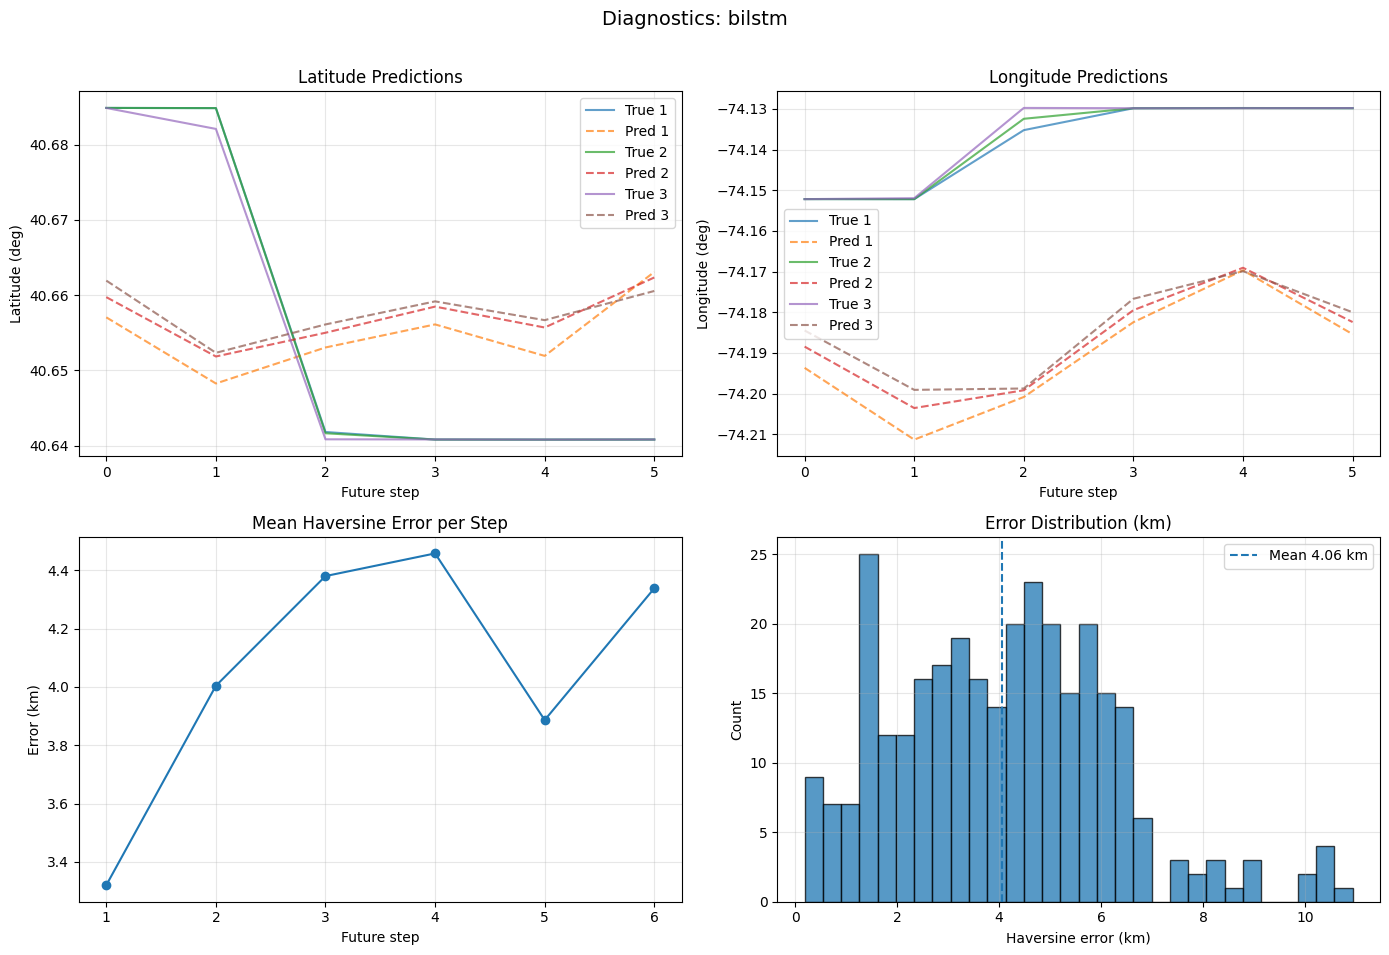

      1/Unknown 0s 316ms/step

/usr/local/lib/python3.12/dist-packages/keras/src/ops/nn.py:944: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 23, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/ops/nn.py:944: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 23, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 206ms/step

[bilstm_attention] Evaluation summary:
Input length expected by model: 23
Future steps: 6
ADE: 3.183 km  (1.719 nm)
FDE: 4.066 km  (2.196 nm)
R² overall: 1.0000
Lat RMSE (deg): 0.02207
Lon RMSE (deg): 0.03425


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


[bilstm_attention] Saved plot -> ./logs/diagnostics_plots/bilstm_attention_diagnostics.png


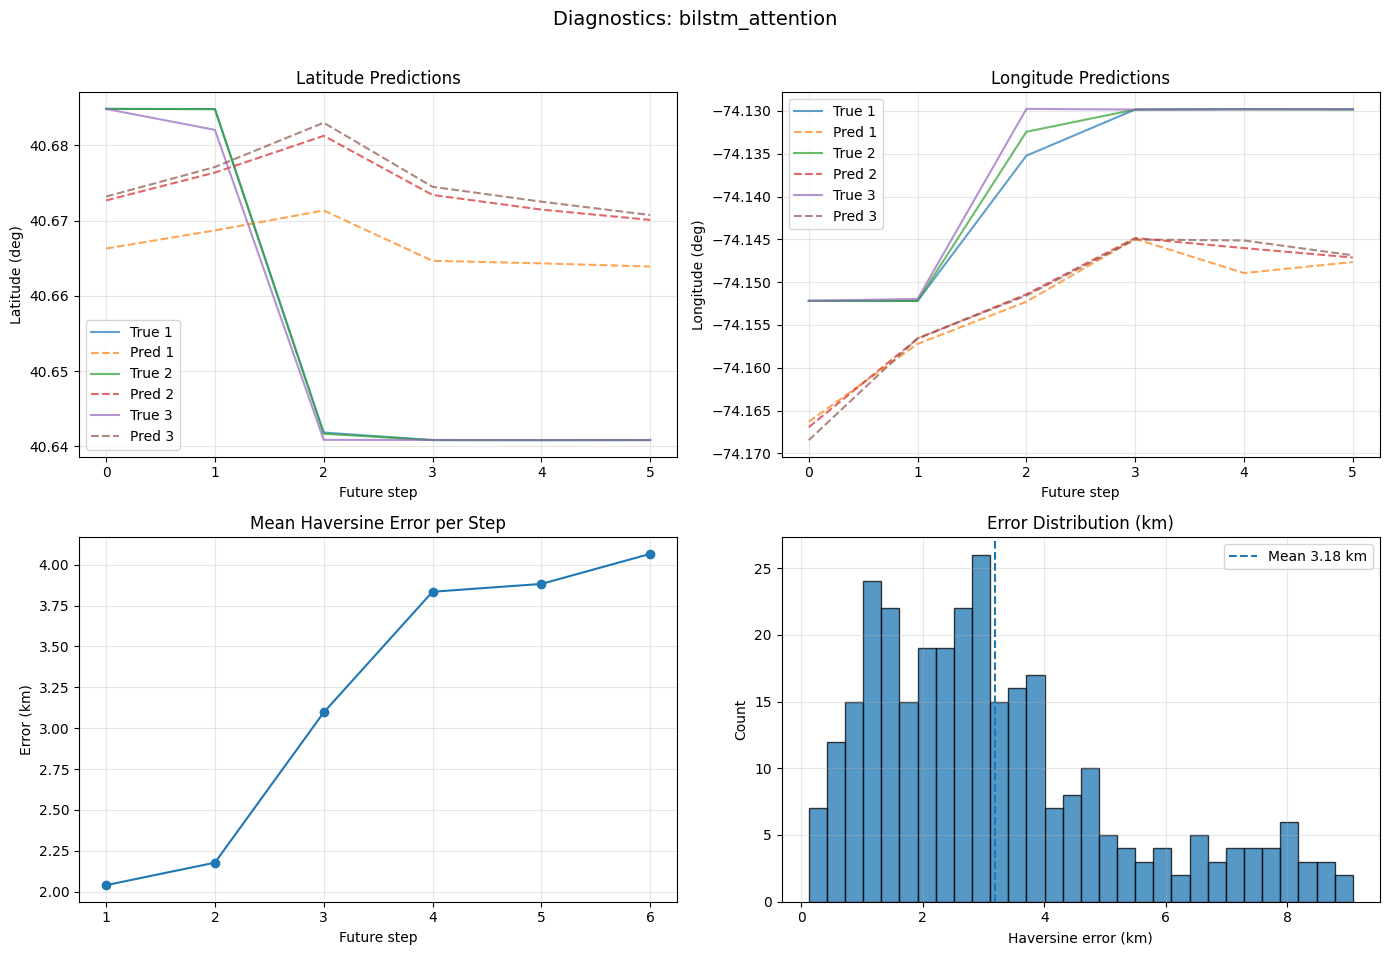

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step

[gru] Evaluation summary:
Input length expected by model: 23
Future steps: 6
ADE: 3.838 km  (2.072 nm)
FDE: 4.342 km  (2.345 nm)
R² overall: 1.0000
Lat RMSE (deg): 0.02808
Lon RMSE (deg): 0.03894


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


[gru] Saved plot -> ./logs/diagnostics_plots/gru_diagnostics.png


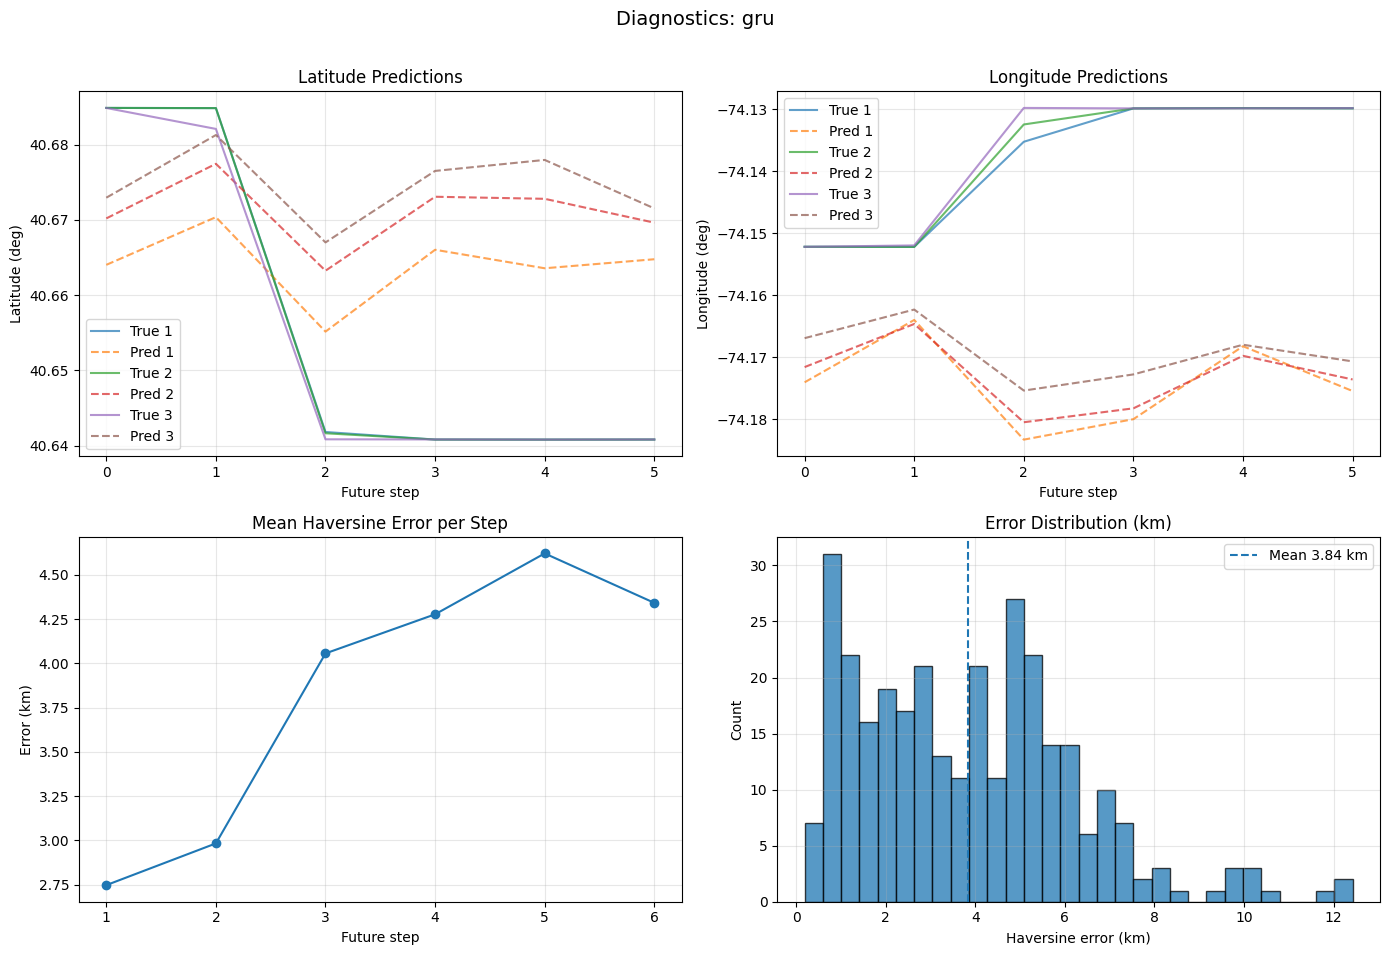

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step

[lstm] Evaluation summary:
Input length expected by model: 23
Future steps: 6
ADE: 4.193 km  (2.264 nm)
FDE: 4.789 km  (2.586 nm)
R² overall: 1.0000
Lat RMSE (deg): 0.03225
Lon RMSE (deg): 0.03735


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


[lstm] Saved plot -> ./logs/diagnostics_plots/lstm_diagnostics.png


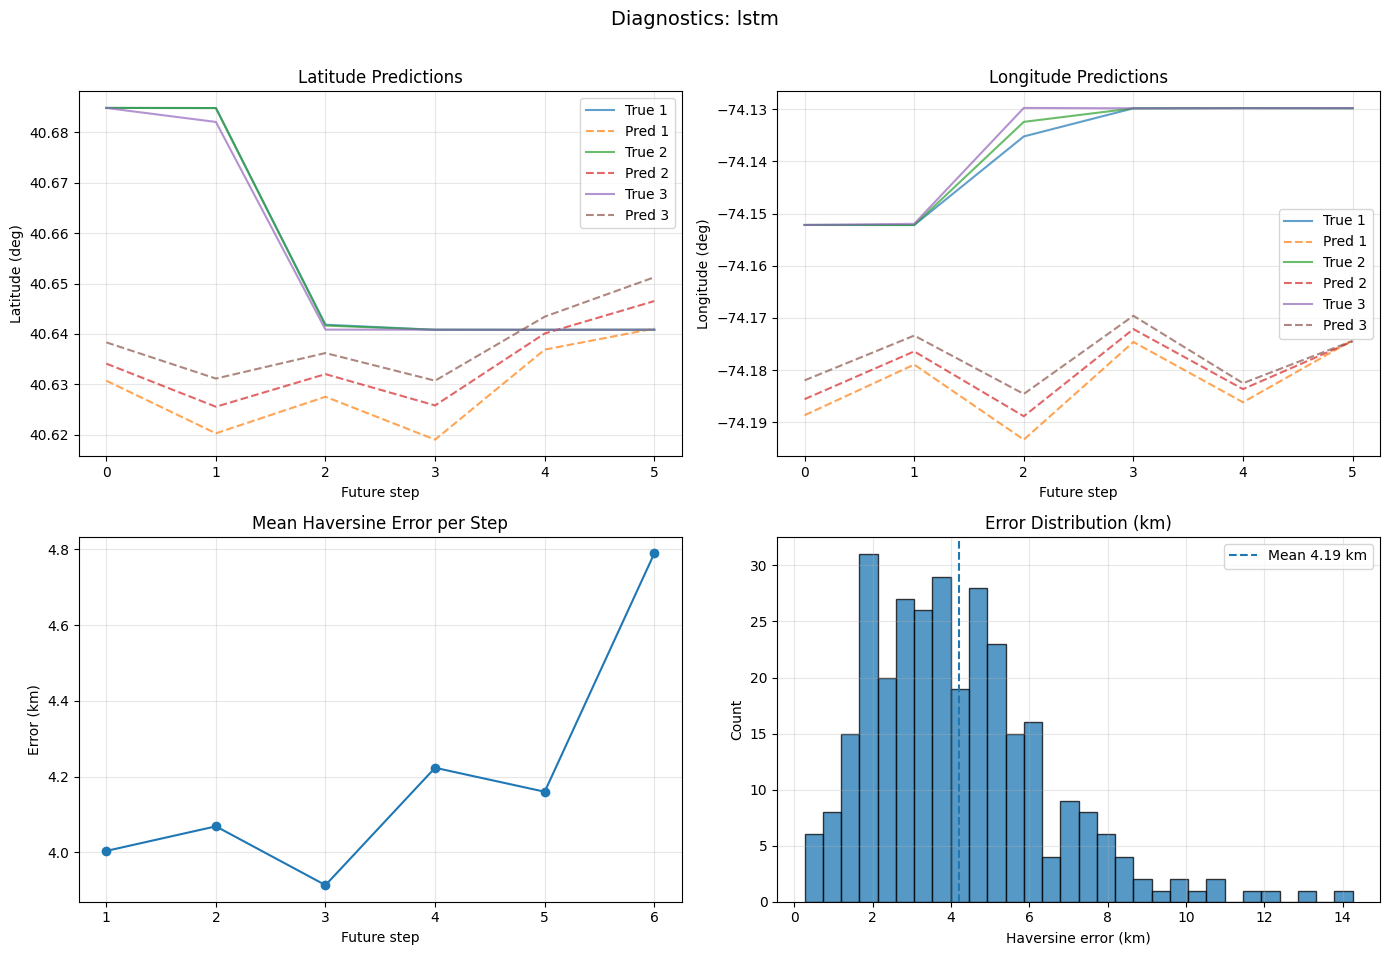


MODEL COMPARISON (sorted by ADE_km):
Model                 T   S    ADE_km   FDE_km   RMSE_km      R2  lat_RMSE°  lon_RMSE°
------------------------------------------------------------------------------------------
bilstm_attention     23   6     3.183    4.066     3.791  1.0000    0.02207    0.03425
gru                  23   6     3.838    4.342     4.533  1.0000    0.02808    0.03894
bilstm               23   6     4.065    4.338     4.596  1.0000    0.02830    0.03971
lstm                 23   6     4.193    4.789     4.774  1.0000    0.03225    0.03735


In [ ]:
#@title Test-compatible multi-model evaluator with per-model plots
# - Discovers all tuning_* model folders under logs
# - Loads each model + scalers
# - Adapts sequence length per model (pad/truncate)
# - Scales inputs/targets exactly like the tuner
# - Computes ADE/FDE/RMSE + coordinate metrics
# - Plots a 2x2 diagnostic figure per model (and optionally saves PNGs)
# - Prints a summary table sorted by ADE

import os, json, joblib, numpy as np, tensorflow as tf
import matplotlib.pyplot as plt
from typing import Tuple, Optional, Dict, List
from tensorflow.keras.models import load_model
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# ---------- Metrics ----------
def haversine_km(lat1, lon1, lat2, lon2):
    R = 6371.0
    lat1 = np.radians(lat1); lon1 = np.radians(lon1)
    lat2 = np.radians(lat2); lon2 = np.radians(lon2)
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = (np.sin(dlat/2.0)**2) + np.cos(lat1) * np.cos(lat2) * (np.sin(dlon/2.0)**2)
    c = 2.0 * np.arcsin(np.sqrt(a))
    return R * c

class HaversineMetric(tf.keras.metrics.Metric):
    # Minimal stub, only needed if a compiled model references it
    def __init__(self, name='haversine', **kwargs):
        super().__init__(name=name, **kwargs)
        self.total = self.add_weight('total', initializer='zeros')
        self.count = self.add_weight('count', initializer='zeros')
    def update_state(self, y_true, y_pred, sample_weight=None):
        true_lat, true_lon = y_true[..., 0], y_true[..., 1]
        pred_lat, pred_lon = y_pred[..., 0], y_pred[..., 1]
        pi = tf.constant(np.pi, dtype=tf.float32)
        lat1 = true_lat * pi / 180.0; lon1 = true_lon * pi / 180.0
        lat2 = pred_lat * pi / 180.0; lon2 = pred_lon * pi / 180.0
        dlat = lat2 - lat1; dlon = lon2 - lon1
        a = tf.sin(dlat/2.0)**2 + tf.cos(lat1)*tf.cos(lat2)*tf.sin(dlon/2.0)**2
        c = 2.0 * tf.asin(tf.sqrt(tf.clip_by_value(a, 0.0, 1.0)))
        dist = 6371.0 * c
        self.total.assign_add(tf.reduce_sum(dist))
        self.count.assign_add(tf.cast(tf.size(dist), tf.float32))
    def result(self):
        return self.total / tf.maximum(self.count, 1.0)
    def reset_state(self):
        self.total.assign(0.0); self.count.assign(0.0)

# ---------- Discovery ----------
def _find_log_root() -> str:
    for p in ["./logs", "/content/logs"]:
        if os.path.exists(p):
            return p
    raise FileNotFoundError("No logs directory found (looked in ./logs and /content/logs).")

def discover_arch_dirs(log_root: str) -> List[Tuple[str, str]]:
    """Return list of (arch, arch_dir) that contain both best_model.h5 and scalers.joblib."""
    out = []
    for name in os.listdir(log_root):
        if not name.startswith("tuning_"):
            continue
        arch = name[len("tuning_"):]
        arch_dir = os.path.join(log_root, name)
        if not os.path.isdir(arch_dir):
            continue
        model_path = os.path.join(arch_dir, "best_model.h5")
        scalers_path = os.path.join(arch_dir, "scalers.joblib")
        if os.path.exists(model_path) and os.path.exists(scalers_path):
            out.append((arch, arch_dir))
    if not out:
        raise FileNotFoundError("No tuning_* folders with best_model.h5 and scalers.joblib found.")
    return sorted(out)  # alphabetical

def discover_data_path() -> str:
    for p in [
        "./data/new_york_2015.h5",
        "./data/new_york_2015_filtered.h5",
        "/content/data/new_york_2015.h5",
        "/content/data/new_york_2015_filtered.h5",
    ]:
        if os.path.exists(p):
            return p
    raise FileNotFoundError("No data file found in expected locations.")

# ---------- Dataset pipeline (uses the tuner's make_dataset) ----------
def build_test_dataset(data_path: str, batch_size: int = 32):
    from tuner import make_dataset
    return make_dataset(
        data_path,
        split="test",
        batch_size=batch_size,
        shuffle=False,
        cache=False,
        drop_remainder=False
    )

def pad_or_truncate_time(x, expected_T):
    # x: (B, T, F) -> (B, expected_T, F)
    T = tf.shape(x)[1]
    F = tf.shape(x)[2]
    B = tf.shape(x)[0]

    def do_pad():
        pad_len = expected_T - T
        pads = tf.zeros([B, pad_len, F], dtype=x.dtype)
        return tf.concat([x, pads], axis=1)

    def do_trunc():
        return x[:, :expected_T, :]

    return tf.cond(
        T < expected_T,
        do_pad,
        lambda: tf.cond(T > expected_T, do_trunc, lambda: x),
    )

def scaler_map_fn(history_scaler, target_scaler, expected_T, feature_dim, future_steps, target_dim):
    def _scale_np(x_np, y_np):
        B, T, F = x_np.shape
        _, S, C = y_np.shape
        x_flat = x_np.reshape(-1, F)
        y_flat = y_np.reshape(-1, C)
        x_scaled = history_scaler.transform(x_flat).reshape(B, T, F).astype(np.float32)
        y_scaled = target_scaler.transform(y_flat).reshape(B, S, C).astype(np.float32)
        return x_scaled, y_scaled

    def _map(x, y):
        x = pad_or_truncate_time(x, expected_T)
        xs, ys = tf.numpy_function(_scale_np, [x, y], [tf.float32, tf.float32])
        xs.set_shape([None, expected_T, feature_dim])
        ys.set_shape([None, future_steps, target_dim])
        return xs, ys
    return _map

# ---------- Core evaluation + plotting ----------
def load_artifacts_for_arch(arch_dir: str) -> Dict:
    model_path = os.path.join(arch_dir, "best_model.h5")
    scalers_path = os.path.join(arch_dir, "scalers.joblib")

    model = load_model(
        model_path,
        custom_objects={"HaversineMetric": HaversineMetric},
        compile=False,
    )

    scalers = joblib.load(scalers_path)
    history_scaler = scalers["history_scaler"]
    target_scaler = scalers["target_scaler"]

    expected_T = int(model.input_shape[1])
    feature_dim = int(model.input_shape[2])
    future_steps = int(model.output_shape[1])
    target_dim = int(model.output_shape[2])

    return {
        "model": model,
        "history_scaler": history_scaler,
        "target_scaler": target_scaler,
        "expected_T": expected_T,
        "feature_dim": feature_dim,
        "future_steps": future_steps,
        "target_dim": target_dim,
    }

def inverse_target(target_scaler, arr):
    B, S, C = arr.shape
    flat = target_scaler.inverse_transform(arr.reshape(-1, C))
    return flat.reshape(B, S, C)

def compute_metrics(y_true, y_pred) -> Dict[str, float]:
    err_km = haversine_km(y_true[..., 0], y_true[..., 1], y_pred[..., 0], y_pred[..., 1])
    metrics = {
        "ADE_km": float(np.mean(err_km)),
        "FDE_km": float(np.mean(err_km[:, -1])),
        "ADE_nm": float(np.mean(err_km) / 1.852),
        "FDE_nm": float(np.mean(err_km[:, -1]) / 1.852),
        "RMSE_haversine_km": float(np.sqrt(np.mean(err_km**2))),
        "median_err_km": float(np.median(err_km)),
        "std_err_km": float(np.std(err_km)),
    }
    yt_flat = y_true[..., :2].reshape(-1, 2)
    yp_flat = y_pred[..., :2].reshape(-1, 2)
    for i, axis in enumerate(("lat", "lon")):
        mae = mean_absolute_error(yt_flat[:, i], yp_flat[:, i])
        mse = mean_squared_error(yt_flat[:, i], yp_flat[:, i])
        r2 = r2_score(yt_flat[:, i], yp_flat[:, i])
        metrics[f"{axis}_mae_deg"] = float(mae)
        metrics[f"{axis}_rmse_deg"] = float(np.sqrt(mse))
        metrics[f"{axis}_r2"] = float(r2)
    metrics["avg_mae_deg"] = (metrics["lat_mae_deg"] + metrics["lon_mae_deg"]) / 2.0
    metrics["avg_rmse_deg"] = (metrics["lat_rmse_deg"] + metrics["lon_rmse_deg"]) / 2.0
    metrics["overall_r2"] = float(r2_score(yt_flat.ravel(), yp_flat.ravel()))
    return metrics, err_km

def plot_model_diagnostics(arch: str, y_true: np.ndarray, y_pred: np.ndarray,
                           err_km: np.ndarray, save_dir: Optional[str] = None,
                           num_examples: int = 3):
    """Create a 2x2 diagnostic plot for one model."""
    n = min(num_examples, y_pred.shape[0])
    steps = y_pred.shape[1]

    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle(f"Diagnostics: {arch}", fontsize=14)

    # (0,0) Latitude predictions
    for i in range(n):
        axes[0, 0].plot(y_true[i, :, 0], label=f"True {i+1}", alpha=0.7)
        axes[0, 0].plot(y_pred[i, :, 0], linestyle='--', label=f"Pred {i+1}", alpha=0.7)
    axes[0, 0].set_title("Latitude Predictions")
    axes[0, 0].set_xlabel("Future step")
    axes[0, 0].set_ylabel("Latitude (deg)")
    axes[0, 0].grid(True, alpha=0.3)
    if n > 1:
        axes[0, 0].legend()

    # (0,1) Longitude predictions
    for i in range(n):
        axes[0, 1].plot(y_true[i, :, 1], label=f"True {i+1}", alpha=0.7)
        axes[0, 1].plot(y_pred[i, :, 1], linestyle='--', label=f"Pred {i+1}", alpha=0.7)
    axes[0, 1].set_title("Longitude Predictions")
    axes[0, 1].set_xlabel("Future step")
    axes[0, 1].set_ylabel("Longitude (deg)")
    axes[0, 1].grid(True, alpha=0.3)
    if n > 1:
        axes[0, 1].legend()

    # (1,0) Error per future step
    err_per_step = np.mean(err_km, axis=0)
    axes[1, 0].plot(range(1, steps + 1), err_per_step, marker='o')
    axes[1, 0].set_title("Mean Haversine Error per Step")
    axes[1, 0].set_xlabel("Future step")
    axes[1, 0].set_ylabel("Error (km)")
    axes[1, 0].grid(True, alpha=0.3)

    # (1,1) Error distribution
    axes[1, 1].hist(err_km.ravel(), bins=30, edgecolor='black', alpha=0.75)
    axes[1, 1].axvline(np.mean(err_km), linestyle='--', label=f"Mean {np.mean(err_km):.2f} km")
    axes[1, 1].set_title("Error Distribution (km)")
    axes[1, 1].set_xlabel("Haversine error (km)")
    axes[1, 1].set_ylabel("Count")
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout(rect=[0, 0.03, 1, 0.97])
    if save_dir:
        os.makedirs(save_dir, exist_ok=True)
        out_path = os.path.join(save_dir, f"{arch}_diagnostics.png")
        plt.savefig(out_path, dpi=150)
        print(f"[{arch}] Saved plot -> {out_path}")
    plt.show()

def evaluate_one_arch(arch: str, arch_dir: str, ds_test_raw: tf.data.Dataset,
                      save_dir: Optional[str] = None, num_examples_plot: int = 3) -> Dict:
    art = load_artifacts_for_arch(arch_dir)
    model = art["model"]
    history_scaler = art["history_scaler"]
    target_scaler = art["target_scaler"]
    expected_T = art["expected_T"]
    feature_dim = art["feature_dim"]
    future_steps = art["future_steps"]
    target_dim = art["target_dim"]

    ds_scaled = ds_test_raw.map(
        scaler_map_fn(history_scaler, target_scaler, expected_T, feature_dim, future_steps, target_dim),
        num_parallel_calls=tf.data.AUTOTUNE
    )

    # Determine steps to avoid "ran out of data" warning
    card = tf.data.experimental.cardinality(ds_scaled)
    steps = int(card.numpy()) if card != tf.data.experimental.UNKNOWN_CARDINALITY else None

    # Predict
    if steps is not None and steps > 0:
        y_pred_scaled = model.predict(ds_scaled, steps=steps, verbose=1)
    else:
        y_pred_scaled = model.predict(ds_scaled, verbose=1)

    # Collect scaled y_true for inverse transform
    y_true_scaled = []
    for _, yb in ds_scaled:
        y_true_scaled.append(yb.numpy())
    y_true_scaled = np.concatenate(y_true_scaled, axis=0)

    # Inverse-transform to original units
    y_pred = inverse_target(target_scaler, y_pred_scaled)
    y_true = inverse_target(target_scaler, y_true_scaled)

    # Metrics + plots
    metrics, err_km = compute_metrics(y_true, y_pred)

    print(f"\n[{arch}] Evaluation summary:")
    print(f"Input length expected by model: {expected_T}")
    print(f"Future steps: {future_steps}")
    print(f"ADE: {metrics['ADE_km']:.3f} km  ({metrics['ADE_nm']:.3f} nm)")
    print(f"FDE: {metrics['FDE_km']:.3f} km  ({metrics['FDE_nm']:.3f} nm)")
    print(f"R² overall: {metrics['overall_r2']:.4f}")
    print(f"Lat RMSE (deg): {metrics['lat_rmse_deg']:.5f}")
    print(f"Lon RMSE (deg): {metrics['lon_rmse_deg']:.5f}")

    # Plot per-model diagnostics
    plot_model_diagnostics(arch, y_true, y_pred, err_km, save_dir=save_dir, num_examples=num_examples_plot)

    # Attach some shape info used in comparison table
    metrics["_expected_T"] = expected_T
    metrics["_future_steps"] = future_steps
    return metrics

# ---------- Evaluate all discovered models ----------
def evaluate_all_models(architectures: Optional[List[str]] = None,
                        batch_size: int = 32,
                        save_plots_to: Optional[str] = None,
                        num_examples_plot: int = 3) -> Dict[str, Dict]:
    log_root = _find_log_root()
    data_path = discover_data_path()
    arch_dirs = discover_arch_dirs(log_root)

    # Filter by requested architectures if provided
    if architectures:
        arch_set = set(a.lower() for a in architectures)
        arch_dirs = [(a, d) for (a, d) in arch_dirs if a.lower() in arch_set]
        if not arch_dirs:
            raise ValueError(f"No matching architectures found among requested: {architectures}")

    print(f"Data: {data_path}")
    print(f"Logs: {log_root}")
    print("Discovered models:", ", ".join(a for a, _ in arch_dirs))

    # Build raw test dataset once
    ds_test_raw = build_test_dataset(data_path, batch_size=batch_size)

    results: Dict[str, Dict] = {}
    for arch, arch_dir in arch_dirs:
        try:
            metrics = evaluate_one_arch(
                arch, arch_dir, ds_test_raw,
                save_dir=save_plots_to,
                num_examples_plot=num_examples_plot
            )
            results[arch] = metrics
        except Exception as e:
            print(f"[{arch}] Evaluation failed: {e}")

    # Print comparison table
    if results:
        print("\nMODEL COMPARISON (sorted by ADE_km):")
        print(f"{'Model':<18} {'T':>4} {'S':>3}  {'ADE_km':>8} {'FDE_km':>8} {'RMSE_km':>9} {'R2':>7} {'lat_RMSE°':>10} {'lon_RMSE°':>10}")
        print("-" * 90)
        for arch, m in sorted(results.items(), key=lambda x: x[1]["ADE_km"]):
            print(f"{arch:<18} {m['_expected_T']:>4} {m['_future_steps']:>3}  "
                  f"{m['ADE_km']:>8.3f} {m['FDE_km']:>8.3f} {m['RMSE_haversine_km']:>9.3f} "
                  f"{m['overall_r2']:>7.4f} {m['lat_rmse_deg']:>10.5f} {m['lon_rmse_deg']:>10.5f}")
    else:
        print("No models evaluated successfully.")

    return results

# ---------- CLI ----------
if __name__ == "__main__":
    # Evaluate all models and save plots to ./logs/diagnostics_plots (optional)
    # results = evaluate_all_models(architectures=["bilstm_attention", "bilstm"], save_plots_to="./logs/diagnostics_plots")
    results = evaluate_all_models(save_plots_to="./logs/diagnostics_plots")
